<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Unilever/Unilever_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UNA.AS"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  17.60  18.01  17.34  17.99      12.38   4118227
2009-01-05  18.10  18.10  17.70  18.00      12.39   5947068
2009-01-06  18.15  18.37  17.89  18.01      12.40   6820561
2009-01-07  17.95  17.95  17.40  17.65      12.14   6905543
2009-01-08  17.57  17.82  17.26  17.74      12.21   5279969
...           ...    ...    ...    ...        ...       ...
2018-12-21  47.72  47.96  46.88  47.96      46.84  11104086
2018-12-24  47.60  47.80  46.99  46.99      45.89   1085623
2018-12-27  47.49  47.59  46.06  46.50      45.41   4130227
2018-12-28  46.56  47.19  46.56  46.88      45.79   2990853
2018-12-31  46.74  47.42  46.66  47.42      46.31   1095713

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean     32.336998    32.600356    32.080997    32.352127    27.725043  5.059662e+06
std      10.006746    10.066808     9.955280    10.010965    11.102579  2.415643e+06
min      13.740000    13.950000    13.450000    13.590000     9.350000  2.936270e+05
25%      23.132500    23.375000    22.900000    23.132500    17.360000  3.580926e+06
50%      30.330000    30.575000    30.115000    30.335000    25.125000  4.540038e+06
75%      40.267500    40.670000    39.967500    40.365000    35.897500  5.897538e+06
max      51.830000    52.310000    51.700000    52.250000    49.030000  3.156753e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  14.38  14.49  14.10  14.16       9.74   8612200   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  14.007007  14.597813  13.503520  13.998417  14.258930  14.342772      14.105      14.010  14.833284  14.12000  14.124327  14.0420  14.113889  14.12000  14.196667  14.905865               14.612138                 14.12000               13.627862               14.858207                 14.12000               13.381793               15.104276                 14.12000               13.135724               15.350345                 14.12000               12.889655  14.258930  14.180667  14.779432               14.751068                14.258930               13.766792               14.997137                14.258930               13.520722               15.243206                14.258930               13.274653               15.489275                14.258930   
2009-03-16  14.50  14.65  14.38  14.65      10.08   6348626   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  14.039157  14.583847  13.562709  14.210806  14.345834  14.345398      14.160      14.050  14.722621  14.13375  14.406335  14.0930  14.231667  14.13375  14.405000  14.811420               14.675685                 14.13375               13.591815               14.946653                 14.13375               13.320847               15.217620                 14.13375               13.049880               15.488588                 14.13375               12.778912  14.345834  14.497144  14.691527               14.887769                14.345834               13.803899               15.158737                14.345834               13.532931               15.429705                14.345834               13.261964               15.700672                14.345834   
2009-03-17  14.52  14.55  14.19  14.30   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean     32.653138    32.917867    32.397827    32.669749    28.052516  4.977926e+06    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955    32.635906    32.530057     3.235783    32.670055    32.623409    32.594223    32.619926    32.594392    32.493084    32.623586    32.670050    32.623680    32.639047    32.623586    32.661374    32.530112               33.361509                32.623586               31.885662               33.730471                32.623586               31.516700               34.099433                32.623586               31.147738               34.468394                32.623586               30.778777    32.623409    32.660438    32.544038               33.361332                32.623409               31.885485               33.730294                32.623409               31.516523               34.099256   
std       9.847842     9.907784     9.793402     9.849732    10.964458  2.327267e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     9.868562     9.871394    33.815496     9.854514     9.843183     9.821908     9.847930     9.839048     9.850939     9.848816     9.851803     9.851141     9.847315     9.848816     9.849503     9.841326               10.040706                 9.848816                9.680802               10.145187                 9.848816                9.606146               10.255130                 9.848816                9.537924               10.370362                 9.848816                9.476275     9.843183     9.847924     9.842934               10.035520                 9.843183                9.674718               10.140223                 9.843183                9.599837               10.250386   
min      13.750000    13.950000    13.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.016544  0.014077  0.016993  0.014744   0.009829   8612200   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.005247  0.639966  0.006412  0.006990  0.001219    0.000000    0.000000  0.035597  0.000876  0.010023  0.001030  0.004025  0.000876  0.015516  0.016095                0.000000                 0.000876                0.009183                0.000000                 0.000876                0.015496                0.000000                 0.000876                0.021698                0.000000                 0.000876                0.027791  0.006990  0.013293  0.013984                0.001830                 0.006990                0.012256                0.000655                 0.006990                0.015445                0.000000                 0.006990                0.020948                0.001981                 0.006990   
2009-03-16  0.019695  0.018248  0.024314  0.027419   0.018397   6348626   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000854  0.004862  0.640541  0.011964  0.009313  0.001290    0.001485    0.001079  0.032749  0.001247  0.017347  0.002393  0.007156  0.001247  0.020934  0.013488                0.001612                 0.001247                0.008209                0.002149                 0.001247                0.013863                0.002640                 0.001247                0.019417                0.003091                 0.001247                0.024874  0.009313  0.021529  0.011566                0.005374                 0.009313                0.013261                0.004671                 0.009313                0.015774                0.004441                 0.009313                0.020609                0.006801                 0.009313   
2009-03-17  0.020221  0.015641  0.019346  0.0183

140200

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6x9z7tgr
  JVM stdout: /tmp/tmp6x9z7tgr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6x9z7tgr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_fuzzir
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.540840   3.793556              0.478467  0.660878  0.436759
1  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.520929  14.433490              0.500000  0.722962  0.522674
2  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.505757  13.337116              0.500000  0.683985  0.467836
3  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.501018  15.141679              0.491667  0.695409  0.483594
4  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.500000   0.692251              0.500000  0.499552  0.249552
5  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.500000   0.692775              0.500000  0.499814  0.249814
6  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.500000   0.692504              0.500000  0.499678  0.249678
7  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.500000   0.692315              0.500000  0.499584  0.249584
8              DeepLearning_1_AutoML_20190903_020149  0.488041  12.010544              0.500000  0.684297  0.468262
9  DeepLearning_grid_1_AutoML_20190903_020149_mod...  0.455630   7.816863              0.491667  0.671703  0.451185

variable  relative_importance  scaled_importance  percentage
0                      weekday             1.000000           1.000000    0.001129
1                    dayofweek             0.980565           0.980565    0.001107
2                          day             0.979217           0.979217    0.001105
3                      quarter             0.954612           0.954612    0.001078
4            CDLLONGLEGGEDDOJI             0.953212           0.953212    0.001076
...                        ...                  ...                ...         ...
1036                   MA_30_7             0.788794           0.788794    0.000891
1037                 MAVP_20_0             0.779059           0.779059    0.000880
1038                    CCI_24             0.776955           0.776955    0.000877
1039                   MA_20_3             0.774337           0.774337    0.000874
1040  BBANDS_middleband_20_3_5             0.773190           0.773190    0.000873

[1041 rows x 4 columns]

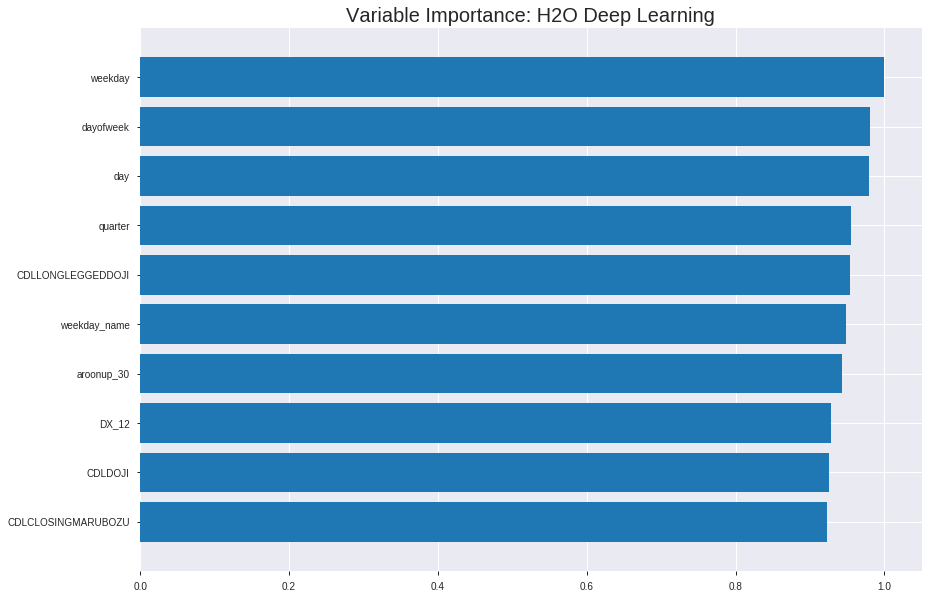

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_020149_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23479604319783823
RMSE: 0.48455757469865046
LogLoss: 0.6549608164284049
Mean Per-Class Error: 0.4135464457577642
AUC: 0.6459342931606114
pr_auc: 0.697098259642587
Gini: 0.2918685863212227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39658903675556195: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      172  659   0.793    (659.0/831.0)
1      43   880   0.0466   (43.0/923.0)
Total  215  1539  0.4002   (702.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396589     0.714866  255
max f2                       0.27994      0.854942  317
max f0point5                 0.408298     0.62188   246
max accuracy                 0.413221     0.600342  240
max precision                0.999758     1         0
max recall                   0.0372741    1         377
max specificity              0.999758     1         0
max absolute_mcc             0.396589     0.2442    255
max min_per_class_accuracy   0.414378     0.303359  239
max mean_per_class_accuracy  0.421819     0.586454  229

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 43.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.984575           1.90033   1.90033            1                0.995806  1                           0.995806            0.0195016       0.0195016                  90.0325    90.0325
    2        0.0205245                   0.945043           1.79475   1.84754            0.944444         0.966951  0.972222                    0.981379            0.0184182       0.0379198                  79.4751    84.7538
    3        0.0302166                   0.900542           1.78854   1.82861            0.941176         0.917983  0.962264                    0.961044            0.0173348       0.0552546                  78.8541    82.8615
    4        0.0404789                   0.874131           1.68918   1.79326            0.888889         0.891249  0.943662                    0.943349            0.0173348       0.0725894                  68.9178    79.3264
    5        0.050171                    0.826308           1.67676   1.77076            0.882353         0.849277  0.931818                    0.925176            0.0162514       0.0888407                  67.6757    77.0757
    6        0.100342                    0.558586           1.44684   1.6088             0.761364         0.687589  0.846591                    0.806383            0.0725894       0.16143                    44.6838    60.8798
    7        0.149943                    0.46895            1.17951   1.46679            0.62069          0.507538  0.771863                    0.707526            0.0585049       0.219935                   17.9512    46.6791
    8        0.200114                    0.423022           1.2093    1.40223            0.636364         0.441996  0.737892                    0.640954            0.0606717       0.280607                   20.9298    40.2234
    9        0.860889                    0.413221           0.995252  1.08986            0.523727         0.413405  0.57351                     0.466299            0.657638        0.938245                   -0.474781  8.98553
    10       0.899658                    0.360277           0.642757  1.07059            0.338235         0.391632  0.563371                    0.463081            0.0249187       0.963164                   -35.7243   7.05887
    11       1                           0.000399884        0.367108  1                  0.193182         0.171405  0.526226                    0.433814            0.0368364       1                          -63.2892   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35889097493314404
RMSE: 0.5990750995769596
LogLoss: 4.678909450285613
Mean Per-Class Error: 0.4685401286020481
AUC: 0.5180836707152496
pr_auc: 0.5401798949844187
Gini: 0.03616734143049927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.875349901509231e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.87535e-50  0.673712   203
max f2                       7.87535e-50  0.837714   203
max f0point5                 6.32661e-23  0.569368   159
max accuracy                 0.008744     0.533865   47
max precision                0.484444     0.615385   12
max recall                   7.87535e-50  1          203
max specificity              0.901347     0.995951   0
max absolute_mcc             0.726663     0.0750858  5
max min_per_class_accuracy   0.413221     0.421053   13
max mean_per_class_accuracy  0.008744     0.53146    47

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 25.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.726447           0.328105  0.328105           0.166667         0.799586     0.166667                    0.799586            0.00392157      0.00392157                 -67.1895  -67.1895
    2        0.0219124                   0.600139           1.96863   1.0738             1                0.669228     0.545455                    0.740332            0.0196078       0.0235294                  96.8627   7.37968
    3        0.583665                    0.413221           1.00526   1.00783            0.510638         0.414052     0.511945                    0.426301            0.564706        0.588235                   0.525657  0.782975
    4        0.599602                    0.0370238          1.47647   1.02029            0.75             0.084461     0.518272                    0.417216            0.0235294       0.611765                   47.6471   2.02853
    5        0.699203                    0.00123306         1.06306   1.02638            0.54             0.0114273    0.521368                    0.359411            0.105882        0.717647                   6.30588   2.63784
    6        0.798805                    1.69438e-12        1.02369   1.02604            0.52             0.000173192  0.521197                    0.314619            0.101961        0.819608                   2.36863   2.60427
    7        0.898406                    1.70609e-26        0.944941  1.01705            0.48             7.12232e-14  0.51663                     0.279738            0.0941176       0.913725                   -5.50588  1.70514
    8        1                           8.58582e-281       0.849212  1                  0.431373         5.53614e-28  0.507968                    0.251319            0.0862745       1                          -15.0788  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:16:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:16:35  6.854 sec         118 obs/sec       0.269099  1             472        0.654467         2.88029             -0.718032      0.531007        0.438596           1.16131          0.472064                         0.70132            9.93327               -0.967898        0.493213          0.294444             0.989069           0.492032
    2019-09-03 02:17:04  35.732 sec        193 obs/sec       3.33181   13            5844       0.602991         0.980562            -0.458407      0.558502        0.602906           1.79475          0.442987                         0.640454           4.9528                -0.641141        0.487076          0.392497             0.830515           0.492032
    2019-09-03 02:17:31  1 min  3.582 sec  237 obs/sec       7.50171   29            13158      0.489218         0.666073            0.040023       0.593212        0.638337           1.90033          0.423603                         0.597873           7.3712                -0.430172        0.4918            0.303017             0.952217           0.492032
    2019-09-03 02:17:59  1 min 31.069 sec  257 obs/sec       11.7948   46            20688      0.484558         0.654961            0.0582248      0.645934        0.697098           1.90033          0.400228                         0.599075           4.67891               -0.435929        0.518084          0.54018              0.328105           0.492032
    2019-09-03 02:18:27  1 min 58.832 sec  264 obs/sec       15.8831   62            27859      0.467562         0.615308            0.12313        0.669676        0.718402           1.90033          0.391106                         0.599473           7.09486               -0.437839        0.490641          0.324209             0.965972           0.492032
    2019-09-03 02:18:55  2 min 26.846 sec  275 obs/sec       20.4778   80            35918      0.463601         0.602646            0.137924       0.685874        0.721079           1.90033          0.381984                         0.605904           7.44694               -0.468852        0.50593           0.307606             0.957995           0.486056
    2019-09-03 02:19:23  2 min 55.017 sec  281 obs/sec       25.0906   98            44009      0.452693         0.570515            0.178013       0.734734        0.764124           1.90033          0.351197                         0.603455           7.53852               -0.457           0.492308          0.298398             0.974568           0.49004
    2019-09-03 02:19:26  2 min 57.720 sec  281 obs/sec       25.0906   98            44009      0.484558         0.654961            0.0582248      0.645934        0.697098           1.90033          0.400228                         0.599075           4.67891               -0.435929        0.518084          0.54018              0.328105           0.492032

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday                   1.0                    1.0                  0.0011289532179759884
dayofweek                 0.9805652499198914     0.9805652499198914   0.0011070122943324908
day                       0.9792169332504272     0.9792169332504272   0.0011054901078896486
quarter                   0.954611599445343      0.954611599445343    0.0010777118371110253
CDLLONGLEGGEDDOJI         0.9532123804092407     0.9532123804092407   0.0010761321842775644
---                       ---                    ---                  ---
MA_30_7                   0.7887935042381287     0.7887935042381287   0.0008905109649281919
MAVP_20_0                 0.7790588736534119     0.7790588736534119   0.0008795210224037684
CCI_24                    0.7769550085067749     0.7769550085067749   0.000877145857076285
MA_20_3                   0.7743369936943054     0.7743369936943054   0.0008741902408290388
BBANDS_middleband_20_3_5  0.7731897830963135     0.7731897830963135   0.0008728950937327397


See the whole table with table.as_data_frame()


('accuracy', 0.5776892430278885)

('F1', 0.6916890080428955)

('auc', 0.5408396946564886)

('logloss', 3.7935561919417786)

('mean_per_class_error', 0.42697201017811703)

('rmse', 0.6608777853878929)

('mse', 0.4367594472192058)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


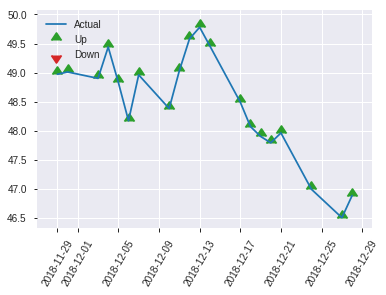


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4367594472192058
RMSE: 0.6608777853878929
LogLoss: 3.7935561919417786
Mean Per-Class Error: 0.42697201017811703
AUC: 0.5408396946564886
pr_auc: 0.5235070862935212
Gini: 0.08167938931297725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.620476007809273e-19: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    113  0.9417   (113.0/120.0)
1      2    129  0.0153   (2.0/131.0)
Total  9    242  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.62048e-19  0.691689  214
max f2                       1.24398e-25  0.847348  221
max f0point5                 0.0171197    0.598923  125
max accuracy                 0.0171197    0.577689  125
max precision                0.0171197    0.581699  125
max recall                   1.24398e-25  1         221
max specificity              0.697304     0.991667  0
max absolute_mcc             0.0171197    0.14955   125
max min_per_class_accuracy   0.0291196    0.55      99
max mean_per_class_accuracy  0.0171197    0.573028  125

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 12.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.586285           0.638677  0.638677           0.333333         0.653932     0.333333                    0.653932            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0239044                   0.552102           1.27735   0.958015           0.666667         0.563567     0.5                         0.608749            0.0152672       0.0229008                  27.7354    -4.19847
    3        0.0318725                   0.478147           0.958015  0.958015           0.5              0.504708     0.5                         0.582739            0.00763359      0.0305344                  -4.19847   -4.19847
    4        0.0438247                   0.46142            0         0.696738           0                0.467036     0.363636                    0.551184            0               0.0305344                  -100       -30.3262
    5        0.0517928                   0.436263           0         0.589548           0                0.443156     0.307692                    0.534564            0               0.0305344                  -100       -41.0452
    6        0.171315                    0.413221           1.14962   0.980295           0.6              0.414596     0.511628                    0.450865            0.137405        0.167939                   14.9618    -1.97053
    7        0.203187                    0.30485            0.718511  0.939231           0.375            0.333188     0.490196                    0.432406            0.0229008       0.19084                    -28.1489   -6.07693
    8        0.302789                    0.132218           1.07298   0.983226           0.56             0.211519     0.513158                    0.359746            0.10687         0.29771                    7.29771    -1.67738
    9        0.40239                     0.0577004          1.14962   1.02441            0.6              0.0861564    0.534653                    0.292026            0.114504        0.412214                   14.9618    2.44124
    10       0.501992                    0.0298378          1.37954   1.09487            0.72             0.0431175    0.571429                    0.242639            0.137405        0.549618                   37.9542    9.48746
    11       0.601594                    0.0181503          1.14962   1.10394            0.6              0.0238987    0.576159                    0.206424            0.114504        0.664122                   14.9618    10.3938
    12       0.701195                    0.00375318         0.766412  1.05599            0.4              0.0103281    0.551136                    0.178569            0.0763359       0.740458                   -23.3588   5.59941
    13       0.800797                    4.16248e-07        0.996336  1.04857            0.52             0.000909445  0.547264                    0.156472            0.0992366       0.839695                   -0.366412  4.85739
    14       0.900398                    2.57411e-13        0.919695  1.03432            0.48             4.19001e-08  0.539823                    0.139163            0.0916031       0.931298                   -8.03053   3.43174
    15       1                           1.47465e-27        0.689771  1                  0.36             3.16941e-15  0.521912                    0.125303            0.0687023       1                          -31.0229   0

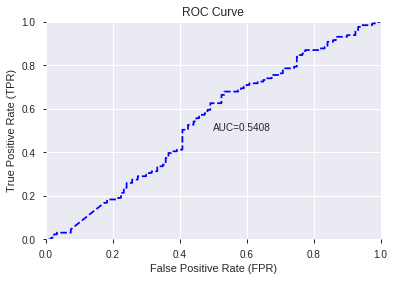

This function is available for GLM models only


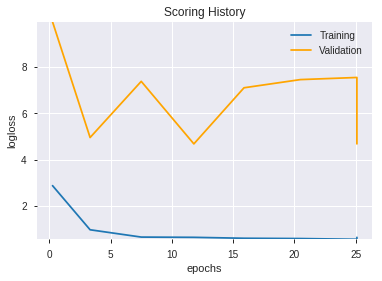

--2019-09-03 02:28:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.8MB/s    in 23s     

2019-09-03 02:28:47 (15.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_020149_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_020149_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_022901_model_5  0.507570  0.696150              0.491667  0.501489  0.251491
1  DeepLearning_grid_1_AutoML_20190903_022901_model_2  0.502481  1.056909              0.500000  0.591425  0.349783
2  DeepLearning_grid_1_AutoML_20190903_022901_model_9  0.500859  0.692285              0.500000  0.499569  0.249569
3  DeepLearning_grid_1_AutoML_20190903_022901_model_1  0.499173  1.071192              0.483333  0.596092  0.355326
4  DeepLearning_grid_1_AutoML_20190903_022901_model_7  0.496947  1.056350              0.487500  0.599867  0.359840
5  DeepLearning_grid_1_AutoML_20190903_022901_model_6  0.480789  0.696912              0.500000  0.501857  0.251861
6               DeepLearning_1_AutoML_20190903_022901  0.480662  0.970671              0.500000  0.588136  0.345904
7  DeepLearning_grid_1_AutoML_20190903_022901_model_8  0.466603  0.692716              0.495833  0.499784  0.249784
8  DeepLearning_grid_1_AutoML_20190903_022901_model_3  0.458779  1.788321              0.500000  0.688248  0.473685
9  DeepLearning_grid_1_AutoML_20190903_022901_model_4  0.429771  0.894486              0.500000  0.571631  0.326763

variable  relative_importance  scaled_importance  percentage
0                        OBV             1.000000           1.000000    0.031250
1                      DX_12             0.918189           0.918189    0.028694
2                        day             0.856080           0.856080    0.026753
3                  dayofweek             0.847632           0.847632    0.026489
4                     ADXR_8             0.835814           0.835814    0.026119
5                    weekday             0.820132           0.820132    0.025629
6                 aroonup_30             0.809763           0.809763    0.025305
7                        BOP             0.809519           0.809519    0.025298
8               STOCHF_fastk             0.795299           0.795299    0.024853
9                aroondown_8             0.770824           0.770824    0.024089
10              HT_TRENDMODE             0.752554           0.752554    0.023518
11                aroonup_24             0.745871           0.745871    0.023309
12                       DIV             0.740053           0.740053    0.023127
13               HT_DCPERIOD             0.736952           0.736952    0.023030
14         LINEARREG_ANGLE_8             0.731725           0.731725    0.022867
15              weekday_name             0.731265           0.731265    0.022852
16                    BETA_8             0.719846           0.719846    0.022495
17                  STDDEV_8             0.718581           0.718581    0.022456
18                aroonup_20             0.689180           0.689180    0.021537
19                   quarter             0.688395           0.688395    0.021513
20                     month             0.685977           0.685977    0.021437
21                   WILLR_8             0.685798           0.685798    0.021431
22                   BETA_24             0.672265           0.672265    0.021009
23                   BETA_14             0.668718           0.668718    0.020898
24             days_in_month             0.661650           0.661650    0.020677
25         MACDFIX_signal_24             0.639573           0.639573    0.019987
26                     VAR_8             0.618214           0.618214    0.019319
27        CDLCLOSINGMARUBOZU             0.590977           0.590977    0.018468
28            CDLRICKSHAWMAN             0.572708           0.572708    0.017897
29         CDLLONGLEGGEDDOJI             0.572402           0.572402    0.017888
30                   MACDEXT             0.568834           0.568834    0.017776
31                   CDLDOJI             0.560035           0.560035    0.017501
32                    ROC_14             0.552030           0.552030    0.017251
33                ROCR100_14             0.538357           0.538357    0.016824
34   BBANDS_lowerband_30_0_5             0.537207           0.537207    0.016788
35                  SAR_0.24             0.530494           0.530494    0.016578
36   BBANDS_lowerband_12_6_5             0.529128           0.529128    0.016535
37                MIDPRICE_8             0.525396           0.525396    0.016419
38  BBANDS_middleband_20_0_3             0.520776           0.520776    0.016274
39   BBANDS_upperband_12_2_3             0.509401           0.509401    0.015919
40   BBANDS_upperband_24_5_5             0.505567           0.505567    0.015799
41  BBANDS_middleband_12_0_5             0.501153           0.501153    0.015661
42    BBANDS_upperband_8_3_5             0.489990           0.489990    0.015312
43    BBANDS_lowerband_8_5_4             0.489114           0.489114    0.015285
44   BBANDS_upperband_30_0_5             0.486999           0.486999    0.015219
45   BBANDS_upperband_30_2_5             0.451483           0.451483    0.014109
46            is_quarter_end             0.422775           0.422775    0.013212
47        CDLSEPARATINGLINES             0.413164           0.413164    0.012912
48            CDLMORNINGSTAR             0.411024  

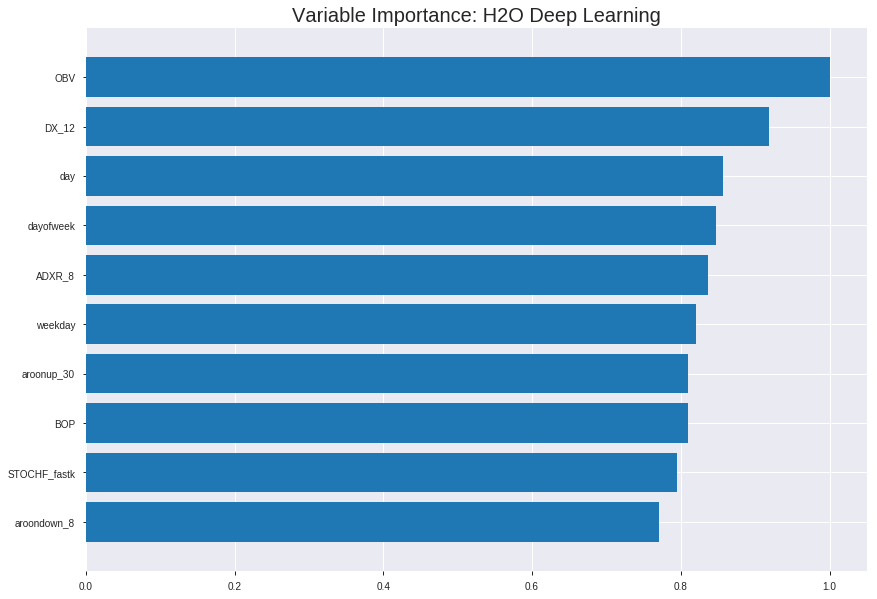

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_022901_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21336569059765478
RMSE: 0.4619152417897192
LogLoss: 0.6116925792623896
Mean Per-Class Error: 0.35170916268694274
AUC: 0.714415531418633
pr_auc: 0.7394284947789644
Gini: 0.428831062837266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4686277668316673: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      267  564   0.6787   (564.0/831.0)
1      59   864   0.0639   (59.0/923.0)
Total  326  1428  0.3552   (623.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468628     0.735006  266
max f2                       0.329532     0.860487  336
max f0point5                 0.506644     0.664668  239
max accuracy                 0.506644     0.659635  239
max precision                0.977136     1         0
max recall                   0.167274     1         379
max specificity              0.977136     1         0
max absolute_mcc             0.504879     0.333101  241
max min_per_class_accuracy   0.543261     0.593261  202
max mean_per_class_accuracy  0.506644     0.648291  239

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 54.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.92029            1.90033   1.90033            1                0.945799  1                           0.945799            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.877722           1.90033   1.90033            1                0.901869  1                           0.923834            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.84122            1.90033   1.90033            1                0.861715  1                           0.903909            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.810642           1.90033   1.90033            1                0.825861  1                           0.884122            0.0195016       0.0769231                  90.0325   90.0325
    5        0.050171                    0.784678           1.78854   1.87873            0.941176         0.796628  0.988636                    0.86722             0.0173348       0.0942579                  78.8541   87.873
    6        0.100342                    0.714175           1.51162   1.69518            0.795455         0.746452  0.892045                    0.806836            0.0758397       0.170098                   51.1622   69.5176
    7        0.149943                    0.672735           1.39794   1.59685            0.735632         0.692948  0.840304                    0.769162            0.0693391       0.239437                   39.794    59.6851
    8        0.200114                    0.634184           1.31727   1.52676            0.693182         0.653016  0.803419                    0.740043            0.0660888       0.305525                   31.7271   52.6757
    9        0.299886                    0.578388           1.09676   1.3837             0.577143         0.602427  0.728137                    0.694258            0.109426        0.414951                   9.6759    38.3697
    10       0.400228                    0.55014            1.00415   1.28854            0.528409         0.563027  0.678063                    0.661357            0.100758        0.51571                    0.414902  28.8539
    11       0.54333                     0.543255           1.06751   1.23033            0.561753         0.544046  0.647429                    0.630459            0.152763        0.668472                   6.75133   23.0326
    12       0.599772                    0.536849           1.11332   1.21932            0.585859         0.540271  0.641635                    0.621972            0.0628386       0.731311                   11.3322   21.9315
    13       0.700114                    0.51417            1.04734   1.19467            0.551136         0.526379  0.628664                    0.608271            0.105092        0.836403                   4.73382   19.4667
    14       0.799886                    0.477884           0.857861  1.15266            0.451429         0.497325  0.606557                    0.594433            0.0855905       0.921993                   -14.2139  15.2656
    15       0.899658                    0.396152           0.564668  1.08745            0.297143         0.440908  0.572243                    0.577407            0.056338        0.978332                   -43.5332  8.74484
    16       1                           0.0168456          0.215946  1                  0.113636         0.275055  0.526226                    0.547068          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2566546579971585
RMSE: 0.5066109532937069
LogLoss: 0.7100207389695615
Mean Per-Class Error: 0.48208303564340715
AUC: 0.48443280146066525
pr_auc: 0.49965629978158216
Gini: -0.031134397078669496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04525314829858094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0452531    0.673712   399
max f2                       0.0452531    0.837714   399
max f0point5                 0.418815     0.564396   339
max accuracy                 0.453262     0.521912   281
max precision                0.735274     1          0
max recall                   0.0452531    1          399
max specificity              0.735274     1          0
max absolute_mcc             0.496303     0.0792777  165
max min_per_class_accuracy   0.493644     0.465587   172
max mean_per_class_accuracy  0.453262     0.517917   281

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 48.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.610352           0.984314  0.984314           0.5              0.651839  0.5                         0.651839            0.0117647       0.0117647                  -1.56863  -1.56863
    2        0.0219124                   0.551099           1.5749    1.25276            0.8              0.571545  0.636364                    0.615342            0.0156863       0.027451                   57.4902   25.2763
    3        0.149402                    0.543255           0.830515  0.892444           0.421875         0.543419  0.453333                    0.553967            0.105882        0.133333                   -16.9485  -10.7556
    4        0.151394                    0.543149           0         0.880702           0                0.543172  0.447368                    0.553825            0               0.133333                   -100      -11.9298
    5        0.201195                    0.535177           1.49616   1.03304            0.76             0.539094  0.524752                    0.550179            0.0745098       0.207843                   49.6157   3.30421
    6        0.300797                    0.519628           0.748078  0.938683           0.38             0.527067  0.476821                    0.542526            0.0745098       0.282353                   -25.1922  -6.13167
    7        0.400398                    0.505539           0.984314  0.950034           0.5              0.512995  0.482587                    0.53518             0.0980392       0.380392                   -1.56863  -4.99659
    8        0.5                         0.493247           0.866196  0.933333           0.44             0.499995  0.474104                    0.528171            0.0862745       0.466667                   -13.3804  -6.66667
    9        0.599602                    0.477051           1.10243   0.961423           0.56             0.486154  0.488372                    0.521192            0.109804        0.576471                   10.2431   -3.85773
    10       0.699203                    0.463089           1.22055   0.998335           0.62             0.470138  0.507123                    0.513919            0.121569        0.698039                   22.0549   -0.166471
    11       0.798805                    0.444251           1.06306   1.00641            0.54             0.454024  0.511222                    0.506451            0.105882        0.803922                   6.30588   0.640555
    12       0.898406                    0.411464           1.02369   1.00832            0.52             0.428142  0.512195                    0.497769            0.101961        0.905882                   2.36863   0.832138
    13       1                           0.0452531          0.926413  1                  0.470588         0.34998   0.507968                    0.482755            0.0941176       1                          -7.35871  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:31:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:31:49  1 min  7.982 sec  1226 obs/sec      1         1             1754       0.518676         0.756006            -0.0790658     0.563342        0.591218           1.16131          0.472064                         0.612497           1.13302               -0.50099         0.535254          0.552351             1.31242            0.488048
    2019-09-03 02:31:55  1 min 14.005 sec  2278 obs/sec      9         9             15786      0.494989         0.683288            0.0172388      0.593959        0.6241             1.68918          0.462372                         0.516308           0.741355              -0.066567        0.536032          0.544917             1.31242            0.492032
    2019-09-03 02:32:01  1 min 19.300 sec  2694 obs/sec      18        18            31572      0.475909         0.640912            0.0915419      0.657723        0.687148           1.90033          0.422463                         0.511375           0.719127              -0.0462833       0.519624          0.516764             1.31242            0.492032
    2019-09-03 02:32:06  1 min 24.750 sec  2949 obs/sec      28        28            49112      0.461915         0.611693            0.144183       0.714416        0.739428           1.90033          0.355188                         0.506611           0.710021              -0.0268794       0.484433          0.499656             0.984314           0.492032
    2019-09-03 02:32:11  1 min 30.056 sec  3108 obs/sec      38        38            66652      0.45414          0.590695            0.172753       0.745852        0.776854           1.90033          0.352338                         0.510408           0.720328              -0.0423314       0.522886          0.52948              1.31242            0.492032
    2019-09-03 02:32:16  1 min 35.269 sec  3221 obs/sec      48        48            84192      0.435216         0.549824            0.240258       0.791531        0.809057           1.90033          0.315279                         0.511061           0.729538              -0.0449983       0.548091          0.548807             1.31242            0.492032
    2019-09-03 02:32:22  1 min 40.906 sec  3310 obs/sec      59        59            103486     0.417441         0.51368             0.301051       0.84032         0.854269           1.90033          0.258837                         0.513087           0.735394              -0.0533005       0.534222          0.542934             1.31242            0.49004
    2019-09-03 02:32:23  1 min 41.450 sec  3307 obs/sec      59        59            103486     0.461915         0.611693            0.144183       0.714416        0.739428           1.90033          0.355188                         0.506611           0.710021              -0.0268794       0.484433          0.499656             0.984314           0.492032

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
OBV                      1.0                    1.0                  0.031250359873007824
DX_12                    0.9181888699531555     0.9181888699531555   0.02869373261742649
day                      0.8560804128646851     0.8560804128646851   0.026752820982254524
dayofweek                0.847632110118866      0.847632110118866    0.026488808481131557
ADXR_8                   0.8358138203620911     0.8358138203620911   0.02611948267314886
---                      ---                    ---                  ---
BBANDS_upperband_30_2_5  0.4514828026294708     0.4514828026294708   0.014109000058645127
is_quarter_end           0.4227747917175293     0.4227747917175293   0.013211864386408718
CDLSEPARATINGLINES       0.4131636321544647     0.4131636321544647   0.01291151219126605
CDLMORNINGSTAR           0.4110240340232849     0.4110240340232849   0.012844648979683066
CDLINNECK                0.3707483410835266     0.3707483410835266   0.011586019081180858


See the whole table with table.as_data_frame()


('accuracy', 0.5338645418326693)

('F1', 0.6894736842105263)

('auc', 0.5075699745547074)

('logloss', 0.6961502825206777)

('mean_per_class_error', 0.4686068702290076)

('rmse', 0.5014890510419573)

('mse', 0.2514912683149628)

deeplearning prediction progress: |███████████████████████████████████████| 100%


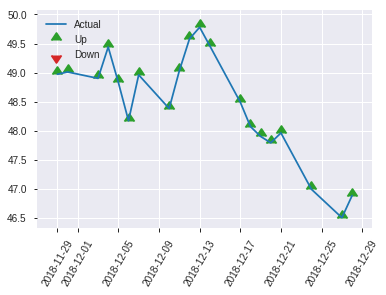


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2514912683149628
RMSE: 0.5014890510419573
LogLoss: 0.6961502825206777
Mean Per-Class Error: 0.4686068702290076
AUC: 0.5075699745547074
pr_auc: 0.5135796154711637
Gini: 0.015139949109414852
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3839982836668539: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    131  0        (0.0/131.0)
Total  2    249  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.383998     0.689474   229
max f2                       0.383998     0.847348   229
max f0point5                 0.383998     0.581189   229
max accuracy                 0.482301     0.533865   120
max precision                0.487389     0.550388   109
max recall                   0.383998     1          229
max specificity              0.54936      0.991667   0
max absolute_mcc             0.383998     0.0936398  229
max min_per_class_accuracy   0.488994     0.519084   104
max mean_per_class_accuracy  0.482301     0.531393   120

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.543312           0.638677  0.638677           0.333333         0.546793  0.333333                    0.546793            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0916335                   0.543255           0.958015  0.916362           0.5              0.543255  0.478261                    0.543716            0.0763359       0.0839695                  -4.19847   -8.36376
    3        0.103586                    0.540473           0         0.810628           0                0.541451  0.423077                    0.543455            0               0.0839695                  -100       -18.9372
    4        0.151394                    0.533108           1.27735   0.958015           0.666667         0.537021  0.5                         0.541423            0.0610687       0.145038                   27.7354    -4.19847
    5        0.203187                    0.52814            1.03171   0.9768             0.538462         0.530589  0.509804                    0.538662            0.0534351       0.198473                   3.17087    -2.32001
    6        0.302789                    0.514759           1.07298   1.00844            0.56             0.521447  0.526316                    0.532999            0.10687         0.305344                   7.29771    0.843712
    7        0.40239                     0.49912            1.14962   1.04338            0.6              0.507589  0.544554                    0.526709            0.114504        0.419847                   14.9618    4.3383
    8        0.501992                    0.488506           0.996336  1.03405            0.52             0.493334  0.539683                    0.520087            0.0992366       0.519084                   -0.366412  3.40482
    9        0.601594                    0.474268           0.919695  1.01512            0.48             0.48223   0.529801                    0.51382             0.0916031       0.610687                   -8.03053   1.51155
    10       0.701195                    0.467041           0.843053  0.990675           0.44             0.470804  0.517045                    0.507709            0.0839695       0.694656                   -15.6947   -0.932512
    11       0.800797                    0.454103           1.14962   1.01044            0.6              0.460762  0.527363                    0.50187             0.114504        0.80916                    14.9618    1.0444
    12       0.900398                    0.435215           0.919695  1.00041            0.48             0.444112  0.522124                    0.495481            0.0916031       0.900763                   -8.03053   0.0405323
    13       1                           0.381088           0.996336  1                  0.52             0.415432  0.521912                    0.487508            0.0992366       1                          -0.366412  0

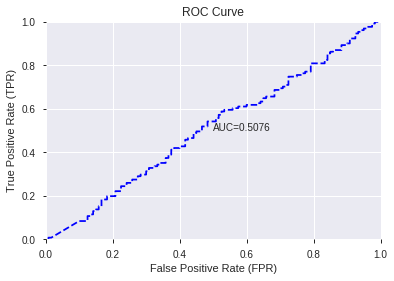

This function is available for GLM models only


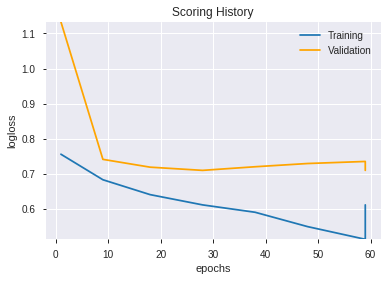

--2019-09-03 02:36:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_022901_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_022901_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'DX_12',
 'day',
 'dayofweek',
 'ADXR_8',
 'weekday',
 'aroonup_30',
 'BOP',
 'STOCHF_fastk',
 'aroondown_8',
 'HT_TRENDMODE',
 'aroonup_24',
 'DIV',
 'HT_DCPERIOD',
 'LINEARREG_ANGLE_8',
 'weekday_name',
 'BETA_8',
 'STDDEV_8',
 'aroonup_20',
 'quarter',
 'month',
 'WILLR_8',
 'BETA_24',
 'BETA_14',
 'days_in_month',
 'MACDFIX_signal_24',
 'VAR_8',
 'CDLCLOSINGMARUBOZU',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'MACDEXT',
 'CDLDOJI',
 'ROC_14',
 'ROCR100_14',
 'BBANDS_lowerband_30_0_5',
 'SAR_0.24',
 'BBANDS_lowerband_12_6_5',
 'MIDPRICE_8',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_12_2_3',
 'BBANDS_upperband_24_5_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_30_0_5',
 'BBANDS_upperband_30_2_5',
 'is_quarter_end',
 'CDLSEPARATINGLINES',
 'CDLMORNINGSTAR',
 'CDLINNECK']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023633_model_1  0.497201  0.692899                0.4868  0.499876  0.249876

variable  relative_importance  scaled_importance  percentage
0                 aroonup_30             0.007966           1.000000    0.055775
1                 aroonup_20             0.007306           0.917187    0.051156
2                 aroonup_24             0.006306           0.791635    0.044153
3                        OBV             0.006145           0.771456    0.043028
4                        day             0.005631           0.706887    0.039427
5               weekday_name             0.005505           0.691059    0.038544
6                    MACDEXT             0.004957           0.622282    0.034708
7                     ROC_14             0.004631           0.581388    0.032427
8                 ROCR100_14             0.004629           0.581134    0.032413
9                        BOP             0.004467           0.560703    0.031273
10                     DX_12             0.004443           0.557785    0.031110
11               HT_DCPERIOD             0.004095           0.514097    0.028674
12        CDLSEPARATINGLINES             0.003410           0.428061    0.023875
13                       DIV             0.003222           0.404501    0.022561
14                   BETA_24             0.003182           0.399427    0.022278
15         MACDFIX_signal_24             0.003176           0.398659    0.022235
16            CDLMORNINGSTAR             0.003078           0.386401    0.021552
17              HT_TRENDMODE             0.003053           0.383262    0.021376
18                 CDLINNECK             0.002796           0.351011    0.019578
19                  SAR_0.24             0.002765           0.347051    0.019357
20                MIDPRICE_8             0.002710           0.340143    0.018971
21    BBANDS_upperband_8_3_5             0.002699           0.338803    0.018897
22    BBANDS_lowerband_8_5_4             0.002611           0.327782    0.018282
23  BBANDS_middleband_12_0_5             0.002593           0.325473    0.018153
24   BBANDS_upperband_12_2_3             0.002551           0.320206    0.017859
25                 dayofweek             0.002486           0.312066    0.017406
26                   weekday             0.002484           0.311787    0.017390
27                   WILLR_8             0.002480           0.311275    0.017361
28                    ADXR_8             0.002475           0.310646    0.017326
29   BBANDS_lowerband_12_6_5             0.002447           0.307132    0.017130
30                     month             0.002407           0.302112    0.016850
31   BBANDS_lowerband_30_0_5             0.002321           0.291366    0.016251
32  BBANDS_middleband_20_0_3             0.002280           0.286164    0.015961
33            is_quarter_end             0.002262           0.283981    0.015839
34              STOCHF_fastk             0.002152           0.270177    0.015069
35                   quarter             0.002089           0.262303    0.014630
36   BBANDS_upperband_30_2_5             0.002079           0.261007    0.014558
37   BBANDS_upperband_30_0_5             0.001981           0.248630    0.013867
38   BBANDS_upperband_24_5_5             0.001925           0.241654    0.013478
39                  STDDEV_8             0.001378           0.173008    0.009650
40               aroondown_8             0.001217           0.152757    0.008520
41             days_in_month             0.001024           0.128517    0.007168
42        CDLCLOSINGMARUBOZU             0.000971           0.121837    0.006795
43            CDLRICKSHAWMAN             0.000900           0.113019    0.006304
44                    BETA_8             0.000615           0.077206    0.004306
45         LINEARREG_ANGLE_8             0.000487           0.061177    0.003412
46                     VAR_8             0.000280           0.035097    0.001958
47                   CDLDOJI             0.000076           0.009514    0.000531
48         CDLLONGLEGGEDDOJI             0.000075  

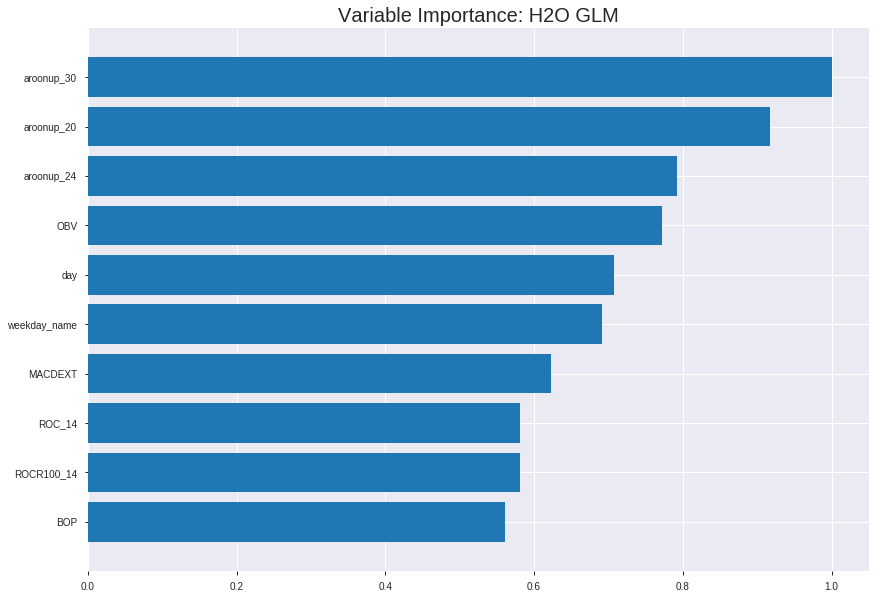

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023633_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24814949378941561
RMSE: 0.4981460566835952
LogLoss: 0.689437562738731
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2426.732552703876
Residual deviance: 2418.5469700874683
AIC: 2520.5469700874683
AUC: 0.567996239959427
pr_auc: 0.5874704021460827
Gini: 0.1359924799188541
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4927111014361818: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      14   817   0.9832   (817.0/831.0)
1      6    917   0.0065   (6.0/923.0)
Total  20   1734  0.4692   (823.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492711     0.690252  387
max f2                       0.48652      0.847567  398
max f0point5                 0.521693     0.587131  237
max accuracy                 0.521975     0.557013  235
max precision                0.558797     1         0
max recall                   0.48652      1         398
max specificity              0.558797     1         0
max absolute_mcc             0.534112     0.121679  119
max min_per_class_accuracy   0.527517     0.547129  182
max mean_per_class_accuracy  0.531049     0.555795  149

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.548969           1.37246   1.37246            0.722222         0.552542  0.722222                    0.552542            0.0140845       0.0140845                  37.2457   37.2457
    2        0.0205245                   0.54672            1.16131   1.26688            0.611111         0.547616  0.666667                    0.550079            0.0119177       0.0260022                  16.131    26.6883
    3        0.0302166                   0.54526            0.782487  1.11151            0.411765         0.545792  0.584906                    0.548704            0.00758397      0.0335861                  -21.7513  11.1511
    4        0.0404789                   0.544254           1.26688   1.1509             0.666667         0.544824  0.605634                    0.54772             0.0130011       0.0465872                  26.6883   15.0901
    5        0.050171                    0.543211           1.11784   1.14451            0.588235         0.543662  0.602273                    0.546936            0.0108342       0.0574215                  11.7838   14.4514
    6        0.100342                    0.540706           1.29568   1.2201             0.681818         0.541769  0.642045                    0.544353            0.0650054       0.122427                   29.5676   22.0095
    7        0.149943                    0.538401           1.2232    1.22112            0.643678         0.539564  0.642586                    0.542768            0.0606717       0.183099                   22.3198   22.1121
    8        0.200114                    0.536603           1.12292   1.1965             0.590909         0.537448  0.62963                     0.541435            0.056338        0.239437                   12.2919   19.6501
    9        0.299886                    0.533615           1.11848   1.17054            0.588571         0.534994  0.61597                     0.539292            0.111593        0.351029                   11.8477   17.0542
    10       0.400228                    0.530663           0.982554  1.12341            0.517045         0.532007  0.591168                    0.537465            0.0985915       0.449621                   -1.74456  12.3412
    11       0.5                         0.527529           0.955592  1.08992            0.502857         0.529125  0.573546                    0.535801            0.0953413       0.544962                   -4.4408   8.99242
    12       0.599772                    0.524547           0.966451  1.06938            0.508571         0.526027  0.562738                    0.534175            0.0964247       0.641387                   -3.3549   6.93844
    13       0.700114                    0.520578           0.982554  1.05694            0.517045         0.522476  0.556189                    0.532498            0.0985915       0.739978                   -1.74456  5.69397
    14       0.799886                    0.516555           0.857861  1.03211            0.451429         0.518617  0.543122                    0.530767            0.0855905       0.825569                   -14.2139  3.21081
    15       0.899658                    0.510601           0.847002  1.01158            0.445714         0.514062  0.532319                    0.528914            0.084507        0.910076                   -15.2998  1.15799
    16       1                           0.482234           0.896176  1                  0.471591         0.502121  0.526226                    0.526226         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24985445577627177
RMSE: 0.4998544345869823
LogLoss: 0.6928554110624756
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 696.4627613688081
Residual deviance: 695.6268327067255
AIC: 797.6268327067255
AUC: 0.5195681511470985
pr_auc: 0.52995392785236
Gini: 0.03913630229419707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47363449763712734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    243  0.9838   (243.0/247.0)
1      1    254  0.0039   (1.0/255.0)
Total  5    497  0.4861   (244.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.473634     0.675532   394
max f2                       0.472772     0.838816   397
max f0point5                 0.473634     0.566206   394
max accuracy                 0.510877     0.545817   208
max precision                0.539554     1          0
max recall                   0.472772     1          397
max specificity              0.539554     1          0
max absolute_mcc             0.534888     0.0987155  4
max min_per_class_accuracy   0.512761     0.521569   185
max mean_per_class_accuracy  0.510877     0.544939   208

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.534691           1.64052   1.64052            0.833333         0.535814  0.833333                    0.535814            0.0196078       0.0196078                  64.0523   64.0523
    2        0.0219124                   0.531788           0.787451  1.25276            0.4              0.532288  0.636364                    0.534211            0.00784314      0.027451                   -21.2549  25.2763
    3        0.0318725                   0.530714           0.787451  1.10735            0.4              0.530931  0.5625                      0.533186            0.00784314      0.0352941                  -21.2549  10.7353
    4        0.0418327                   0.529687           1.18118   1.12493            0.6              0.530041  0.571429                    0.532437            0.0117647       0.0470588                  18.1176   12.493
    5        0.0517928                   0.528753           1.5749    1.21146            0.8              0.52924   0.615385                    0.531822            0.0156863       0.0627451                  57.4902   21.1463
    6        0.101594                    0.526022           0.629961  0.926413           0.32             0.527317  0.470588                    0.529614            0.0313725       0.0941176                  -37.0039  -7.35871
    7        0.151394                    0.52416            1.10243   0.984314           0.56             0.525172  0.5                         0.528153            0.054902        0.14902                    10.2431   -1.56863
    8        0.201195                    0.522409           1.02369   0.994059           0.52             0.523083  0.50495                     0.526898            0.0509804       0.2                        2.36863   -0.594059
    9        0.300797                    0.518816           1.22055   1.06906            0.62             0.520401  0.543046                    0.524747            0.121569        0.321569                   22.0549   6.9056
    10       0.400398                    0.515738           1.1418    1.08715            0.58             0.517378  0.552239                    0.522914            0.113725        0.435294                   14.1804   8.71525
    11       0.5                         0.512732           0.866196  1.04314            0.44             0.514186  0.52988                     0.521175            0.0862745       0.521569                   -13.3804  4.31373
    12       0.599602                    0.508948           1.10243   1.05299            0.56             0.510939  0.534884                    0.519475            0.109804        0.631373                   10.2431   5.29868
    13       0.699203                    0.505236           0.787451  1.01516            0.4              0.507178  0.51567                     0.517723            0.0784314       0.709804                   -21.2549  1.51612
    14       0.798805                    0.500002           0.748078  0.981859           0.38             0.503193  0.498753                    0.515911            0.0745098       0.784314                   -25.1922  -1.81409
    15       0.898406                    0.489429           1.25992   1.01269            0.64             0.494687  0.514412                    0.513558            0.12549         0.909804                   25.9922   1.26864
    16       1                           0.469816           0.887812  1                  0.45098          0.482567  0.507968                    0.51041       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:36:34  0.000 sec   2            3.6       51            1.37888           1.38571
    2019-09-03 02:36:34  0.040 sec   4            2.2       51            1.37714           1.38604
    2019-09-03 02:36:34  0.069 sec   6            1.4       51            1.37508           1.38686
    2019-09-03 02:36:34  0.093 sec   8            0.86      51            1.37272           1.38821
    2019-09-03 02:36:34  0.118 sec   10           0.53      51            1.37014           1.39002
    2019-09-03 02:36:34  0.141 sec   12           0.33      51            1.36746           1.39217

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6880000000000001)

('auc', 0.49720101781170484)

('logloss', 0.6928988996110449)

('mean_per_class_error', 0.4593193384223919)

('rmse', 0.49987581115553226)

('mse', 0.24987582657840132)

glm prediction progress: |████████████████████████████████████████████████| 100%


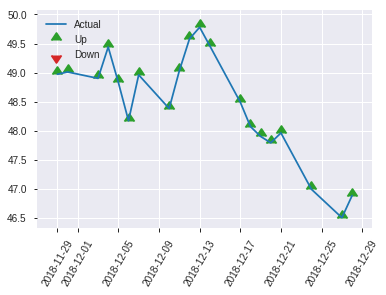


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24987582657840132
RMSE: 0.49987581115553226
LogLoss: 0.6928988996110449
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.49638460687265
Residual deviance: 347.83524760474455
AIC: 449.83524760474455
AUC: 0.49720101781170484
pr_auc: 0.5157773001470095
Gini: -0.005597964376590325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49020792821915105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    115  0.9583   (115.0/120.0)
1      2    129  0.0153   (2.0/131.0)
Total  7    244  0.4661   (117.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490208     0.688     243
max f2                       0.486776     0.845161  250
max f0point5                 0.4974       0.588235  200
max accuracy                 0.4974       0.553785  200
max precision                0.523038     0.7       9
max recall                   0.486776     1         250
max specificity              0.526163     0.991667  0
max absolute_mcc             0.4974       0.101756  200
max min_per_class_accuracy   0.507556     0.503817  124
max mean_per_class_accuracy  0.4974       0.540681  200

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 50.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.524927           0.638677  0.638677           0.333333         0.525732  0.333333                    0.525732            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0239044                   0.523939           1.27735   0.958015           0.666667         0.524184  0.5                         0.524958            0.0152672       0.0229008                  27.7354    -4.19847
    3        0.0318725                   0.523445           1.91603   1.19752            1                0.523692  0.625                       0.524642            0.0152672       0.0381679                  91.6031    19.7519
    4        0.0438247                   0.521922           1.27735   1.21929            0.666667         0.52276   0.636364                    0.524128            0.0152672       0.0534351                  27.7354    21.9292
    5        0.0517928                   0.521568           0.958015  1.1791             0.5              0.521752  0.615385                    0.523763            0.00763359      0.0610687                  -4.19847   17.9096
    6        0.103586                    0.519541           0.884322  1.03171            0.461538         0.520346  0.538462                    0.522054            0.0458015       0.10687                    -11.5678   3.17087
    7        0.151394                    0.517924           0.479008  0.857172           0.25             0.518619  0.447368                    0.520969            0.0229008       0.129771                   -52.0992   -14.2828
    8        0.203187                    0.516737           0.884322  0.864092           0.461538         0.517488  0.45098                     0.520082            0.0458015       0.175573                   -11.5678   -13.5908
    9        0.302789                    0.512409           1.07298   0.932804           0.56             0.514288  0.486842                    0.518176            0.10687         0.282443                   7.29771    -6.71957
    10       0.40239                     0.509629           1.14962   0.986471           0.6              0.511104  0.514851                    0.516426            0.114504        0.396947                   14.9618    -1.35288
    11       0.501992                    0.507524           1.07298   1.00364            0.56             0.508585  0.52381                     0.51487             0.10687         0.503817                   7.29771    0.363504
    12       0.601594                    0.504275           0.766412  0.96436            0.4              0.505694  0.503311                    0.513351            0.0763359       0.580153                   -23.3588   -3.56403
    13       0.701195                    0.500231           1.37954   1.02333            0.72             0.502091  0.534091                    0.511751            0.137405        0.717557                   37.9542    2.33345
    14       0.800797                    0.4974             1.22626   1.04857            0.64             0.498847  0.547264                    0.510146            0.122137        0.839695                   22.626     4.85739
    15       0.900398                    0.495015           0.61313   1.00041            0.32             0.496212  0.522124                    0.508605            0.0610687       0.900763                   -38.687    0.0405323
    16       1                           0.486776           0.996336  1                  0.52             0.491525  0.521912          

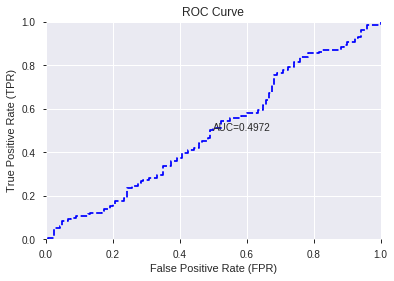

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


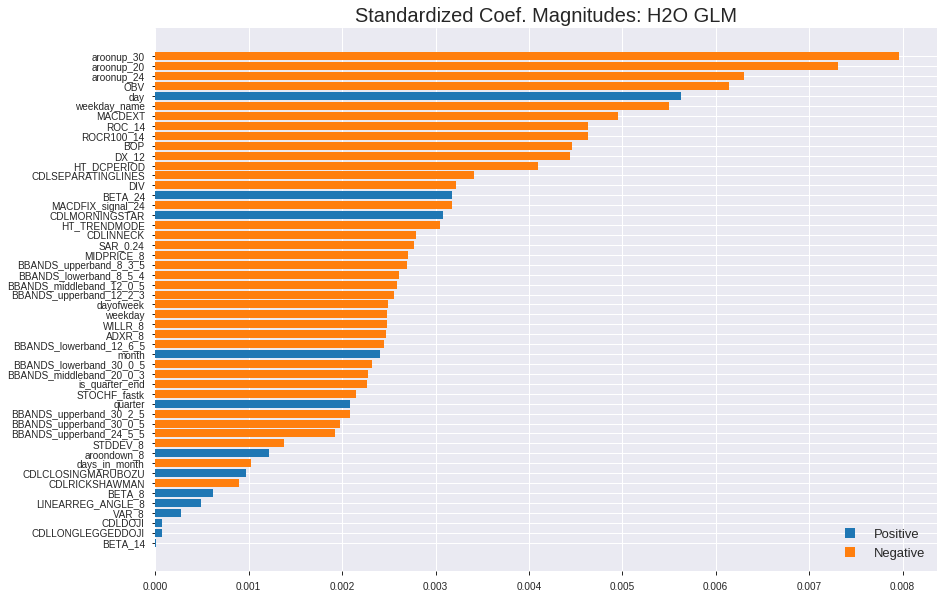

'log_likelihood'
--2019-09-03 02:36:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023633_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023633_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroonup_30',
 'aroonup_20',
 'aroonup_24',
 'OBV',
 'day',
 'weekday_name',
 'MACDEXT',
 'ROC_14',
 'ROCR100_14',
 'BOP',
 'DX_12',
 'HT_DCPERIOD',
 'CDLSEPARATINGLINES',
 'DIV',
 'BETA_24',
 'MACDFIX_signal_24',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLINNECK',
 'SAR_0.24',
 'MIDPRICE_8',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_middleband_12_0_5',
 'BBANDS_upperband_12_2_3',
 'dayofweek',
 'weekday',
 'WILLR_8',
 'ADXR_8',
 'BBANDS_lowerband_12_6_5',
 'month',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_middleband_20_0_3',
 'is_quarter_end',
 'STOCHF_fastk',
 'quarter',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_30_0_5',
 'BBANDS_upperband_24_5_5',
 'STDDEV_8',
 'aroondown_8',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'CDLRICKSHAWMAN',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'VAR_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'BETA_14']

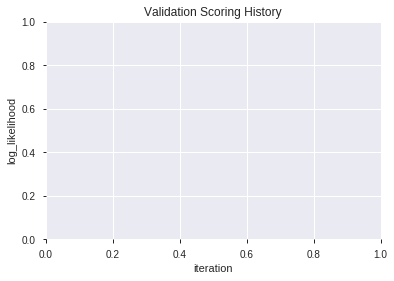

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_023650_model_6  0.555662  0.696509              0.451368  0.501642  0.251645
1  XGBoost_grid_1_AutoML_20190903_023650_model_5  0.545420  0.697760              0.470483  0.502164  0.252169
2  XGBoost_grid_1_AutoML_20190903_023650_model_4  0.534860  0.691958              0.478817  0.499372  0.249372
3  XGBoost_grid_1_AutoML_20190903_023650_model_2  0.534288  0.690268              0.466317  0.498488  0.248491
4  XGBoost_grid_1_AutoML_20190903_023650_model_3  0.533206  0.693983              0.474650  0.500342  0.250342
5               XGBoost_1_AutoML_20190903_023650  0.522074  0.697358              0.483333  0.502021  0.252025
6               XGBoost_2_AutoML_20190903_023650  0.500700  0.702430              0.491667  0.504486  0.254506
7  XGBoost_grid_1_AutoML_20190903_023650_model_1  0.493066  0.710011              0.500000  0.507965  0.258028
8  XGBoost_grid_1_AutoML_20190903_023650_model_7  0.484987  0.710860              0.461800  0.508621  0.258696
9               XGBoost_3_AutoML_20190903_023650  0.482443  0.704670              0.495833  0.505543  0.255574

variable  relative_importance  scaled_importance  percentage
0                        OBV           465.583252           1.000000    0.073554
1                        DIV           402.116333           0.863683    0.063527
2                        BOP           388.603241           0.834659    0.061393
3               STOCHF_fastk           314.528748           0.675559    0.049690
4                      DX_12           295.457428           0.634596    0.046677
5                     ROC_14           294.200928           0.631898    0.046479
6                HT_DCPERIOD           256.530182           0.550987    0.040527
7                     BETA_8           249.780823           0.536490    0.039461
8                    WILLR_8           235.874344           0.506621    0.037264
9                     ADXR_8           227.180923           0.487949    0.035891
10         MACDFIX_signal_24           201.752304           0.433332    0.031873
11         LINEARREG_ANGLE_8           190.949829           0.410130    0.030167
12                       day           190.572647           0.409320    0.030107
13                  STDDEV_8           182.273605           0.391495    0.028796
14                   BETA_14           172.634247           0.370791    0.027273
15   BBANDS_lowerband_12_6_5           167.682678           0.360156    0.026491
16                   MACDEXT           158.925934           0.341348    0.025108
17    BBANDS_lowerband_8_5_4           151.762100           0.325961    0.023976
18                   BETA_24           146.395508           0.314435    0.023128
19                aroonup_30           132.457413           0.284498    0.020926
20  BBANDS_middleband_12_0_5           122.064606           0.262176    0.019284
21                aroonup_20           108.105560           0.232194    0.017079
22                  SAR_0.24           106.827805           0.229449    0.016877
23   BBANDS_lowerband_30_0_5           102.509201           0.220174    0.016195
24    BBANDS_upperband_8_3_5            98.189072           0.210895    0.015512
25              weekday_name            93.348404           0.200498    0.014747
26   BBANDS_upperband_12_2_3            88.303703           0.189663    0.013950
27               aroondown_8            86.443878           0.185668    0.013657
28                 dayofweek            80.811066           0.173570    0.012767
29                MIDPRICE_8            74.115013           0.159187    0.011709
30                aroonup_24            69.540482           0.149362    0.010986
31   BBANDS_upperband_24_5_5            67.255211           0.144454    0.010625
32                     month            60.355293           0.129634    0.009535
33                     VAR_8            53.418091           0.114734    0.008439
34   BBANDS_upperband_30_2_5            49.873871           0.107121    0.007879
35                ROCR100_14            48.573334           0.104328    0.007674
36  BBANDS_middleband_20_0_3            42.678619           0.091667    0.006742
37                   weekday            41.761532           0.089697    0.006598
38   BBANDS_upperband_30_0_5            37.604858           0.080769    0.005941
39            CDLRICKSHAWMAN            22.734871           0.048831    0.003592
40             days_in_month            20.527586           0.044090    0.003243
41              HT_TRENDMODE            10.096026           0.021685    0.001595
42        CDLCLOSINGMARUBOZU            10.042169           0.021569    0.001586
43                   quarter             9.369585           0.020124    0.001480

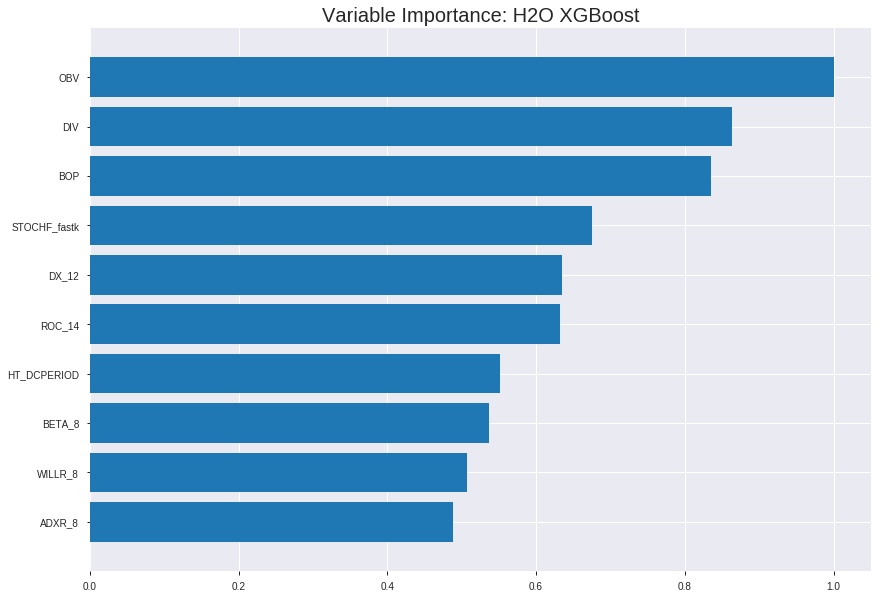

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_023650_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18738510368602865
RMSE: 0.43288001072586924
LogLoss: 0.5642479385763081
Mean Per-Class Error: 0.16267194949759656
AUC: 0.9163312746980821
pr_auc: 0.9229108837723947
Gini: 0.8326625493961641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49903554916381837: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      622  209   0.2515   (209.0/831.0)
1      92   831   0.0997   (92.0/923.0)
Total  714  1040  0.1716   (301.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499036     0.846663  221
max f2                       0.466412     0.9054    256
max f0point5                 0.534895     0.86268   182
max accuracy                 0.532631     0.835234  184
max precision                0.80845      1         0
max recall                   0.332973     1         366
max specificity              0.80845      1         0
max absolute_mcc             0.532631     0.674395  184
max min_per_class_accuracy   0.519215     0.834236  197
max mean_per_class_accuracy  0.532631     0.837328  184

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.745333           1.90033    1.90033            1                0.764996  1                           0.764996            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.728151           1.90033    1.90033            1                0.736174  1                           0.750585            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.709708           1.90033    1.90033            1                0.719244  1                           0.740532            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.698662           1.90033    1.90033            1                0.704918  1                           0.731503            0.0195016       0.0769231                  90.0325   90.0325
    5        0.050171                    0.689612           1.90033    1.90033            1                0.693581  1                           0.724177            0.0184182       0.0953413                  90.0325   90.0325
    6        0.100342                    0.660801           1.87873    1.88953            0.988636         0.67372   0.994318                    0.698949            0.0942579       0.189599                   87.873    88.9528
    7        0.149943                    0.635569           1.87848    1.88587            0.988506         0.648261  0.992395                    0.682181            0.0931744       0.282774                   87.8482   88.5874
    8        0.200114                    0.617789           1.74916    1.8516             0.920455         0.626427  0.974359                    0.668203            0.0877573       0.370531                   74.9163   85.1599
    9        0.299886                    0.581417           1.694      1.79917            0.891429         0.60116   0.946768                    0.645898            0.169014        0.539545                   69.4004   79.9167
    10       0.400228                    0.55187            1.51162    1.72708            0.795455         0.56633   0.908832                    0.625949            0.151679        0.691224                   51.1622   72.7076
    11       0.5                         0.525253           1.23793    1.62947            0.651429         0.538887  0.857469                    0.608576            0.12351         0.814735                   23.7926   62.9469
    12       0.599772                    0.496221           0.901297   1.50834            0.474286         0.510669  0.793726                    0.59229             0.0899242       0.904659                   -9.8703   50.8338
    13       0.700114                    0.466748           0.593852   1.37727            0.3125           0.482974  0.724756                    0.576622            0.0595883       0.964247                   -40.6148  37.7271
    14       0.799886                    0.429335           0.238898   1.23528            0.125714         0.446706  0.650036                    0.560417            0.0238353       0.988082                   -76.1102  23.5279
    15       0.899658                    0.385237           0.097731   1.10913            0.0514286        0.407982  0.58365                     0.543512            0.00975081      0.997833                   -90.2269  10.9125
    16       1                           0.184684           0.0215946  1                  0.0113636        0.339938  0.526226                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2537242077832663
RMSE: 0.5037104404151916
LogLoss: 0.7010322701363711
Mean Per-Class Error: 0.46522981662300544
AUC: 0.5249265698182107
pr_auc: 0.5236161490934274
Gini: 0.04985313963642146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2873692810535431: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    245  0.9919   (245.0/247.0)
1      0    255  0        (0.0/255.0)
Total  2    500  0.488    (245.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.287369     0.675497   397
max f2                       0.287369     0.838816   397
max f0point5                 0.384949     0.572891   351
max accuracy                 0.384949     0.533865   351
max precision                0.727024     1          0
max recall                   0.287369     1          397
max specificity              0.727024     1          0
max absolute_mcc             0.384949     0.0897584  351
max min_per_class_accuracy   0.497254     0.51417    192
max mean_per_class_accuracy  0.532967     0.53477    129

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.673328           1.31242   1.31242            0.666667         0.692457  0.666667                    0.692457            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.65818            0.787451  1.0738             0.4              0.665561  0.545455                    0.680231            0.00784314      0.0235294                  -21.2549  7.37968
    3        0.0318725                   0.641204           0.787451  0.984314           0.4              0.649331  0.5                         0.670575            0.00784314      0.0313725                  -21.2549  -1.56863
    4        0.0418327                   0.638194           0.787451  0.937442           0.4              0.639266  0.47619                     0.66312             0.00784314      0.0392157                  -21.2549  -6.25584
    5        0.0517928                   0.632688           0.787451  0.908597           0.4              0.634919  0.461538                    0.657697            0.00784314      0.0470588                  -21.2549  -9.14027
    6        0.101594                    0.607937           1.25992   1.08082            0.64             0.619032  0.54902                     0.638744            0.0627451       0.109804                   25.9922   8.08151
    7        0.151394                    0.584056           0.787451  0.984314           0.4              0.598095  0.5                         0.625372            0.0392157       0.14902                    -21.2549  -1.56863
    8        0.201195                    0.560152           1.25992   1.05253            0.64             0.571116  0.534653                    0.611942            0.0627451       0.211765                   25.9922   5.25335
    9        0.300797                    0.537483           1.18118   1.09513            0.6              0.547229  0.556291                    0.590514            0.117647        0.329412                   18.1176   9.51305
    10       0.400398                    0.516281           0.905569  1.04798            0.46             0.526854  0.532338                    0.574678            0.0901961       0.419608                   -9.44314  4.79758
    11       0.5                         0.497582           0.944941  1.02745            0.48             0.505357  0.521912                    0.560869            0.0941176       0.513725                   -5.50588  2.7451
    12       0.599602                    0.476635           1.06306   1.03337            0.54             0.486766  0.524917                    0.54856             0.105882        0.619608                   6.30588   3.33659
    13       0.699203                    0.452878           0.984314  1.02638            0.5              0.465903  0.521368                    0.536785            0.0980392       0.717647                   -1.56863  2.63784
    14       0.798805                    0.427024           0.944941  1.01622            0.48             0.440758  0.516209                    0.524812            0.0941176       0.811765                   -5.50588  1.62241
    15       0.898406                    0.383812           1.10243   1.02578            0.56             0.407055  0.521064                    0.511757            0.109804        0.921569                   10.2431   2.57815
    16       1                           0.252252           0.772011  1                  0.392157         0.344783  0.507968                    0.494793      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:37:03  8.704 sec   0                  0.5              0.693147            0.5             0                  1                0.473774                         0.5                0.693147              0.5               0                    1                  0.492032
    2019-09-03 02:37:03  8.851 sec   5                  0.48851          0.670379            0.775634        0.785814           1.79475          0.329532                         0.499738           0.692623              0.518187          0.522366             0.984314           0.492032
    2019-09-03 02:37:03  8.947 sec   10                 0.480834         0.655367            0.81349         0.825818           1.90033          0.296465                         0.499636           0.692408              0.518878          0.533201             1.68739            0.48008
    2019-09-03 02:37:04  9.048 sec   15                 0.471433         0.637202            0.8499          0.860681           1.90033          0.257697                         0.49932            0.691774              0.528229          0.532956             0.984314           0.488048
    2019-09-03 02:37:04  9.163 sec   20                 0.464969         0.624766            0.85916         0.868929           1.90033          0.234892                         0.499939           0.693024              0.523712          0.526851             1.31242            0.484064
    2019-09-03 02:37:04  9.315 sec   25                 0.457594         0.610719            0.87737         0.886148           1.90033          0.209236                         0.50134            0.695878              0.514519          0.515044             1.31242            0.486056
    2019-09-03 02:37:04  9.409 sec   30                 0.452132         0.60033             0.886528        0.893895           1.90033          0.198404                         0.502454           0.6982                0.512598          0.508831             0.984314           0.486056
    2019-09-03 02:37:04  9.483 sec   35                 0.44652          0.589812            0.90012         0.90608            1.90033          0.189282                         0.5025             0.698352              0.515734          0.510484             0.656209           0.484064
    2019-09-03 02:37:04  9.572 sec   40                 0.441537         0.580448            0.905365        0.910927           1.90033          0.185291                         0.50213            0.697619              0.522942          0.516875             0.984314           0.486056
    2019-09-03 02:37:04  9.662 sec   45                 0.436452         0.570956            0.913344        0.919582           1.90033          0.172748                         0.502213           0.697859              0.526975          0.520962             0.984314           0.49004
    2019-09-03 02:37:04  9.730 sec   50                 0.43288          0.564248            0.916331        0.922911           1.90033          0.171608                         0.50371            0.701032              0.524927          0.523616             1.31242            0.488048

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
OBV                 465.583251953125       1.0                   0.07355403758699283
DIV                 402.1163330078125      0.86368298541868      0.06352737077273178
BOP                 388.6032409667969      0.8346589773936317    0.061392537795532186
STOCHF_fastk        314.52874755859375     0.6755585520723597    0.0496900591313448
DX_12               295.4574279785156      0.6345963406953958    0.04667712309607725
---                 ---                    ---                   ---
CDLRICKSHAWMAN      22.73487091064453      0.04883094659284153   0.003591713281098306
days_in_month       20.527585983276367     0.04409004382602467   0.0032430007407915798
HT_TRENDMODE        10.096026420593262     0.021684685559973133  0.0015949961767403845
CDLCLOSINGMARUBOZU  10.042168617248535     0.0215690074226716    0.0015864875826813144
quarter             9.369585037231445      0.020124403096387102  0.001480231101767452


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6929577464788733)

('auc', 0.5556615776081425)

('logloss', 0.6965085567340403)

('mean_per_class_error', 0.41657124681933844)

('rmse', 0.5016419382717804)

('mse', 0.25164463423306876)

xgboost prediction progress: |████████████████████████████████████████████| 100%


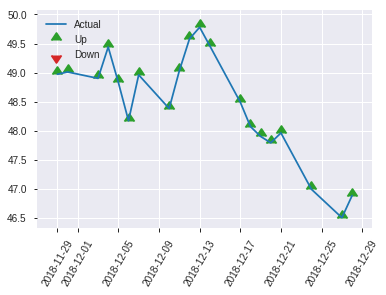


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25164463423306876
RMSE: 0.5016419382717804
LogLoss: 0.6965085567340403
Mean Per-Class Error: 0.41657124681933844
AUC: 0.5556615776081425
pr_auc: 0.5305937439149797
Gini: 0.111323155216285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3754134774208069: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   101  0.8417   (101.0/120.0)
1      8    123  0.0611   (8.0/131.0)
Total  27   224  0.4343   (109.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375413     0.692958  223
max f2                       0.314853     0.846253  249
max f0point5                 0.439068     0.609756  161
max accuracy                 0.439068     0.589641  161
max precision                0.669593     1         0
max recall                   0.314853     1         249
max specificity              0.669593     1         0
max absolute_mcc             0.439068     0.174229  161
max min_per_class_accuracy   0.468725     0.541667  125
max mean_per_class_accuracy  0.439068     0.583429  161

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 46.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.632824           0.638677  0.638677           0.333333         0.654054  0.333333                    0.654054            0.00763359      0.00763359                 -36.1323  -36.1323
    2        0.0239044                   0.615912           1.27735   0.958015           0.666667         0.622209  0.5                         0.638132            0.0152672       0.0229008                  27.7354   -4.19847
    3        0.0318725                   0.599241           0.958015  0.958015           0.5              0.604028  0.5                         0.629606            0.00763359      0.0305344                  -4.19847  -4.19847
    4        0.0438247                   0.593457           1.27735   1.04511            0.666667         0.5953    0.545455                    0.62025             0.0152672       0.0458015                  27.7354   4.51076
    5        0.0517928                   0.589639           0         0.884322           0                0.592487  0.461538                    0.615978            0               0.0458015                  -100      -11.5678
    6        0.103586                    0.561427           0.442161  0.663241           0.230769         0.57477   0.346154                    0.595374            0.0229008       0.0687023                  -55.7839  -33.6759
    7        0.151394                    0.542685           1.11768   0.80675            0.583333         0.551284  0.421053                    0.581451            0.0534351       0.122137                   11.7684   -19.325
    8        0.203187                    0.528551           1.47387   0.9768             0.769231         0.535152  0.509804                    0.569649            0.0763359       0.198473                   47.387    -2.32001
    9        0.302789                    0.507672           1.3029    1.08407            0.68             0.517154  0.565789                    0.552381            0.129771        0.328244                   30.2901   8.40699
    10       0.40239                     0.484449           1.07298   1.08132            0.56             0.496537  0.564356                    0.538558            0.10687         0.435115                   7.29771   8.13242
    11       0.501992                    0.468725           1.07298   1.07967            0.56             0.47655   0.563492                    0.526255            0.10687         0.541985                   7.29771   7.9668
    12       0.601594                    0.447728           1.22626   1.10394            0.64             0.457697  0.576159                    0.514904            0.122137        0.664122                   22.626    10.3938
    13       0.701195                    0.426537           0.919695  1.07777            0.48             0.436299  0.5625                      0.503739            0.0916031       0.755725                   -8.03053  7.77672
    14       0.800797                    0.402348           0.766412  1.03904            0.4              0.412992  0.542289                    0.492452            0.0763359       0.832061                   -23.3588  3.90414
    15       0.900398                    0.373004           1.07298   1.0428             0.56             0.388002  0.544248                    0.480898            0.10687         0.938931                   7.29771   4.27954
    16       1                           0.290725           0.61313   1                  0.32             0.349256  0.521912                    0.467786    

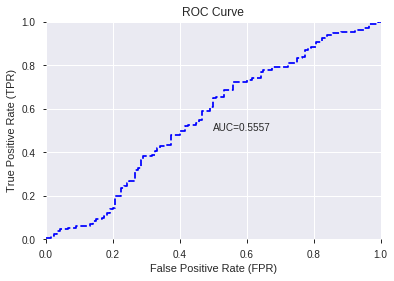

This function is available for GLM models only


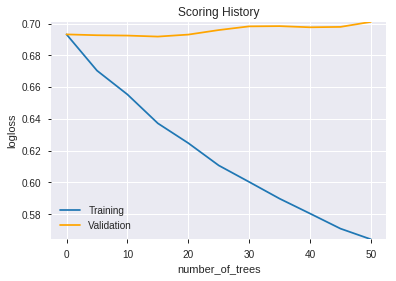

--2019-09-03 02:37:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_023650_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_023650_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'DIV',
 'BOP',
 'STOCHF_fastk',
 'DX_12',
 'ROC_14',
 'HT_DCPERIOD',
 'BETA_8',
 'WILLR_8',
 'ADXR_8',
 'MACDFIX_signal_24',
 'LINEARREG_ANGLE_8',
 'day',
 'STDDEV_8',
 'BETA_14',
 'BBANDS_lowerband_12_6_5',
 'MACDEXT',
 'BBANDS_lowerband_8_5_4',
 'BETA_24',
 'aroonup_30',
 'BBANDS_middleband_12_0_5',
 'aroonup_20',
 'SAR_0.24',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_upperband_8_3_5',
 'weekday_name',
 'BBANDS_upperband_12_2_3',
 'aroondown_8',
 'dayofweek',
 'MIDPRICE_8',
 'aroonup_24',
 'BBANDS_upperband_24_5_5',
 'month',
 'VAR_8',
 'BBANDS_upperband_30_2_5',
 'ROCR100_14',
 'BBANDS_middleband_20_0_3',
 'weekday',
 'BBANDS_upperband_30_0_5',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023725_model_1  0.545929  6.957755              0.478117  0.685527  0.469947

variable  relative_importance  scaled_importance    percentage
0                          OBV         5.543301e-03           1.000000  1.007722e-02
1                       MFI_12         5.412297e-03           0.976367  9.839067e-03
2               CDLSPINNINGTOP         5.389864e-03           0.972320  9.798285e-03
3            CDLINVERTEDHAMMER         5.249486e-03           0.946996  9.543090e-03
4                          day         5.160818e-03           0.931001  9.381900e-03
...                        ...                  ...                ...           ...
1036  BBANDS_middleband_24_7_5         4.146504e-07           0.000075  7.537969e-07
1037   BBANDS_lowerband_12_6_5         3.795144e-07           0.000068  6.899229e-07
1038                   MA_30_0         3.382784e-07           0.000061  6.149596e-07
1039                    EMA_24         3.051705e-07           0.000055  5.547724e-07
1040  BBANDS_middleband_14_7_2         1.077064e-07           0.000019  1.958005e-07

[1041 rows x 4 columns]

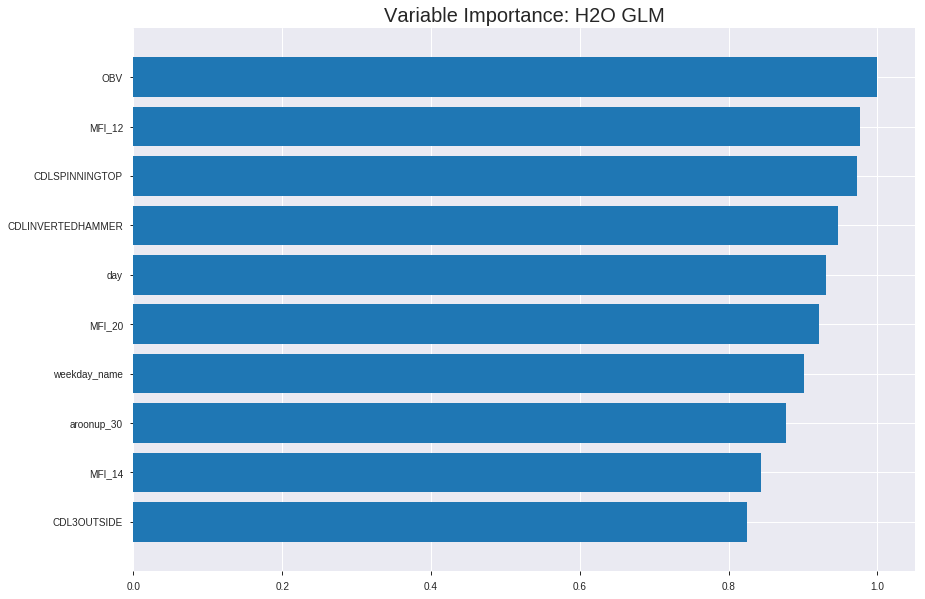

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023725_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24633367494497585
RMSE: 0.49632013352772203
LogLoss: 0.6857782038374226
Null degrees of freedom: 1753
Residual degrees of freedom: 712
Null deviance: 2426.732552703876
Residual deviance: 2405.7099390616786
AIC: 4489.709939061679
AUC: 0.5744648395789902
pr_auc: 0.590775056958388
Gini: 0.1489296791579804
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44256481076275783: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    822   0.9892   (822.0/831.0)
1      2    921   0.0022   (2.0/923.0)
Total  11   1743  0.4698   (824.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442565     0.690923  389
max f2                       0.434419     0.847722  397
max f0point5                 0.488869     0.588693  311
max accuracy                 0.5261       0.560433  195
max precision                0.62756      1         0
max recall                   0.434419     1         397
max specificity              0.62756      1         0
max absolute_mcc             0.539992     0.137912  146
max min_per_class_accuracy   0.529176     0.554753  184
max mean_per_class_accuracy  0.539453     0.566262  147

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.586543           1.16131   1.16131            0.611111         0.600803  0.611111                    0.600803            0.0119177       0.0119177                  16.131    16.131
    2        0.0205245                   0.58077            1.26688   1.2141             0.666667         0.583112  0.638889                    0.591957            0.0130011       0.0249187                  26.6883   21.4097
    3        0.0302166                   0.57598            1.34141   1.25493            0.705882         0.577891  0.660377                    0.587445            0.0130011       0.0379198                  34.1406   25.4932
    4        0.0404789                   0.573636           0.950163  1.17767            0.5              0.574851  0.619718                    0.584252            0.00975081      0.0476706                  -4.98375  17.7666
    5        0.050171                    0.571749           1.45319   1.23089            0.764706         0.572613  0.647727                    0.582004            0.0140845       0.0617551                  45.319    23.0892
    6        0.100342                    0.564023           1.27408   1.25249            0.670455         0.567627  0.659091                    0.574815            0.063922        0.125677                   27.4082   25.2487
    7        0.149943                    0.558473           1.04846   1.18499            0.551724         0.561259  0.623574                    0.570331            0.0520043       0.177681                   4.84552   18.4994
    8        0.200114                    0.552963           1.05814   1.15319            0.556818         0.555877  0.606838                    0.566707            0.0530878       0.230769                   5.81355   15.3189
    9        0.299886                    0.54475            1.21621   1.17416            0.64             0.54858   0.617871                    0.560676            0.121343        0.352113                   21.6208   17.4155
    10       0.400228                    0.536302           1.04734   1.14236            0.551136         0.540292  0.60114                     0.555566            0.105092        0.457205                   4.73382   14.2361
    11       0.5                         0.529227           0.97731   1.10943            0.514286         0.532876  0.583808                    0.551038            0.0975081       0.554713                   -2.269    10.9426
    12       0.599772                    0.521229           0.933874  1.08022            0.491429         0.525312  0.568441                    0.546759            0.0931744       0.647887                   -6.6126   8.02228
    13       0.700114                    0.510715           0.84219   1.04611            0.443182         0.516113  0.550489                    0.542366            0.084507        0.732394                   -15.781   4.61073
    14       0.799886                    0.499915           0.912156  1.0294             0.48             0.505692  0.541696                    0.537792            0.0910076       0.823402                   -8.7844   2.93992
    15       0.899658                    0.484123           0.933874  1.01881            0.491429         0.492798  0.536122                    0.532802            0.0931744       0.916576                   -6.6126   1.88054
    16       1                           0.424558           0.831392  1                  0.4375           0.467263  0.526226                    0.526226          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.35522838970223497
RMSE: 0.5960103939548663
LogLoss: 5.876865386054423
Null degrees of freedom: 501
Residual degrees of freedom: -540
Null deviance: 696.4627613688081
Residual deviance: 18667.53203499142
AIC: 20751.53203499142
AUC: 0.524791617051679
pr_auc: 0.5200001682654107
Gini: 0.049583234103357965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.8544610929230734e-28: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.85446e-28  0.673712   399
max f2                       1.85446e-28  0.837714   399
max f0point5                 1.24176e-23  0.565265   393
max accuracy                 0.506224     0.537849   116
max precision                0.547151     0.666667   5
max recall                   1.85446e-28  1          399
max specificity              0.555434     0.995951   0
max absolute_mcc             0.506224     0.0995964  116
max min_per_class_accuracy   0.470088     0.509804   250
max mean_per_class_accuracy  0.506224     0.542113   116

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 28.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.547145           1.31242   1.31242            0.666667         0.550642     0.666667                    0.550642            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.544871           0.393725  0.894831           0.2              0.545536     0.454545                    0.548321            0.00392157      0.0196078                  -60.6275  -10.5169
    3        0.0318725                   0.540557           0.393725  0.738235           0.2              0.542203     0.375                       0.546409            0.00392157      0.0235294                  -60.6275  -26.1765
    4        0.0418327                   0.538163           1.18118   0.843697           0.6              0.539062     0.428571                    0.54466             0.0117647       0.0352941                  18.1176   -15.6303
    5        0.0517928                   0.536402           0.393725  0.757164           0.2              0.537098     0.384615                    0.543206            0.00392157      0.0392157                  -60.6275  -24.2836
    6        0.101594                    0.523488           1.25992   1.00361            0.64             0.529177     0.509804                    0.536329            0.0627451       0.101961                   25.9922   0.361399
    7        0.151394                    0.51387            1.33867   1.11383            0.68             0.518358     0.565789                    0.530418            0.0666667       0.168627                   33.8667   11.3829
    8        0.201195                    0.509578           1.10243   1.11101            0.56             0.511671     0.564356                    0.525777            0.054902        0.223529                   10.2431   11.1008
    9        0.300797                    0.501393           1.06306   1.09513            0.54             0.505101     0.556291                    0.518931            0.105882        0.329412                   6.30588   9.51305
    10       0.400398                    0.486095           0.866196  1.03818            0.44             0.494534     0.527363                    0.512862            0.0862745       0.415686                   -13.3804  3.81816
    11       0.5                         0.469884           0.944941  1.01961            0.48             0.478751     0.517928                    0.506067            0.0941176       0.509804                   -5.50588  1.96078
    12       0.599602                    0.022469           1.02369   1.02029            0.52             0.346876     0.518272                    0.479623            0.101961        0.611765                   2.36863   2.02853
    13       0.699203                    1.70382e-10        1.10243   1.03199            0.56             0.00388032   0.524217                    0.411854            0.109804        0.721569                   10.2431   3.1987
    14       0.798805                    1.69836e-26        0.984314  1.02604            0.5              1.61761e-11  0.521197                    0.3605              0.0980392       0.819608                   -1.56863  2.60427
    15       0.898406                    2.28203e-52        0.944941  1.01705            0.48             3.74601e-28  0.51663                     0.320533            0.0941176       0.913725                   -5.50588  1.70514
    16       1                           0                  0.849212  1                  0.431373         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:37:29  0.000 sec   2            3.9       1042          1.37156           37.1863
    2019-09-03 02:37:31  2.148 sec   4            2.8       1042          1.36925           47.2326
    2019-09-03 02:37:33  4.343 sec   6            2         1042          1.3665            60.4256
    2019-09-03 02:37:36  6.521 sec   8            1.5       1042          1.36327           77.5937
    2019-09-03 02:37:38  8.689 sec   10           1.1       1042          1.35962           99.6663

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6900269541778976)

('auc', 0.5459287531806616)

('logloss', 6.957755029743077)

('mean_per_class_error', 0.4276717557251908)

('rmse', 0.6855267468372841)

('mse', 0.46994692062930987)

glm prediction progress: |████████████████████████████████████████████████| 100%


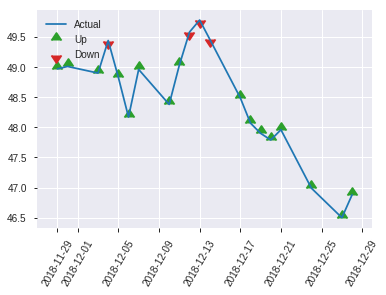


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.46994692062930987
RMSE: 0.6855267468372841
LogLoss: 6.957755029743077
Null degrees of freedom: 250
Residual degrees of freedom: -791
Null deviance: 347.49638460687265
Residual deviance: 4810.502501220276
AIC: 6894.502501220276
AUC: 0.5459287531806616
pr_auc: 0.5391976655172277
Gini: 0.09185750636132317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2375378895972292e-38: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      3    128  0.0229   (3.0/131.0)
Total  11   240  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.23754e-38  0.690027  239
max f2                       8.92574e-49  0.845161  246
max f0point5                 3.13196e-07  0.599473  156
max accuracy                 3.13196e-07  0.577689  156
max precision                0.516245     1         0
max recall                   8.92574e-49  1         246
max specificity              0.516245     1         0
max absolute_mcc             3.13196e-07  0.149297  156
max min_per_class_accuracy   4.12003e-05  0.533333  125
max mean_per_class_accuracy  3.13196e-07  0.572328  156

Gains/Lift Table: Avg response rate: 52.19 %, avg score:  8.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.504014           0.638677  0.638677           0.333333         0.510731     0.333333                    0.510731            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0239044                   0.493686           1.91603   1.27735            1                0.497438     0.666667                    0.504084            0.0229008       0.0305344                  91.6031    27.7354
    3        0.0318725                   0.484516           0         0.958015           0                0.485317     0.5                         0.499393            0               0.0305344                  -100       -4.19847
    4        0.0438247                   0.483563           0.638677  0.870923           0.333333         0.483849     0.454545                    0.495153            0.00763359      0.0381679                  -36.1323   -12.9077
    5        0.0517928                   0.470971           0.958015  0.884322           0.5              0.477013     0.461538                    0.492363            0.00763359      0.0458015                  -4.19847   -11.5678
    6        0.103586                    0.433981           1.32648   1.1054             0.692308         0.452396     0.576923                    0.472379            0.0687023       0.114504                   32.6483    10.5402
    7        0.151394                    0.228144           0.479008  0.907593           0.25             0.366031     0.473684                    0.438796            0.0229008       0.137405                   -52.0992   -9.24066
    8        0.203187                    0.116428           1.32648   1.01437            0.692308         0.160527     0.529412                    0.367864            0.0687023       0.206107                   32.6483    1.43691
    9        0.302789                    0.0235286          1.07298   1.03365            0.56             0.0566845    0.539474                    0.265503            0.10687         0.312977                   7.29771    3.36481
    10       0.40239                     0.00161507         0.996336  1.02441            0.52             0.00597916   0.534653                    0.201264            0.0992366       0.412214                   -0.366412  2.44124
    11       0.501992                    4.12003e-05        1.22626   1.06446            0.64             0.000360679  0.555556                    0.161402            0.122137        0.534351                   22.626     6.44614
    12       0.601594                    6.37856e-07        1.22626   1.09125            0.64             1.26913e-05  0.569536                    0.134682            0.122137        0.656489                   22.626     9.12492
    13       0.701195                    2.11169e-09        0.996336  1.07777            0.52             1.52338e-07  0.5625                      0.115551            0.0992366       0.755725                   -0.366412  7.77672
    14       0.800797                    7.49414e-17        0.843053  1.04857            0.44             3.91269e-10  0.547264                    0.101179            0.0839695       0.839695                   -15.6947   4.85739
    15       0.900398                    7.97534e-28        0.919695  1.03432            0.48             3.56361e-18  0.539823                    0.0899868           0.0916031       0.931298                   -8.03053   3.43174
    16       1                           3.83013e-54        0.689771  1                 

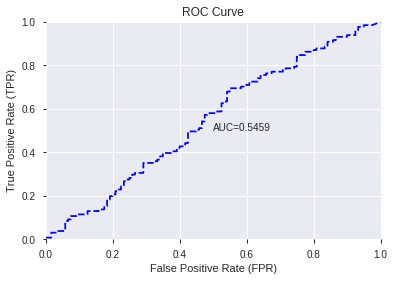

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


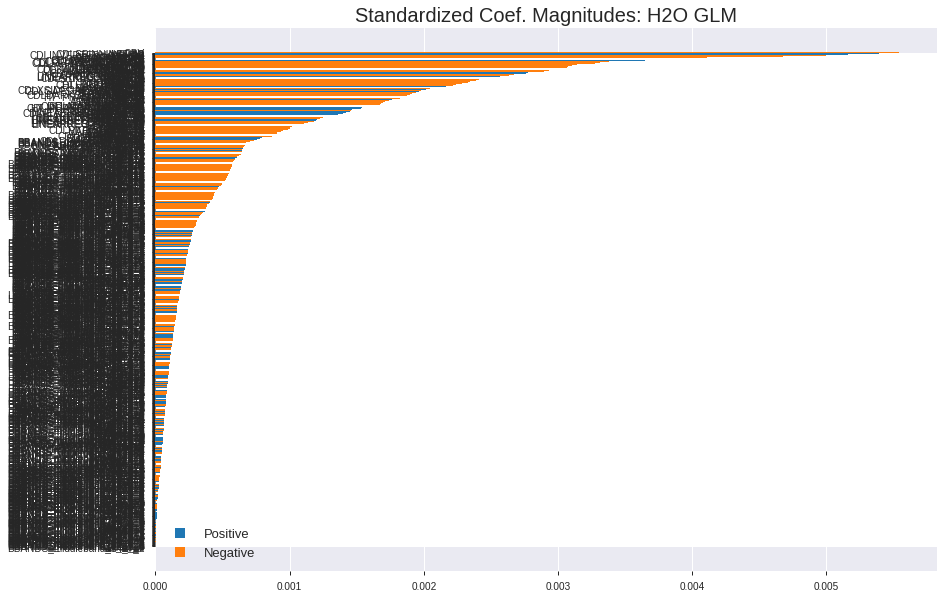

'log_likelihood'
--2019-09-03 02:38:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023725_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023725_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

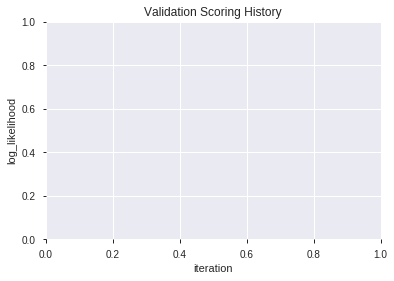

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_023820_model_4  0.562341  0.685760              0.469784  0.496343  0.246357
1  XGBoost_grid_1_AutoML_20190903_023820_model_6  0.554008  0.706528              0.495833  0.506390  0.256430
2               XGBoost_2_AutoML_20190903_023820  0.547710  0.701857              0.491667  0.504043  0.254059
3               XGBoost_3_AutoML_20190903_023820  0.547265  0.697661              0.495483  0.501991  0.251995
4               XGBoost_1_AutoML_20190903_023820  0.545547  0.707394              0.495833  0.506752  0.256798
5  XGBoost_grid_1_AutoML_20190903_023820_model_1  0.533779  0.711489              0.486450  0.508431  0.258502
6  XGBoost_grid_1_AutoML_20190903_023820_model_5  0.526081  0.746865              0.491667  0.523957  0.274531
7  XGBoost_grid_1_AutoML_20190903_023820_model_2  0.524173  0.697811              0.495833  0.502215  0.252220
8  XGBoost_grid_1_AutoML_20190903_023820_model_3  0.522964  0.732850              0.472901  0.518240  0.268573
9  XGBoost_grid_1_AutoML_20190903_023820_model_7  0.520611  0.721640              0.500000  0.513146  0.263319

variable  relative_importance  scaled_importance  percentage
0                        OBV           156.012787           1.000000    0.044699
1                        TAN           137.678604           0.882483    0.039446
2                    ADXR_14            94.335854           0.604667    0.027028
3                     MFI_12            85.245598           0.546401    0.024423
4                        day            75.978485           0.487002    0.021768
..                       ...                  ...                ...         ...
164              AROONOSC_30             5.747115           0.036837    0.001647
165  BBANDS_lowerband_14_4_2             5.592158           0.035844    0.001602
166       LINEARREG_ANGLE_14             5.532948           0.035465    0.001585
167             STOCHF_fastk             5.118376           0.032807    0.001466
168                   MOM_12             4.970442           0.031859    0.001424

[169 rows x 4 columns]

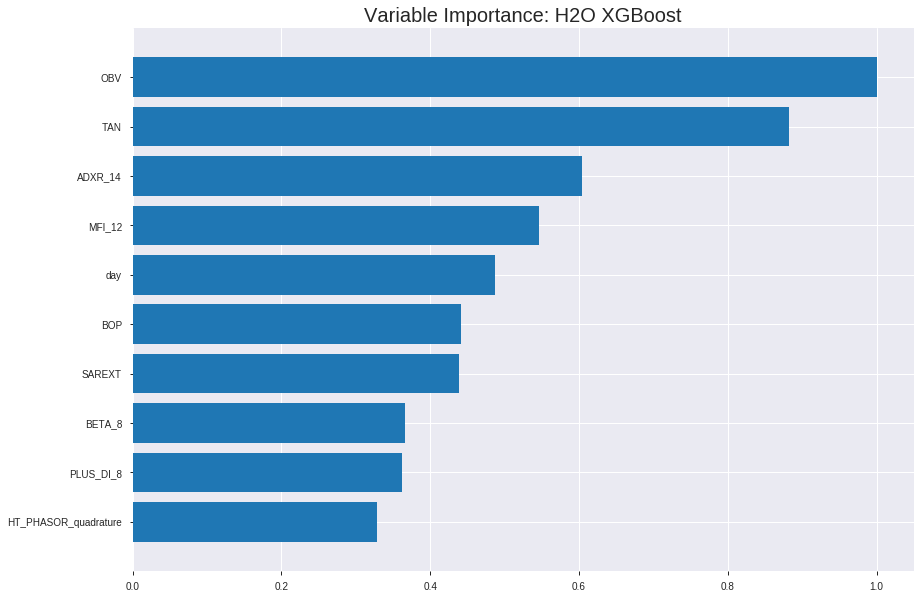

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_023820_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20957758149705308
RMSE: 0.45779644111444673
LogLoss: 0.6104510373030224
Mean Per-Class Error: 0.2620757405676305
AUC: 0.8182292868569372
pr_auc: 0.8326342496723634
Gini: 0.6364585737138744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4772978723049164: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  397   0.4777   (397.0/831.0)
1      104  819   0.1127   (104.0/923.0)
Total  538  1216  0.2856   (501.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477298     0.765778  262
max f2                       0.426082     0.867269  321
max f0point5                 0.539979     0.765995  181
max accuracy                 0.511845     0.739453  219
max precision                0.749585     1         0
max recall                   0.364645     1         373
max specificity              0.749585     1         0
max absolute_mcc             0.537731     0.478385  184
max min_per_class_accuracy   0.517322     0.732852  211
max mean_per_class_accuracy  0.511845     0.737924  219

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.707392           1.90033   1.90033            1                0.723574  1                           0.723574            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.691654           1.90033   1.90033            1                0.69887   1                           0.711222            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.682061           1.90033   1.90033            1                0.687372  1                           0.703572            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.67236            1.90033   1.90033            1                0.677086  1                           0.696857            0.0195016       0.0769231                  90.0325   90.0325
    5        0.050171                    0.665276           1.78854   1.87873            0.941176         0.668761  0.988636                    0.69143             0.0173348       0.0942579                  78.8541   87.873
    6        0.100342                    0.636857           1.72757   1.80315            0.909091         0.649826  0.948864                    0.670628            0.0866739       0.180932                   72.7568   80.3149
    7        0.149943                    0.618515           1.57268   1.72691            0.827586         0.627335  0.908745                    0.656307            0.0780065       0.258938                   57.2683   72.6911
    8        0.200114                    0.603513           1.68438   1.71625            0.886364         0.611069  0.903134                    0.644965            0.084507        0.343445                   68.4379   71.6248
    9        0.299886                    0.573738           1.41167   1.61491            0.742857         0.588776  0.84981                     0.626271            0.140845        0.48429                    41.167    61.4915
    10       0.400228                    0.545543           1.30647   1.53758            0.6875           0.559141  0.809117                    0.609441            0.131094        0.615385                   30.6473   53.7585
    11       0.5                         0.521314           1.05332   1.44095            0.554286         0.534087  0.758267                    0.594404            0.105092        0.720477                   5.3323    44.0953
    12       0.599772                    0.498791           0.955592  1.36021            0.502857         0.50959   0.715779                    0.580296            0.0953413       0.815818                   -4.4408   36.0214
    13       0.700114                    0.474107           0.745014  1.27204            0.392045         0.487517  0.669381                    0.566998            0.0747562       0.890574                   -25.4986  27.2042
    14       0.799886                    0.444426           0.608104  1.18923            0.32             0.460642  0.625802                    0.553732            0.0606717       0.951246                   -39.1896  18.9227
    15       0.899658                    0.410072           0.347488  1.09588            0.182857         0.428408  0.576679                    0.539834            0.0346696       0.985915                   -65.2512  9.58782
    16       1                           0.281908           0.140365  1                  0.0738636        0.376948  0.526226                    0.52349           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2551720705843104
RMSE: 0.5051455934523337
LogLoss: 0.7039620134440493
Mean Per-Class Error: 0.47163610383424626
AUC: 0.5089068825910932
pr_auc: 0.5062070610885823
Gini: 0.01781376518218636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3746720850467682: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.374672     0.673712   399
max f2                       0.374672     0.837714   399
max f0point5                 0.374672     0.563411   399
max accuracy                 0.533553     0.52988    236
max precision                0.603497     0.555556   76
max recall                   0.374672     1          399
max specificity              0.708762     0.995951   0
max absolute_mcc             0.384039     0.0882051  395
max min_per_class_accuracy   0.547599     0.51417    196
max mean_per_class_accuracy  0.533553     0.528364   236

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 54.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.684804           0.328105  0.328105           0.166667         0.693313  0.166667                    0.693313            0.00392157      0.00392157                 -67.1895  -67.1895
    2        0.0219124                   0.669365           0.787451  0.536898           0.4              0.675351  0.272727                    0.685148            0.00784314      0.0117647                  -21.2549  -46.3102
    3        0.0318725                   0.662043           0.787451  0.615196           0.4              0.664593  0.3125                      0.678725            0.00784314      0.0196078                  -21.2549  -38.4804
    4        0.0418327                   0.654152           1.5749    0.843697           0.8              0.65555   0.428571                    0.673207            0.0156863       0.0352941                  57.4902   -15.6303
    5        0.0517928                   0.648302           1.5749    0.984314           0.8              0.649837  0.5                         0.668713            0.0156863       0.0509804                  57.4902   -1.56863
    6        0.101594                    0.629553           1.02369   1.00361            0.52             0.636971  0.509804                    0.653153            0.0509804       0.101961                   2.36863   0.361399
    7        0.151394                    0.609718           1.18118   1.06202            0.6              0.617071  0.539474                    0.641284            0.0588235       0.160784                   18.1176   6.20227
    8        0.201195                    0.599997           0.944941  1.03304            0.48             0.604299  0.524752                    0.632129            0.0470588       0.207843                   -5.50588  3.30421
    9        0.300797                    0.573785           0.866196  0.977795           0.44             0.585381  0.496689                    0.61665             0.0862745       0.294118                   -13.3804  -2.22049
    10       0.400398                    0.561024           1.18118   1.02839            0.6              0.567927  0.522388                    0.60453             0.117647        0.411765                   18.1176   2.83875
    11       0.5                         0.547864           1.02369   1.02745            0.52             0.554876  0.521912                    0.594638            0.101961        0.513725                   2.36863   2.7451
    12       0.599602                    0.53247            1.10243   1.03991            0.56             0.54034   0.528239                    0.585619            0.109804        0.623529                   10.2431   3.99062
    13       0.699203                    0.515363           0.748078  0.998335           0.38             0.52395   0.507123                    0.576834            0.0745098       0.698039                   -25.1922  -0.166471
    14       0.798805                    0.495265           1.10243   1.01131            0.56             0.504931  0.513716                    0.567869            0.109804        0.807843                   10.2431   1.13149
    15       0.898406                    0.464405           0.866196  0.995226           0.44             0.481251  0.505543                    0.558266            0.0862745       0.894118                   -13.3804  -0.477371
    16       1                           0.374672           1.04221   1                  0.529412         0.43191   0.507968                    0.54542


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:38:50  12.820 sec  0                  0.5              0.693147            0.5             0                  1                0.473774                         0.5                0.693147              0.5               0                    1                  0.492032
    2019-09-03 02:38:52  14.217 sec  5                  0.493738         0.680687            0.699006        0.700956           1.47803          0.369441                         0.500569           0.694286              0.481694          0.521932             1.6107             0.492032
    2019-09-03 02:38:52  14.634 sec  10                 0.488788         0.670903            0.717241        0.72621            1.79475          0.3626                           0.500881           0.694919              0.493443          0.498381             0.984314           0.49004
    2019-09-03 02:38:52  15.014 sec  15                 0.483038         0.659584            0.742166        0.748009           1.5836           0.332383                         0.501432           0.69603               0.48633           0.493388             0.984314           0.492032
    2019-09-03 02:38:53  15.407 sec  20                 0.478901         0.651442            0.74971         0.757274           1.68918          0.340365                         0.502284           0.697775              0.488577          0.494838             0.656209           0.492032
    2019-09-03 02:38:53  15.790 sec  25                 0.475293         0.644396            0.765512        0.774729           1.90033          0.335804                         0.503002           0.69926               0.489045          0.492875             0.656209           0.492032
    2019-09-03 02:38:54  16.175 sec  30                 0.471601         0.637163            0.773485        0.786995           1.90033          0.312999                         0.503035           0.699414              0.501151          0.495658             0.328105           0.492032
    2019-09-03 02:38:54  16.567 sec  35                 0.467881         0.629912            0.786235        0.800324           1.90033          0.322691                         0.504313           0.702127              0.500564          0.493411             0.328105           0.488048
    2019-09-03 02:38:54  16.948 sec  40                 0.464272         0.622929            0.799912        0.813633           1.90033          0.322121                         0.50458            0.702715              0.506422          0.501718             0.656209           0.49004
    2019-09-03 02:38:55  17.357 sec  45                 0.461139         0.616867            0.807896        0.824154           1.90033          0.290194                         0.504457           0.702513              0.511392          0.504989             0.656209           0.492032
    2019-09-03 02:38:55  17.759 sec  50                 0.457796         0.610451            0.818229        0.832634           1.90033          0.285633                         0.505146           0.703962              0.508907          0.506207             0.328105           0.492032

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
OBV                      156.01278686523438     1.0                   0.044698808735566795
TAN                      137.67860412597656     0.882482820109514     0.03944593078849876
ADXR_14                  94.33585357666016      0.6046674472788474    0.027027914574540617
MFI_12                   85.24559783935547      0.546401353069807     0.024423489573722205
day                      75.97848510742188      0.48700165309560783   0.021768393745625426
---                      ---                    ---                   ---
AROONOSC_30              5.747114658355713      0.03683745912006646   0.0016465905395121113
BBANDS_lowerband_14_4_2  5.592158317565918      0.035844230655250636  0.0016021944103325884
LINEARREG_ANGLE_14       5.532948017120361      0.03546470855558644   0.0015852302245887777
STOCHF_fastk             5.118375778198242      0.0328074120143726    0.001466452234739377
MOM_12                   4.970441818237305      0.03185919512181286   0.0014240680692190158


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6937669376693767)

('auc', 0.5623409669211196)

('logloss', 0.685759925494409)

('mean_per_class_error', 0.4462786259541984)

('rmse', 0.49634328202647293)

('mse', 0.24635665361281087)

xgboost prediction progress: |████████████████████████████████████████████| 100%


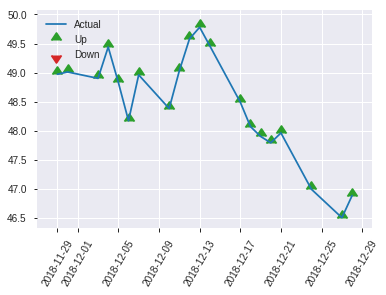


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24635665361281087
RMSE: 0.49634328202647293
LogLoss: 0.685759925494409
Mean Per-Class Error: 0.4462786259541984
AUC: 0.5623409669211196
pr_auc: 0.5822350868487306
Gini: 0.12468193384223913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4566209018230438: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   110  0.9167   (110.0/120.0)
1      3    128  0.0229   (3.0/131.0)
Total  13   238  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456621     0.693767  237
max f2                       0.441524     0.848446  247
max f0point5                 0.477428     0.592705  213
max accuracy                 0.477428     0.557769  213
max precision                0.642639     0.857143  6
max recall                   0.441524     1         247
max specificity              0.654397     0.991667  0
max absolute_mcc             0.614783     0.138115  22
max min_per_class_accuracy   0.53739      0.525     125
max mean_per_class_accuracy  0.579971     0.553721  57

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.652937           1.27735   1.27735            0.666667         0.653921  0.666667                    0.653921            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.64541            1.91603   1.59669            1                0.648958  0.833333                    0.65144             0.0229008       0.0381679                  91.6031    59.6692
    3        0.0318725                   0.642037           0.958015  1.43702            0.5              0.642567  0.75                        0.649221            0.00763359      0.0458015                  -4.19847   43.7023
    4        0.0438247                   0.636961           1.27735   1.39348            0.666667         0.638634  0.727273                    0.646334            0.0152672       0.0610687                  27.7354    39.3477
    5        0.0517928                   0.633111           0.958015  1.32648            0.5              0.635295  0.692308                    0.644636            0.00763359      0.0687023                  -4.19847   32.6483
    6        0.103586                    0.613411           1.32648   1.32648            0.692308         0.620601  0.692308                    0.632618            0.0687023       0.137405                   32.6483    32.6483
    7        0.151394                    0.595779           0.798346  1.1597             0.416667         0.603177  0.605263                    0.623321            0.0381679       0.175573                   -20.1654   15.9703
    8        0.203187                    0.584068           1.1791    1.16465            0.615385         0.589621  0.607843                    0.614731            0.0610687       0.236641                   17.9096    16.4646
    9        0.302789                    0.567874           0.843053  1.05886            0.44             0.576679  0.552632                    0.602214            0.0839695       0.320611                   -15.6947   5.8859
    10       0.40239                     0.551318           1.22626   1.10029            0.64             0.557655  0.574257                    0.591184            0.122137        0.442748                   22.626     10.0295
    11       0.501992                    0.53739            0.843053  1.04925            0.44             0.544346  0.547619                    0.581891            0.0839695       0.526718                   -15.6947   4.92548
    12       0.601594                    0.521415           1.07298   1.05318            0.56             0.529769  0.549669                    0.573262            0.10687         0.633588                   7.29771    5.31823
    13       0.701195                    0.504502           0.996336  1.04511            0.52             0.513079  0.545455                    0.564713            0.0992366       0.732824                   -0.366412  4.51076
    14       0.800797                    0.487634           0.996336  1.03904            0.52             0.496844  0.542289                    0.556271            0.0992366       0.832061                   -0.366412  3.90414
    15       0.900398                    0.462526           0.919695  1.02584            0.48             0.476634  0.535398                    0.547462            0.0916031       0.923664                   -8.03053   2.58394
    16       1                           0.433514           0.766412  1                  0.4              0.452463  0.521912                    0

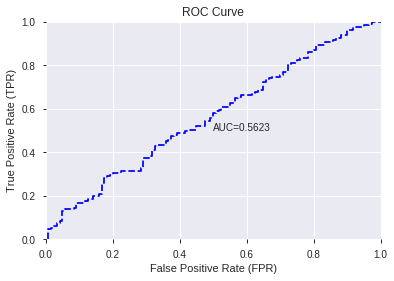

This function is available for GLM models only


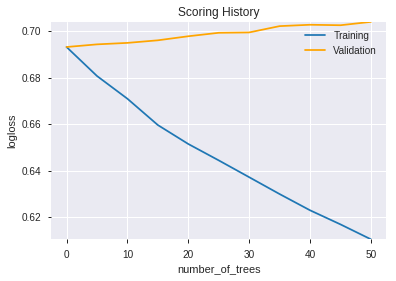

--2019-09-03 02:39:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_023820_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_023820_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023929_model_9  0.555693  0.691961              0.469084  0.499406  0.249407
1               DeepLearning_1_AutoML_20190903_023929  0.541285  0.970172              0.495833  0.582839  0.339701
2  DeepLearning_grid_1_AutoML_20190903_023929_model_1  0.504326  1.745982              0.487500  0.646076  0.417415
3  DeepLearning_grid_1_AutoML_20190903_023929_model_8  0.503817  0.692398              0.500000  0.499625  0.249626
4  DeepLearning_grid_1_AutoML_20190903_023929_model_5  0.503308  0.692476              0.491667  0.499665  0.249665
5  DeepLearning_grid_1_AutoML_20190903_023929_model_2  0.501081  2.214234              0.500000  0.685929  0.470498
6  DeepLearning_grid_1_AutoML_20190903_023929_model_6  0.485878  0.694995              0.500000  0.500922  0.250923
7  DeepLearning_grid_1_AutoML_20190903_023929_model_3  0.464186  1.981394              0.495833  0.689263  0.475083
8  DeepLearning_grid_1_AutoML_20190903_023929_model_4  0.462214  0.927372              0.500000  0.580613  0.337111
9  DeepLearning_grid_1_AutoML_20190903_023929_model_7  0.446120  0.772971              0.500000  0.531911  0.282930

variable  relative_importance  scaled_importance  percentage
0                 aroonup_30             1.000000           1.000000    0.021576
1                  CDLINNECK             0.987644           0.987644    0.021310
2                 MIDPRICE_8             0.985268           0.985268    0.021258
3                        day             0.982714           0.982714    0.021203
4                HT_DCPERIOD             0.974856           0.974856    0.021034
5          MACDFIX_signal_24             0.961431           0.961431    0.020744
6                        OBV             0.961368           0.961368    0.020743
7                 ROCR100_14             0.959578           0.959578    0.020704
8                    CDLDOJI             0.958648           0.958648    0.020684
9   BBANDS_middleband_12_0_5             0.956015           0.956015    0.020627
10                aroonup_20             0.954571           0.954571    0.020596
11                     VAR_8             0.950427           0.950427    0.020507
12                    ADXR_8             0.948036           0.948036    0.020455
13                     DX_12             0.947075           0.947075    0.020434
14              STOCHF_fastk             0.946308           0.946308    0.020418
15             days_in_month             0.945939           0.945939    0.020410
16         LINEARREG_ANGLE_8             0.945194           0.945194    0.020394
17            CDLRICKSHAWMAN             0.942263           0.942263    0.020331
18              weekday_name             0.939415           0.939415    0.020269
19                     month             0.935205           0.935205    0.020178
20                   MACDEXT             0.934094           0.934094    0.020154
21                 dayofweek             0.933826           0.933826    0.020149
22                       BOP             0.931164           0.931164    0.020091
23    BBANDS_upperband_8_3_5             0.930365           0.930365    0.020074
24   BBANDS_lowerband_30_0_5             0.928650           0.928650    0.020037
25   BBANDS_lowerband_12_6_5             0.927165           0.927165    0.020005
26    BBANDS_lowerband_8_5_4             0.923866           0.923866    0.019934
27                    BETA_8             0.920903           0.920903    0.019870
28                    ROC_14             0.917962           0.917962    0.019806
29                aroonup_24             0.917578           0.917578    0.019798
30                  SAR_0.24             0.916223           0.916223    0.019769
31              HT_TRENDMODE             0.913383           0.913383    0.019707
32                   BETA_24             0.912546           0.912546    0.019689
33                       DIV             0.912459           0.912459    0.019688
34        CDLCLOSINGMARUBOZU             0.908177           0.908177    0.019595
35   BBANDS_upperband_30_2_5             0.908018           0.908018    0.019592
36         CDLLONGLEGGEDDOJI             0.907763           0.907763    0.019586
37            is_quarter_end             0.903133           0.903133    0.019486
38                   BETA_14             0.901503           0.901503    0.019451
39                   WILLR_8             0.900302           0.900302    0.019425
40  BBANDS_middleband_20_0_3             0.897361           0.897361    0.019362
41                   quarter             0.894888           0.894888    0.019308
42   BBANDS_upperband_24_5_5             0.894178           0.894178    0.019293
43   BBANDS_upperband_12_2_3             0.891685           0.891685    0.019239
44               aroondown_8             0.888568           0.888568    0.019172
45        CDLSEPARATINGLINES             0.885365           0.885365    0.019103
46   BBANDS_upperband_30_0_5             0.873509           0.873509    0.018847
47                   weekday             0.870600           0.870600    0.018784
48            CDLMORNINGSTAR             0.861554  

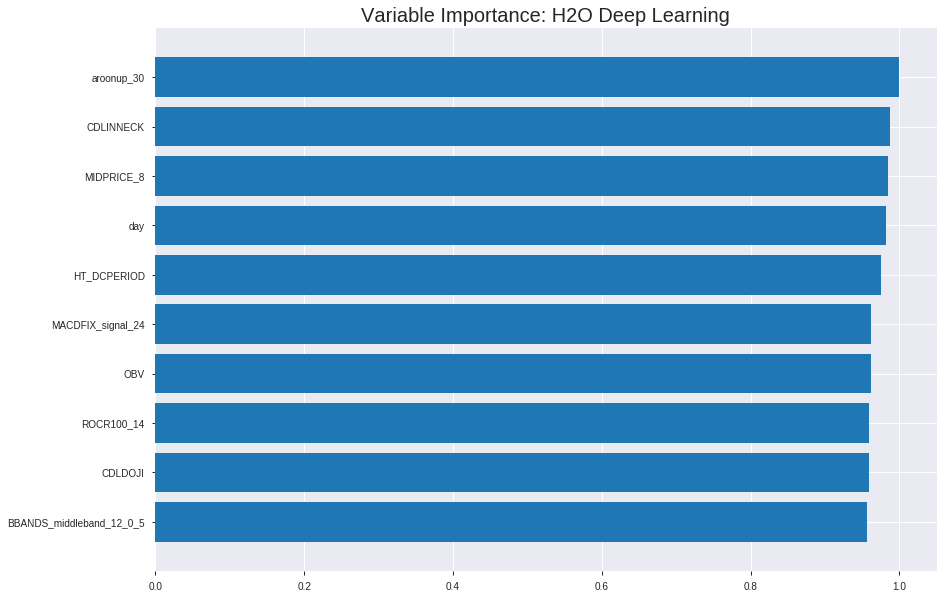

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023929_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24773348051129948
RMSE: 0.4977283199811916
LogLoss: 0.6885972142301374
Mean Per-Class Error: 0.44172654179264237
AUC: 0.5575153224260866
pr_auc: 0.5730976586175218
Gini: 0.11503064485217318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4966609821188636: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    831   1        (831.0/831.0)
1      0    923   0        (0.0/923.0)
Total  0    1754  0.4738   (831.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496661     0.689578  399
max f2                       0.496661     0.847411  399
max f0point5                 0.498107     0.581469  395
max accuracy                 0.528846     0.555302  222
max precision                0.594376     1         0
max recall                   0.496661     1         399
max specificity              0.594376     1         0
max absolute_mcc             0.528846     0.117061  222
max min_per_class_accuracy   0.525451     0.548212  241
max mean_per_class_accuracy  0.528846     0.558273  222

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.581127           1.05574   1.05574            0.555556         0.584959  0.555556                    0.584959            0.0108342       0.0108342                  5.57361   5.57361
    2        0.0205245                   0.576795           1.05574   1.05574            0.555556         0.578898  0.555556                    0.581929            0.0108342       0.0216685                  5.57361   5.57361
    3        0.0302166                   0.572322           1.00605   1.0398             0.529412         0.574597  0.54717                     0.579577            0.00975081      0.0314193                  0.605443  3.98005
    4        0.0404789                   0.570403           1.5836    1.17767            0.833333         0.571351  0.619718                    0.577491            0.0162514       0.0476706                  58.3604   17.7666
    5        0.050171                    0.567638           0.894271  1.12292            0.470588         0.569118  0.590909                    0.575874            0.00866739      0.056338                   -10.5729  12.2919
    6        0.100342                    0.558199           1.23089   1.17691            0.647727         0.562542  0.619318                    0.569208            0.0617551       0.118093                   23.0892   17.6906
    7        0.149943                    0.551872           1.20135   1.18499            0.632184         0.555182  0.623574                    0.564568            0.0595883       0.177681                   20.1355   18.4994
    8        0.200114                    0.54689            1.05814   1.15319            0.556818         0.549382  0.606838                    0.560761            0.0530878       0.230769                   5.81355   15.3189
    9        0.299886                    0.53795            1.09676   1.13441            0.577143         0.54225   0.596958                    0.554602            0.109426        0.340195                   9.6759    13.4415
    10       0.400228                    0.531936           1.11212   1.12883            0.585227         0.535075  0.594017                    0.549707            0.111593        0.451788                   11.2122   12.8826
    11       0.5                         0.525477           0.933874  1.08992            0.491429         0.528613  0.573546                    0.545498            0.0931744       0.544962                   -6.6126   8.99242
    12       0.599772                    0.519996           0.944733  1.06577            0.497143         0.522845  0.560837                    0.541729            0.0942579       0.63922                    -5.5267   6.57716
    13       0.700114                    0.515114           0.84219   1.03373            0.443182         0.517362  0.543974                    0.538237            0.084507        0.723727                   -15.781   3.37273
    14       0.799886                    0.510689           0.944733  1.02263            0.497143         0.512846  0.538133                    0.53507             0.0942579       0.817985                   -5.5267   2.26268
    15       0.899658                    0.505479           0.901297  1.00917            0.474286         0.508195  0.531052                    0.532089            0.0899242       0.907909                   -9.8703   0.917134
    16       1                           0.496661           0.917771  1                  0.482955         0.501852  0.526226                    0.529055        



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24964504549203181
RMSE: 0.49964491940980627
LogLoss: 0.6924370335754434
Mean Per-Class Error: 0.4594347860601731
AUC: 0.5298245614035088
pr_auc: 0.5372911200313614
Gini: 0.05964912280701751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5009239104680584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   230  0.9312   (230.0/247.0)
1      6    249  0.0235   (6.0/255.0)
Total  23   479  0.4701   (236.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500924     0.678474  377
max f2                       0.498254     0.839368  396
max f0point5                 0.503177     0.573935  340
max accuracy                 0.505803     0.543825  277
max precision                0.524389     1         0
max recall                   0.498254     1         396
max specificity              0.524389     1         0
max absolute_mcc             0.520235     0.111795  8
max min_per_class_accuracy   0.508908     0.52549   197
max mean_per_class_accuracy  0.505803     0.540565  277

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.520677           1.64052   1.64052            0.833333         0.522171  0.833333                    0.522171            0.0196078       0.0196078                  64.0523   64.0523
    2        0.0219124                   0.520046           1.5749    1.6107             0.8              0.520315  0.818182                    0.521327            0.0156863       0.0352941                  57.4902   61.0695
    3        0.0318725                   0.519166           0.393725  1.23039            0.2              0.519614  0.625                       0.520792            0.00392157      0.0392157                  -60.6275  23.0392
    4        0.0418327                   0.518632           1.5749    1.31242            0.8              0.518742  0.666667                    0.520304            0.0156863       0.054902                   57.4902   31.2418
    5        0.0517928                   0.518089           0.787451  1.21146            0.4              0.518283  0.615385                    0.519915            0.00784314      0.0627451                  -21.2549  21.1463
    6        0.101594                    0.516243           0.866196  1.04221            0.44             0.517032  0.529412                    0.518502            0.0431373       0.105882                   -13.3804  4.22145
    7        0.151394                    0.515156           1.10243   1.06202            0.56             0.515622  0.539474                    0.517554            0.054902        0.160784                   10.2431   6.20227
    8        0.201195                    0.514115           0.944941  1.03304            0.48             0.514629  0.524752                    0.51683             0.0470588       0.207843                   -5.50588  3.30421
    9        0.300797                    0.512214           0.787451  0.951721           0.4              0.513186  0.483444                    0.515624            0.0784314       0.286275                   -21.2549  -4.82794
    10       0.400398                    0.510465           1.1418    0.999005           0.58             0.511342  0.507463                    0.514559            0.113725        0.4                        14.1804   -0.0995025
    11       0.5                         0.508771           1.25992   1.05098            0.64             0.509606  0.533865                    0.513572            0.12549         0.52549                    25.9922   5.09804
    12       0.599602                    0.507306           0.984314  1.03991            0.5              0.507967  0.528239                    0.512641            0.0980392       0.623529                   -1.56863  3.99062
    13       0.699203                    0.505874           1.10243   1.04881            0.56             0.506575  0.532764                    0.511777            0.109804        0.733333                   10.2431   4.88129
    14       0.798805                    0.504388           0.826824  1.02113            0.42             0.505153  0.518703                    0.510951            0.0823529       0.815686                   -17.3176  2.11334
    15       0.898406                    0.50238            1.02369   1.02142            0.52             0.503555  0.518847                    0.510131            0.101961        0.917647                   2.36863   2.14165
    16       1                           0.495442           0.810611  1                  0.411765         0.500715  0.507968                    0.509174     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:46:33  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:46:35  2 min 19.326 sec  505 obs/sec       0.578677  1             1015       0.595012         1.08465             -0.420062      0.544038        0.56292            1.16131          0.472634                         0.530273           0.778206              -0.125044        0.534508          0.52804              0.656209           0.488048
    2019-09-03 02:46:45  2 min 29.406 sec  804 obs/sec       5.10718   9             8958       0.497728         0.688597            0.00633234     0.557515        0.573098           1.05574          0.473774                         0.499645           0.692437              0.00116615       0.529825          0.537291             1.64052            0.47012
    2019-09-03 02:46:55  2 min 39.773 sec  967 obs/sec       11.3301   20            19873      0.502147         0.697466            -0.0113883     0.560939        0.58964            1.26688          0.473204                         0.504012           0.701266              -0.0163719       0.523458          0.517693             0.984314           0.486056
    2019-09-03 02:47:05  2 min 49.932 sec  1071 obs/sec      18.1648   32            31861      0.497352         0.687853            0.00783333     0.575355        0.595303           1.26688          0.461802                         0.501867           0.696905              -0.00773649      0.506121          0.518833             1.31242            0.488048
    2019-09-03 02:47:15  2 min 59.616 sec  1140 obs/sec      25.0137   44            43874      0.496849         0.686836            0.00983979     0.565016        0.599885           1.68918          0.45325                          0.500844           0.694843              -0.00363456      0.502088          0.00199408           1.00207            0.49004
    2019-09-03 02:47:25  3 min  9.360 sec  1205 obs/sec      32.4806   57            56971      0.492843         0.678705            0.0257415      0.590388        0.612732           1.5836           0.443558                         0.501354           0.695874              -0.00567738      0.492339          0.0872151            0.991361           0.488048
    2019-09-03 02:47:35  3 min 19.536 sec  1260 obs/sec      40.5804   71            71178      0.49286          0.67854             0.0256768      0.606702        0.633141           1.68918          0.436716                         0.500752           0.694655              -0.00326669      0.504374          0.510615             0.984314           0.492032
    2019-09-03 02:47:36  3 min 20.527 sec  1259 obs/sec      40.5804   71            71178      0.497728         0.688597            0.00633234     0.557515        0.573098           1.05574          0.473774                         0.499645           0.692437              0.00116615       0.529825          0.537291             1.64052            0.47012

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
aroonup_30               1.0                    1.0                  0.021576364758265913
CDLINNECK                0.9876444935798645     0.9876444935798645   0.021309777844971973
MIDPRICE_8               0.9852678775787354     0.9852678775787354   0.021258499111241277
day                      0.9827144742012024     0.9827144742012024   0.021203405948592637
HT_DCPERIOD              0.9748564958572388     0.9748564958572388   0.021033859341580724
---                      ---                    ---                  ---
CDLSEPARATINGLINES       0.8853654861450195     0.8853654861450195   0.019102968673444364
BBANDS_upperband_30_0_5  0.8735089898109436     0.8735089898109436   0.0188471485837853
weekday                  0.8705998659133911     0.8705998659133911   0.018784380265444718
CDLMORNINGSTAR           0.8615537285804749     0.8615537285804749   0.01858919750669635
STDDEV_8                 0.8582646250724792     0.8582646250724792   0.018518230609680147


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6904109589041096)

('auc', 0.5556933842239186)

('logloss', 0.6919606529361935)

('mean_per_class_error', 0.43708651399491094)

('rmse', 0.49940648943461563)

('mse', 0.24940684168940686)

deeplearning prediction progress: |███████████████████████████████████████| 100%


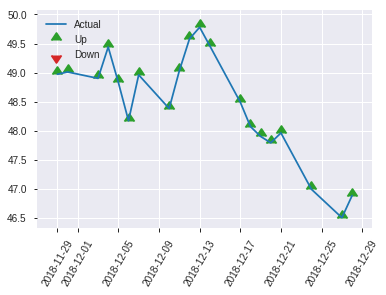


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24940684168940686
RMSE: 0.49940648943461563
LogLoss: 0.6919606529361935
Mean Per-Class Error: 0.43708651399491094
AUC: 0.5556933842239186
pr_auc: 0.5576291377971615
Gini: 0.11138676844783713
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5030099471617798: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   108  0.9      (108.0/120.0)
1      5    126  0.0382   (5.0/131.0)
Total  17   234  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50301      0.690411  232
max f2                       0.499136     0.845161  249
max f0point5                 0.50447      0.601901  202
max accuracy                 0.505159     0.573705  186
max precision                0.516258     1         0
max recall                   0.499136     1         249
max specificity              0.516258     1         0
max absolute_mcc             0.50447      0.153947  202
max min_per_class_accuracy   0.507389     0.525     124
max mean_per_class_accuracy  0.505159     0.562913  186

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 50.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.515114           1.27735   1.27735            0.666667         0.515921  0.666667                    0.515921            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.514236           1.27735   1.27735            0.666667         0.514521  0.666667                    0.515221            0.0152672       0.0305344                  27.7354    27.7354
    3        0.0318725                   0.514025           0.958015  1.19752            0.5              0.51417   0.625                       0.514958            0.00763359      0.0381679                  -4.19847   19.7519
    4        0.0438247                   0.513802           0.638677  1.04511            0.333333         0.513867  0.545455                    0.514661            0.00763359      0.0458015                  -36.1323   4.51076
    5        0.0517928                   0.513418           0.958015  1.03171            0.5              0.51347   0.538462                    0.514477            0.00763359      0.0534351                  -4.19847   3.17087
    6        0.103586                    0.512381           1.1791    1.1054             0.615385         0.512909  0.576923                    0.513693            0.0610687       0.114504                   17.9096    10.5402
    7        0.151394                    0.511548           0.958015  1.05886            0.5              0.511873  0.552632                    0.513118            0.0458015       0.160305                   -4.19847   5.8859
    8        0.203187                    0.510989           1.47387   1.16465            0.769231         0.511221  0.607843                    0.512635            0.0763359       0.236641                   47.387     16.4646
    9        0.302789                    0.509721           0.843053  1.05886            0.44             0.510313  0.552632                    0.511871            0.0839695       0.320611                   -15.6947   5.8859
    10       0.40239                     0.50843            0.996336  1.04338            0.52             0.509103  0.544554                    0.511186            0.0992366       0.419847                   -0.366412  4.3383
    11       0.501992                    0.507389           1.07298   1.04925            0.56             0.50785   0.547619                    0.510524            0.10687         0.526718                   7.29771    4.92548
    12       0.601594                    0.50634            1.14962   1.06587            0.6              0.506819  0.556291                    0.50991             0.114504        0.641221                   14.9618    6.58713
    13       0.701195                    0.505574           1.14962   1.07777            0.6              0.505911  0.5625                      0.509342            0.114504        0.755725                   14.9618    7.77672
    14       0.800797                    0.504555           0.996336  1.06764            0.52             0.505126  0.557214                    0.508818            0.0992366       0.854962                   -0.366412  6.76389
    15       0.900398                    0.503389           0.843053  1.0428             0.44             0.503926  0.544248                    0.508277            0.0839695       0.938931                   -15.6947   4.27954
    16       1                           0.499136           0.61313   1                  0.32             0.502107  0.521912                    0.5

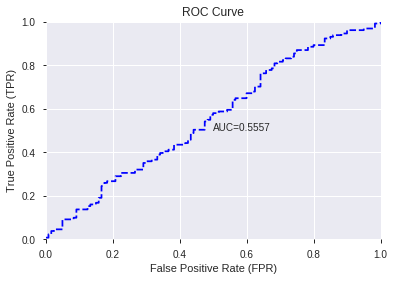

This function is available for GLM models only


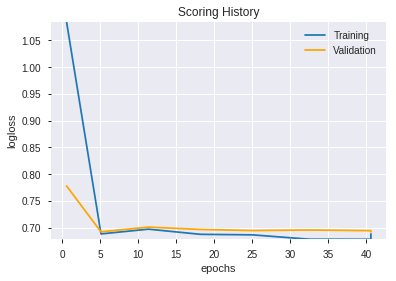

--2019-09-03 02:47:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023929_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023929_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroonup_30',
 'CDLINNECK',
 'MIDPRICE_8',
 'day',
 'HT_DCPERIOD',
 'MACDFIX_signal_24',
 'OBV',
 'ROCR100_14',
 'CDLDOJI',
 'BBANDS_middleband_12_0_5',
 'aroonup_20',
 'VAR_8',
 'ADXR_8',
 'DX_12',
 'STOCHF_fastk',
 'days_in_month',
 'LINEARREG_ANGLE_8',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'month',
 'MACDEXT',
 'dayofweek',
 'BOP',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_lowerband_12_6_5',
 'BBANDS_lowerband_8_5_4',
 'BETA_8',
 'ROC_14',
 'aroonup_24',
 'SAR_0.24',
 'HT_TRENDMODE',
 'BETA_24',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_upperband_30_2_5',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_end',
 'BETA_14',
 'WILLR_8',
 'BBANDS_middleband_20_0_3',
 'quarter',
 'BBANDS_upperband_24_5_5',
 'BBANDS_upperband_12_2_3',
 'aroondown_8',
 'CDLSEPARATINGLINES',
 'BBANDS_upperband_30_0_5',
 'weekday',
 'CDLMORNINGSTAR',
 'STDDEV_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024754_model_1  0.497201  0.692899                0.4868  0.499876  0.249876

variable  relative_importance  scaled_importance  percentage
0                 aroonup_30             0.007966           1.000000    0.055775
1                 aroonup_20             0.007306           0.917187    0.051156
2                 aroonup_24             0.006306           0.791635    0.044153
3                        OBV             0.006145           0.771456    0.043028
4                        day             0.005631           0.706887    0.039427
5               weekday_name             0.005505           0.691059    0.038544
6                    MACDEXT             0.004957           0.622282    0.034708
7                     ROC_14             0.004631           0.581388    0.032427
8                 ROCR100_14             0.004629           0.581134    0.032413
9                        BOP             0.004467           0.560703    0.031273
10                     DX_12             0.004443           0.557785    0.031110
11               HT_DCPERIOD             0.004095           0.514097    0.028674
12        CDLSEPARATINGLINES             0.003410           0.428061    0.023875
13                       DIV             0.003222           0.404501    0.022561
14                   BETA_24             0.003182           0.399427    0.022278
15         MACDFIX_signal_24             0.003176           0.398659    0.022235
16            CDLMORNINGSTAR             0.003078           0.386401    0.021552
17              HT_TRENDMODE             0.003053           0.383262    0.021376
18                 CDLINNECK             0.002796           0.351011    0.019578
19                  SAR_0.24             0.002765           0.347051    0.019357
20                MIDPRICE_8             0.002710           0.340143    0.018971
21    BBANDS_upperband_8_3_5             0.002699           0.338803    0.018897
22    BBANDS_lowerband_8_5_4             0.002611           0.327782    0.018282
23  BBANDS_middleband_12_0_5             0.002593           0.325473    0.018153
24   BBANDS_upperband_12_2_3             0.002551           0.320206    0.017859
25                 dayofweek             0.002486           0.312066    0.017406
26                   weekday             0.002484           0.311787    0.017390
27                   WILLR_8             0.002480           0.311275    0.017361
28                    ADXR_8             0.002475           0.310646    0.017326
29   BBANDS_lowerband_12_6_5             0.002447           0.307132    0.017130
30                     month             0.002407           0.302112    0.016850
31   BBANDS_lowerband_30_0_5             0.002321           0.291366    0.016251
32  BBANDS_middleband_20_0_3             0.002280           0.286164    0.015961
33            is_quarter_end             0.002262           0.283981    0.015839
34              STOCHF_fastk             0.002152           0.270177    0.015069
35                   quarter             0.002089           0.262303    0.014630
36   BBANDS_upperband_30_2_5             0.002079           0.261007    0.014558
37   BBANDS_upperband_30_0_5             0.001981           0.248630    0.013867
38   BBANDS_upperband_24_5_5             0.001925           0.241654    0.013478
39                  STDDEV_8             0.001378           0.173008    0.009650
40               aroondown_8             0.001217           0.152757    0.008520
41             days_in_month             0.001024           0.128517    0.007168
42        CDLCLOSINGMARUBOZU             0.000971           0.121837    0.006795
43            CDLRICKSHAWMAN             0.000900           0.113019    0.006304
44                    BETA_8             0.000615           0.077206    0.004306
45         LINEARREG_ANGLE_8             0.000487           0.061177    0.003412
46                     VAR_8             0.000280           0.035097    0.001958
47                   CDLDOJI             0.000076           0.009514    0.000531
48         CDLLONGLEGGEDDOJI             0.000075  

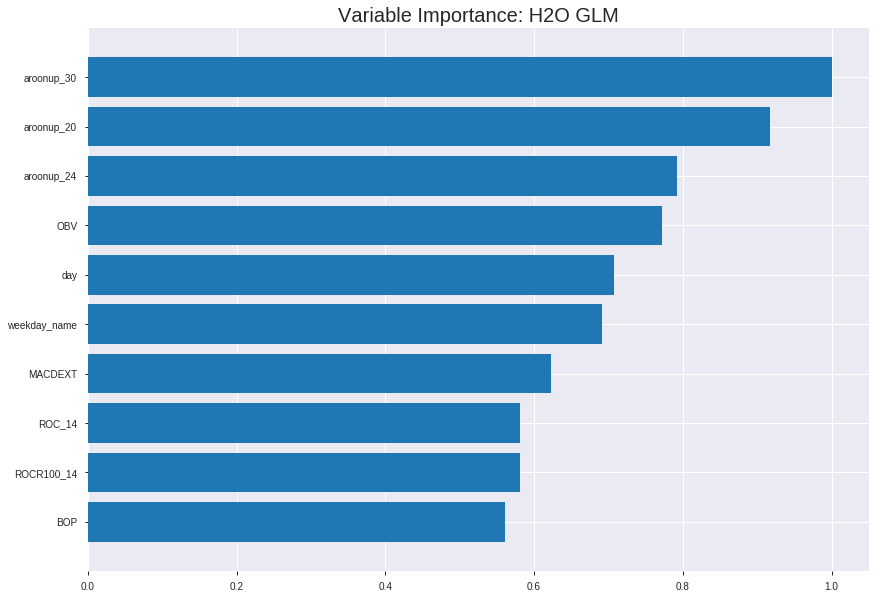

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024754_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24814949378941561
RMSE: 0.4981460566835952
LogLoss: 0.689437562738731
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2426.732552703876
Residual deviance: 2418.5469700874683
AIC: 2520.5469700874683
AUC: 0.567996239959427
pr_auc: 0.5874704021460827
Gini: 0.1359924799188541
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4927111014361818: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      14   817   0.9832   (817.0/831.0)
1      6    917   0.0065   (6.0/923.0)
Total  20   1734  0.4692   (823.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492711     0.690252  387
max f2                       0.48652      0.847567  398
max f0point5                 0.521693     0.587131  237
max accuracy                 0.521975     0.557013  235
max precision                0.558797     1         0
max recall                   0.48652      1         398
max specificity              0.558797     1         0
max absolute_mcc             0.534112     0.121679  119
max min_per_class_accuracy   0.527517     0.547129  182
max mean_per_class_accuracy  0.531049     0.555795  149

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.548969           1.37246   1.37246            0.722222         0.552542  0.722222                    0.552542            0.0140845       0.0140845                  37.2457   37.2457
    2        0.0205245                   0.54672            1.16131   1.26688            0.611111         0.547616  0.666667                    0.550079            0.0119177       0.0260022                  16.131    26.6883
    3        0.0302166                   0.54526            0.782487  1.11151            0.411765         0.545792  0.584906                    0.548704            0.00758397      0.0335861                  -21.7513  11.1511
    4        0.0404789                   0.544254           1.26688   1.1509             0.666667         0.544824  0.605634                    0.54772             0.0130011       0.0465872                  26.6883   15.0901
    5        0.050171                    0.543211           1.11784   1.14451            0.588235         0.543662  0.602273                    0.546936            0.0108342       0.0574215                  11.7838   14.4514
    6        0.100342                    0.540706           1.29568   1.2201             0.681818         0.541769  0.642045                    0.544353            0.0650054       0.122427                   29.5676   22.0095
    7        0.149943                    0.538401           1.2232    1.22112            0.643678         0.539564  0.642586                    0.542768            0.0606717       0.183099                   22.3198   22.1121
    8        0.200114                    0.536603           1.12292   1.1965             0.590909         0.537448  0.62963                     0.541435            0.056338        0.239437                   12.2919   19.6501
    9        0.299886                    0.533615           1.11848   1.17054            0.588571         0.534994  0.61597                     0.539292            0.111593        0.351029                   11.8477   17.0542
    10       0.400228                    0.530663           0.982554  1.12341            0.517045         0.532007  0.591168                    0.537465            0.0985915       0.449621                   -1.74456  12.3412
    11       0.5                         0.527529           0.955592  1.08992            0.502857         0.529125  0.573546                    0.535801            0.0953413       0.544962                   -4.4408   8.99242
    12       0.599772                    0.524547           0.966451  1.06938            0.508571         0.526027  0.562738                    0.534175            0.0964247       0.641387                   -3.3549   6.93844
    13       0.700114                    0.520578           0.982554  1.05694            0.517045         0.522476  0.556189                    0.532498            0.0985915       0.739978                   -1.74456  5.69397
    14       0.799886                    0.516555           0.857861  1.03211            0.451429         0.518617  0.543122                    0.530767            0.0855905       0.825569                   -14.2139  3.21081
    15       0.899658                    0.510601           0.847002  1.01158            0.445714         0.514062  0.532319                    0.528914            0.084507        0.910076                   -15.2998  1.15799
    16       1                           0.482234           0.896176  1                  0.471591         0.502121  0.526226                    0.526226         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24985445577627177
RMSE: 0.4998544345869823
LogLoss: 0.6928554110624756
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 696.4627613688081
Residual deviance: 695.6268327067255
AIC: 797.6268327067255
AUC: 0.5195681511470985
pr_auc: 0.52995392785236
Gini: 0.03913630229419707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47363449763712734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    243  0.9838   (243.0/247.0)
1      1    254  0.0039   (1.0/255.0)
Total  5    497  0.4861   (244.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.473634     0.675532   394
max f2                       0.472772     0.838816   397
max f0point5                 0.473634     0.566206   394
max accuracy                 0.510877     0.545817   208
max precision                0.539554     1          0
max recall                   0.472772     1          397
max specificity              0.539554     1          0
max absolute_mcc             0.534888     0.0987155  4
max min_per_class_accuracy   0.512761     0.521569   185
max mean_per_class_accuracy  0.510877     0.544939   208

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.534691           1.64052   1.64052            0.833333         0.535814  0.833333                    0.535814            0.0196078       0.0196078                  64.0523   64.0523
    2        0.0219124                   0.531788           0.787451  1.25276            0.4              0.532288  0.636364                    0.534211            0.00784314      0.027451                   -21.2549  25.2763
    3        0.0318725                   0.530714           0.787451  1.10735            0.4              0.530931  0.5625                      0.533186            0.00784314      0.0352941                  -21.2549  10.7353
    4        0.0418327                   0.529687           1.18118   1.12493            0.6              0.530041  0.571429                    0.532437            0.0117647       0.0470588                  18.1176   12.493
    5        0.0517928                   0.528753           1.5749    1.21146            0.8              0.52924   0.615385                    0.531822            0.0156863       0.0627451                  57.4902   21.1463
    6        0.101594                    0.526022           0.629961  0.926413           0.32             0.527317  0.470588                    0.529614            0.0313725       0.0941176                  -37.0039  -7.35871
    7        0.151394                    0.52416            1.10243   0.984314           0.56             0.525172  0.5                         0.528153            0.054902        0.14902                    10.2431   -1.56863
    8        0.201195                    0.522409           1.02369   0.994059           0.52             0.523083  0.50495                     0.526898            0.0509804       0.2                        2.36863   -0.594059
    9        0.300797                    0.518816           1.22055   1.06906            0.62             0.520401  0.543046                    0.524747            0.121569        0.321569                   22.0549   6.9056
    10       0.400398                    0.515738           1.1418    1.08715            0.58             0.517378  0.552239                    0.522914            0.113725        0.435294                   14.1804   8.71525
    11       0.5                         0.512732           0.866196  1.04314            0.44             0.514186  0.52988                     0.521175            0.0862745       0.521569                   -13.3804  4.31373
    12       0.599602                    0.508948           1.10243   1.05299            0.56             0.510939  0.534884                    0.519475            0.109804        0.631373                   10.2431   5.29868
    13       0.699203                    0.505236           0.787451  1.01516            0.4              0.507178  0.51567                     0.517723            0.0784314       0.709804                   -21.2549  1.51612
    14       0.798805                    0.500002           0.748078  0.981859           0.38             0.503193  0.498753                    0.515911            0.0745098       0.784314                   -25.1922  -1.81409
    15       0.898406                    0.489429           1.25992   1.01269            0.64             0.494687  0.514412                    0.513558            0.12549         0.909804                   25.9922   1.26864
    16       1                           0.469816           0.887812  1                  0.45098          0.482567  0.507968                    0.51041       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:47:54  0.000 sec   2            3.6       51            1.37888           1.38571
    2019-09-03 02:47:54  0.020 sec   4            2.2       51            1.37714           1.38604
    2019-09-03 02:47:54  0.038 sec   6            1.4       51            1.37508           1.38686
    2019-09-03 02:47:54  0.055 sec   8            0.86      51            1.37272           1.38821
    2019-09-03 02:47:54  0.069 sec   10           0.53      51            1.37014           1.39002
    2019-09-03 02:47:54  0.091 sec   12           0.33      51            1.36746           1.39217

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6880000000000001)

('auc', 0.49720101781170484)

('logloss', 0.6928988996110449)

('mean_per_class_error', 0.4593193384223919)

('rmse', 0.49987581115553226)

('mse', 0.24987582657840132)

glm prediction progress: |████████████████████████████████████████████████| 100%


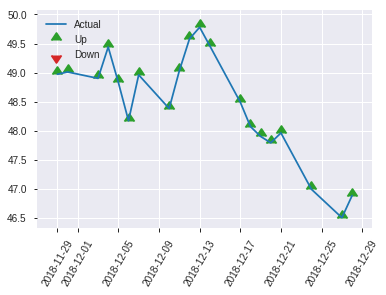


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24987582657840132
RMSE: 0.49987581115553226
LogLoss: 0.6928988996110449
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.49638460687265
Residual deviance: 347.83524760474455
AIC: 449.83524760474455
AUC: 0.49720101781170484
pr_auc: 0.5157773001470095
Gini: -0.005597964376590325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49020792821915105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    115  0.9583   (115.0/120.0)
1      2    129  0.0153   (2.0/131.0)
Total  7    244  0.4661   (117.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490208     0.688     243
max f2                       0.486776     0.845161  250
max f0point5                 0.4974       0.588235  200
max accuracy                 0.4974       0.553785  200
max precision                0.523038     0.7       9
max recall                   0.486776     1         250
max specificity              0.526163     0.991667  0
max absolute_mcc             0.4974       0.101756  200
max min_per_class_accuracy   0.507556     0.503817  124
max mean_per_class_accuracy  0.4974       0.540681  200

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 50.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.524927           0.638677  0.638677           0.333333         0.525732  0.333333                    0.525732            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0239044                   0.523939           1.27735   0.958015           0.666667         0.524184  0.5                         0.524958            0.0152672       0.0229008                  27.7354    -4.19847
    3        0.0318725                   0.523445           1.91603   1.19752            1                0.523692  0.625                       0.524642            0.0152672       0.0381679                  91.6031    19.7519
    4        0.0438247                   0.521922           1.27735   1.21929            0.666667         0.52276   0.636364                    0.524128            0.0152672       0.0534351                  27.7354    21.9292
    5        0.0517928                   0.521568           0.958015  1.1791             0.5              0.521752  0.615385                    0.523763            0.00763359      0.0610687                  -4.19847   17.9096
    6        0.103586                    0.519541           0.884322  1.03171            0.461538         0.520346  0.538462                    0.522054            0.0458015       0.10687                    -11.5678   3.17087
    7        0.151394                    0.517924           0.479008  0.857172           0.25             0.518619  0.447368                    0.520969            0.0229008       0.129771                   -52.0992   -14.2828
    8        0.203187                    0.516737           0.884322  0.864092           0.461538         0.517488  0.45098                     0.520082            0.0458015       0.175573                   -11.5678   -13.5908
    9        0.302789                    0.512409           1.07298   0.932804           0.56             0.514288  0.486842                    0.518176            0.10687         0.282443                   7.29771    -6.71957
    10       0.40239                     0.509629           1.14962   0.986471           0.6              0.511104  0.514851                    0.516426            0.114504        0.396947                   14.9618    -1.35288
    11       0.501992                    0.507524           1.07298   1.00364            0.56             0.508585  0.52381                     0.51487             0.10687         0.503817                   7.29771    0.363504
    12       0.601594                    0.504275           0.766412  0.96436            0.4              0.505694  0.503311                    0.513351            0.0763359       0.580153                   -23.3588   -3.56403
    13       0.701195                    0.500231           1.37954   1.02333            0.72             0.502091  0.534091                    0.511751            0.137405        0.717557                   37.9542    2.33345
    14       0.800797                    0.4974             1.22626   1.04857            0.64             0.498847  0.547264                    0.510146            0.122137        0.839695                   22.626     4.85739
    15       0.900398                    0.495015           0.61313   1.00041            0.32             0.496212  0.522124                    0.508605            0.0610687       0.900763                   -38.687    0.0405323
    16       1                           0.486776           0.996336  1                  0.52             0.491525  0.521912          

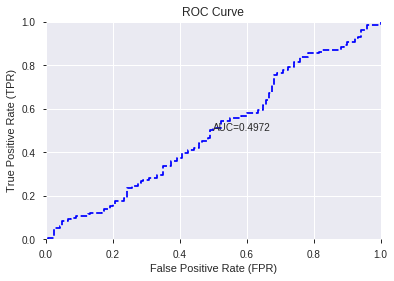

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


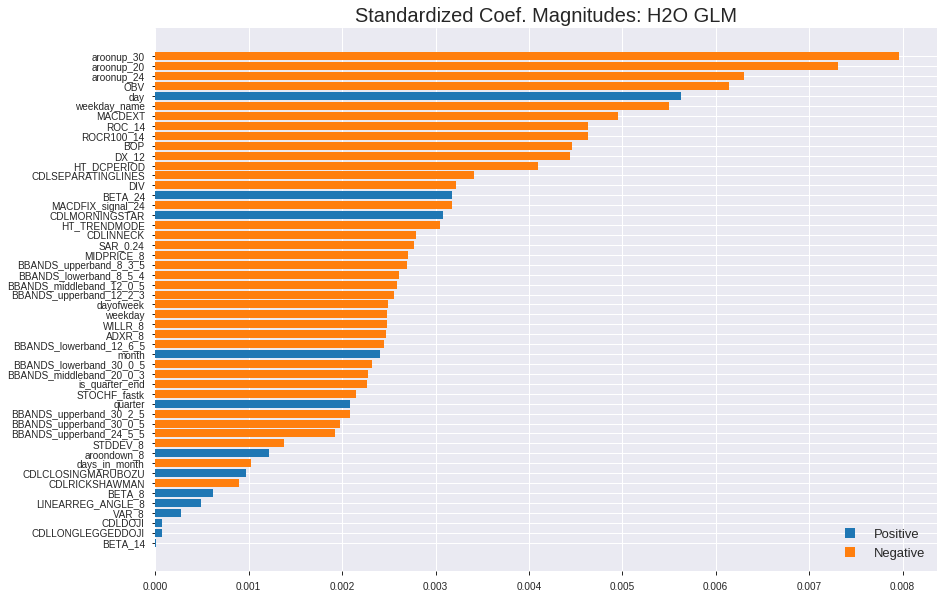

'log_likelihood'
--2019-09-03 02:48:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024754_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024754_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroonup_30',
 'aroonup_20',
 'aroonup_24',
 'OBV',
 'day',
 'weekday_name',
 'MACDEXT',
 'ROC_14',
 'ROCR100_14',
 'BOP',
 'DX_12',
 'HT_DCPERIOD',
 'CDLSEPARATINGLINES',
 'DIV',
 'BETA_24',
 'MACDFIX_signal_24',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLINNECK',
 'SAR_0.24',
 'MIDPRICE_8',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_middleband_12_0_5',
 'BBANDS_upperband_12_2_3',
 'dayofweek',
 'weekday',
 'WILLR_8',
 'ADXR_8',
 'BBANDS_lowerband_12_6_5',
 'month',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_middleband_20_0_3',
 'is_quarter_end',
 'STOCHF_fastk',
 'quarter',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_30_0_5',
 'BBANDS_upperband_24_5_5',
 'STDDEV_8',
 'aroondown_8',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'CDLRICKSHAWMAN',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'VAR_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'BETA_14']

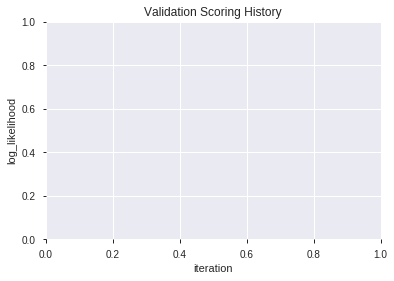

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024811_model_6  0.555662  0.696509              0.451368  0.501642  0.251645
1  XGBoost_grid_1_AutoML_20190903_024811_model_5  0.545420  0.697760              0.470483  0.502164  0.252169
2  XGBoost_grid_1_AutoML_20190903_024811_model_4  0.534860  0.691958              0.478817  0.499372  0.249372
3  XGBoost_grid_1_AutoML_20190903_024811_model_2  0.534288  0.690268              0.466317  0.498488  0.248491
4  XGBoost_grid_1_AutoML_20190903_024811_model_3  0.533206  0.693983              0.474650  0.500342  0.250342
5               XGBoost_1_AutoML_20190903_024811  0.522074  0.697358              0.483333  0.502021  0.252025
6               XGBoost_2_AutoML_20190903_024811  0.500700  0.702430              0.491667  0.504486  0.254506
7  XGBoost_grid_1_AutoML_20190903_024811_model_1  0.493066  0.710011              0.500000  0.507965  0.258028
8  XGBoost_grid_1_AutoML_20190903_024811_model_7  0.484987  0.710860              0.461800  0.508621  0.258696
9               XGBoost_3_AutoML_20190903_024811  0.482443  0.704670              0.495833  0.505543  0.255574

variable  relative_importance  scaled_importance  percentage
0                        OBV           465.583252           1.000000    0.073554
1                        DIV           402.116333           0.863683    0.063527
2                        BOP           388.603241           0.834659    0.061393
3               STOCHF_fastk           314.528748           0.675559    0.049690
4                      DX_12           295.457428           0.634596    0.046677
5                     ROC_14           294.200928           0.631898    0.046479
6                HT_DCPERIOD           256.530182           0.550987    0.040527
7                     BETA_8           249.780823           0.536490    0.039461
8                    WILLR_8           235.874344           0.506621    0.037264
9                     ADXR_8           227.180923           0.487949    0.035891
10         MACDFIX_signal_24           201.752304           0.433332    0.031873
11         LINEARREG_ANGLE_8           190.949829           0.410130    0.030167
12                       day           190.572647           0.409320    0.030107
13                  STDDEV_8           182.273605           0.391495    0.028796
14                   BETA_14           172.634247           0.370791    0.027273
15   BBANDS_lowerband_12_6_5           167.682678           0.360156    0.026491
16                   MACDEXT           158.925934           0.341348    0.025108
17    BBANDS_lowerband_8_5_4           151.762100           0.325961    0.023976
18                   BETA_24           146.395508           0.314435    0.023128
19                aroonup_30           132.457413           0.284498    0.020926
20  BBANDS_middleband_12_0_5           122.064606           0.262176    0.019284
21                aroonup_20           108.105560           0.232194    0.017079
22                  SAR_0.24           106.827805           0.229449    0.016877
23   BBANDS_lowerband_30_0_5           102.509201           0.220174    0.016195
24    BBANDS_upperband_8_3_5            98.189072           0.210895    0.015512
25              weekday_name            93.348404           0.200498    0.014747
26   BBANDS_upperband_12_2_3            88.303703           0.189663    0.013950
27               aroondown_8            86.443878           0.185668    0.013657
28                 dayofweek            80.811066           0.173570    0.012767
29                MIDPRICE_8            74.115013           0.159187    0.011709
30                aroonup_24            69.540482           0.149362    0.010986
31   BBANDS_upperband_24_5_5            67.255211           0.144454    0.010625
32                     month            60.355293           0.129634    0.009535
33                     VAR_8            53.418091           0.114734    0.008439
34   BBANDS_upperband_30_2_5            49.873871           0.107121    0.007879
35                ROCR100_14            48.573334           0.104328    0.007674
36  BBANDS_middleband_20_0_3            42.678619           0.091667    0.006742
37                   weekday            41.761532           0.089697    0.006598
38   BBANDS_upperband_30_0_5            37.604858           0.080769    0.005941
39            CDLRICKSHAWMAN            22.734871           0.048831    0.003592
40             days_in_month            20.527586           0.044090    0.003243
41              HT_TRENDMODE            10.096026           0.021685    0.001595
42        CDLCLOSINGMARUBOZU            10.042169           0.021569    0.001586
43                   quarter             9.369585           0.020124    0.001480

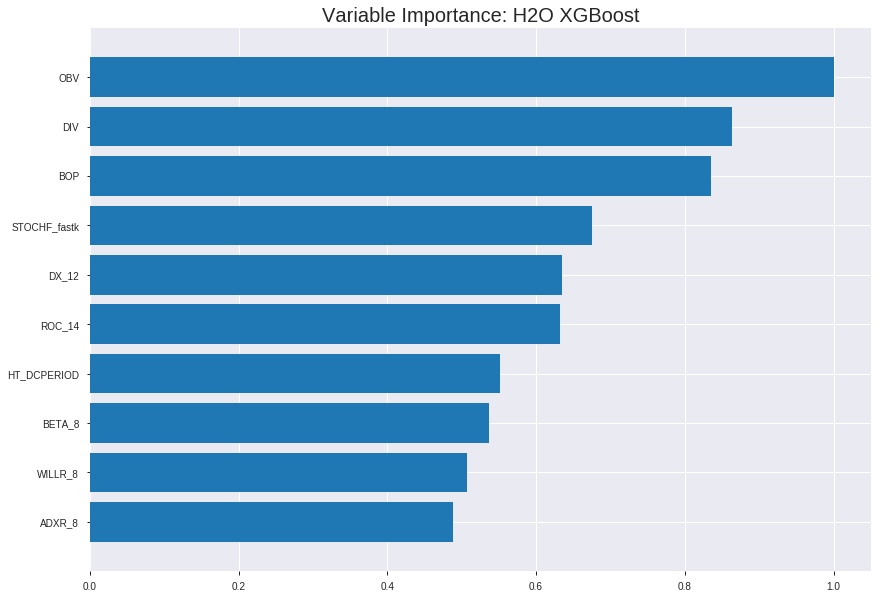

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024811_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18738510368602865
RMSE: 0.43288001072586924
LogLoss: 0.5642479385763081
Mean Per-Class Error: 0.16267194949759656
AUC: 0.9163312746980821
pr_auc: 0.9229108837723947
Gini: 0.8326625493961641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49903554916381837: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      622  209   0.2515   (209.0/831.0)
1      92   831   0.0997   (92.0/923.0)
Total  714  1040  0.1716   (301.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499036     0.846663  221
max f2                       0.466412     0.9054    256
max f0point5                 0.534895     0.86268   182
max accuracy                 0.532631     0.835234  184
max precision                0.80845      1         0
max recall                   0.332973     1         366
max specificity              0.80845      1         0
max absolute_mcc             0.532631     0.674395  184
max min_per_class_accuracy   0.519215     0.834236  197
max mean_per_class_accuracy  0.532631     0.837328  184

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.745333           1.90033    1.90033            1                0.764996  1                           0.764996            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.728151           1.90033    1.90033            1                0.736174  1                           0.750585            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.709708           1.90033    1.90033            1                0.719244  1                           0.740532            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.698662           1.90033    1.90033            1                0.704918  1                           0.731503            0.0195016       0.0769231                  90.0325   90.0325
    5        0.050171                    0.689612           1.90033    1.90033            1                0.693581  1                           0.724177            0.0184182       0.0953413                  90.0325   90.0325
    6        0.100342                    0.660801           1.87873    1.88953            0.988636         0.67372   0.994318                    0.698949            0.0942579       0.189599                   87.873    88.9528
    7        0.149943                    0.635569           1.87848    1.88587            0.988506         0.648261  0.992395                    0.682181            0.0931744       0.282774                   87.8482   88.5874
    8        0.200114                    0.617789           1.74916    1.8516             0.920455         0.626427  0.974359                    0.668203            0.0877573       0.370531                   74.9163   85.1599
    9        0.299886                    0.581417           1.694      1.79917            0.891429         0.60116   0.946768                    0.645898            0.169014        0.539545                   69.4004   79.9167
    10       0.400228                    0.55187            1.51162    1.72708            0.795455         0.56633   0.908832                    0.625949            0.151679        0.691224                   51.1622   72.7076
    11       0.5                         0.525253           1.23793    1.62947            0.651429         0.538887  0.857469                    0.608576            0.12351         0.814735                   23.7926   62.9469
    12       0.599772                    0.496221           0.901297   1.50834            0.474286         0.510669  0.793726                    0.59229             0.0899242       0.904659                   -9.8703   50.8338
    13       0.700114                    0.466748           0.593852   1.37727            0.3125           0.482974  0.724756                    0.576622            0.0595883       0.964247                   -40.6148  37.7271
    14       0.799886                    0.429335           0.238898   1.23528            0.125714         0.446706  0.650036                    0.560417            0.0238353       0.988082                   -76.1102  23.5279
    15       0.899658                    0.385237           0.097731   1.10913            0.0514286        0.407982  0.58365                     0.543512            0.00975081      0.997833                   -90.2269  10.9125
    16       1                           0.184684           0.0215946  1                  0.0113636        0.339938  0.526226                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2537242077832663
RMSE: 0.5037104404151916
LogLoss: 0.7010322701363711
Mean Per-Class Error: 0.46522981662300544
AUC: 0.5249265698182107
pr_auc: 0.5236161490934274
Gini: 0.04985313963642146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2873692810535431: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    245  0.9919   (245.0/247.0)
1      0    255  0        (0.0/255.0)
Total  2    500  0.488    (245.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.287369     0.675497   397
max f2                       0.287369     0.838816   397
max f0point5                 0.384949     0.572891   351
max accuracy                 0.384949     0.533865   351
max precision                0.727024     1          0
max recall                   0.287369     1          397
max specificity              0.727024     1          0
max absolute_mcc             0.384949     0.0897584  351
max min_per_class_accuracy   0.497254     0.51417    192
max mean_per_class_accuracy  0.532967     0.53477    129

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.673328           1.31242   1.31242            0.666667         0.692457  0.666667                    0.692457            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.65818            0.787451  1.0738             0.4              0.665561  0.545455                    0.680231            0.00784314      0.0235294                  -21.2549  7.37968
    3        0.0318725                   0.641204           0.787451  0.984314           0.4              0.649331  0.5                         0.670575            0.00784314      0.0313725                  -21.2549  -1.56863
    4        0.0418327                   0.638194           0.787451  0.937442           0.4              0.639266  0.47619                     0.66312             0.00784314      0.0392157                  -21.2549  -6.25584
    5        0.0517928                   0.632688           0.787451  0.908597           0.4              0.634919  0.461538                    0.657697            0.00784314      0.0470588                  -21.2549  -9.14027
    6        0.101594                    0.607937           1.25992   1.08082            0.64             0.619032  0.54902                     0.638744            0.0627451       0.109804                   25.9922   8.08151
    7        0.151394                    0.584056           0.787451  0.984314           0.4              0.598095  0.5                         0.625372            0.0392157       0.14902                    -21.2549  -1.56863
    8        0.201195                    0.560152           1.25992   1.05253            0.64             0.571116  0.534653                    0.611942            0.0627451       0.211765                   25.9922   5.25335
    9        0.300797                    0.537483           1.18118   1.09513            0.6              0.547229  0.556291                    0.590514            0.117647        0.329412                   18.1176   9.51305
    10       0.400398                    0.516281           0.905569  1.04798            0.46             0.526854  0.532338                    0.574678            0.0901961       0.419608                   -9.44314  4.79758
    11       0.5                         0.497582           0.944941  1.02745            0.48             0.505357  0.521912                    0.560869            0.0941176       0.513725                   -5.50588  2.7451
    12       0.599602                    0.476635           1.06306   1.03337            0.54             0.486766  0.524917                    0.54856             0.105882        0.619608                   6.30588   3.33659
    13       0.699203                    0.452878           0.984314  1.02638            0.5              0.465903  0.521368                    0.536785            0.0980392       0.717647                   -1.56863  2.63784
    14       0.798805                    0.427024           0.944941  1.01622            0.48             0.440758  0.516209                    0.524812            0.0941176       0.811765                   -5.50588  1.62241
    15       0.898406                    0.383812           1.10243   1.02578            0.56             0.407055  0.521064                    0.511757            0.109804        0.921569                   10.2431   2.57815
    16       1                           0.252252           0.772011  1                  0.392157         0.344783  0.507968                    0.494793      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:48:24  7.681 sec   0                  0.5              0.693147            0.5             0                  1                0.473774                         0.5                0.693147              0.5               0                    1                  0.492032
    2019-09-03 02:48:24  7.796 sec   5                  0.48851          0.670379            0.775634        0.785814           1.79475          0.329532                         0.499738           0.692623              0.518187          0.522366             0.984314           0.492032
    2019-09-03 02:48:24  7.856 sec   10                 0.480834         0.655367            0.81349         0.825818           1.90033          0.296465                         0.499636           0.692408              0.518878          0.533201             1.68739            0.48008
    2019-09-03 02:48:24  7.921 sec   15                 0.471433         0.637202            0.8499          0.860681           1.90033          0.257697                         0.49932            0.691774              0.528229          0.532956             0.984314           0.488048
    2019-09-03 02:48:24  7.989 sec   20                 0.464969         0.624766            0.85916         0.868929           1.90033          0.234892                         0.499939           0.693024              0.523712          0.526851             1.31242            0.484064
    2019-09-03 02:48:24  8.065 sec   25                 0.457594         0.610719            0.87737         0.886148           1.90033          0.209236                         0.50134            0.695878              0.514519          0.515044             1.31242            0.486056
    2019-09-03 02:48:24  8.129 sec   30                 0.452132         0.60033             0.886528        0.893895           1.90033          0.198404                         0.502454           0.6982                0.512598          0.508831             0.984314           0.486056
    2019-09-03 02:48:24  8.193 sec   35                 0.44652          0.589812            0.90012         0.90608            1.90033          0.189282                         0.5025             0.698352              0.515734          0.510484             0.656209           0.484064
    2019-09-03 02:48:24  8.257 sec   40                 0.441537         0.580448            0.905365        0.910927           1.90033          0.185291                         0.50213            0.697619              0.522942          0.516875             0.984314           0.486056
    2019-09-03 02:48:24  8.323 sec   45                 0.436452         0.570956            0.913344        0.919582           1.90033          0.172748                         0.502213           0.697859              0.526975          0.520962             0.984314           0.49004
    2019-09-03 02:48:24  8.389 sec   50                 0.43288          0.564248            0.916331        0.922911           1.90033          0.171608                         0.50371            0.701032              0.524927          0.523616             1.31242            0.488048

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
OBV                 465.583251953125       1.0                   0.07355403758699283
DIV                 402.1163330078125      0.86368298541868      0.06352737077273178
BOP                 388.6032409667969      0.8346589773936317    0.061392537795532186
STOCHF_fastk        314.52874755859375     0.6755585520723597    0.0496900591313448
DX_12               295.4574279785156      0.6345963406953958    0.04667712309607725
---                 ---                    ---                   ---
CDLRICKSHAWMAN      22.73487091064453      0.04883094659284153   0.003591713281098306
days_in_month       20.527585983276367     0.04409004382602467   0.0032430007407915798
HT_TRENDMODE        10.096026420593262     0.021684685559973133  0.0015949961767403845
CDLCLOSINGMARUBOZU  10.042168617248535     0.0215690074226716    0.0015864875826813144
quarter             9.369585037231445      0.020124403096387102  0.001480231101767452


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.6929577464788733)

('auc', 0.5556615776081425)

('logloss', 0.6965085567340403)

('mean_per_class_error', 0.41657124681933844)

('rmse', 0.5016419382717804)

('mse', 0.25164463423306876)

xgboost prediction progress: |████████████████████████████████████████████| 100%


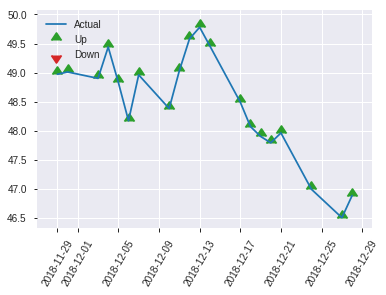


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25164463423306876
RMSE: 0.5016419382717804
LogLoss: 0.6965085567340403
Mean Per-Class Error: 0.41657124681933844
AUC: 0.5556615776081425
pr_auc: 0.5305937439149797
Gini: 0.111323155216285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3754134774208069: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   101  0.8417   (101.0/120.0)
1      8    123  0.0611   (8.0/131.0)
Total  27   224  0.4343   (109.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375413     0.692958  223
max f2                       0.314853     0.846253  249
max f0point5                 0.439068     0.609756  161
max accuracy                 0.439068     0.589641  161
max precision                0.669593     1         0
max recall                   0.314853     1         249
max specificity              0.669593     1         0
max absolute_mcc             0.439068     0.174229  161
max min_per_class_accuracy   0.468725     0.541667  125
max mean_per_class_accuracy  0.439068     0.583429  161

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 46.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.632824           0.638677  0.638677           0.333333         0.654054  0.333333                    0.654054            0.00763359      0.00763359                 -36.1323  -36.1323
    2        0.0239044                   0.615912           1.27735   0.958015           0.666667         0.622209  0.5                         0.638132            0.0152672       0.0229008                  27.7354   -4.19847
    3        0.0318725                   0.599241           0.958015  0.958015           0.5              0.604028  0.5                         0.629606            0.00763359      0.0305344                  -4.19847  -4.19847
    4        0.0438247                   0.593457           1.27735   1.04511            0.666667         0.5953    0.545455                    0.62025             0.0152672       0.0458015                  27.7354   4.51076
    5        0.0517928                   0.589639           0         0.884322           0                0.592487  0.461538                    0.615978            0               0.0458015                  -100      -11.5678
    6        0.103586                    0.561427           0.442161  0.663241           0.230769         0.57477   0.346154                    0.595374            0.0229008       0.0687023                  -55.7839  -33.6759
    7        0.151394                    0.542685           1.11768   0.80675            0.583333         0.551284  0.421053                    0.581451            0.0534351       0.122137                   11.7684   -19.325
    8        0.203187                    0.528551           1.47387   0.9768             0.769231         0.535152  0.509804                    0.569649            0.0763359       0.198473                   47.387    -2.32001
    9        0.302789                    0.507672           1.3029    1.08407            0.68             0.517154  0.565789                    0.552381            0.129771        0.328244                   30.2901   8.40699
    10       0.40239                     0.484449           1.07298   1.08132            0.56             0.496537  0.564356                    0.538558            0.10687         0.435115                   7.29771   8.13242
    11       0.501992                    0.468725           1.07298   1.07967            0.56             0.47655   0.563492                    0.526255            0.10687         0.541985                   7.29771   7.9668
    12       0.601594                    0.447728           1.22626   1.10394            0.64             0.457697  0.576159                    0.514904            0.122137        0.664122                   22.626    10.3938
    13       0.701195                    0.426537           0.919695  1.07777            0.48             0.436299  0.5625                      0.503739            0.0916031       0.755725                   -8.03053  7.77672
    14       0.800797                    0.402348           0.766412  1.03904            0.4              0.412992  0.542289                    0.492452            0.0763359       0.832061                   -23.3588  3.90414
    15       0.900398                    0.373004           1.07298   1.0428             0.56             0.388002  0.544248                    0.480898            0.10687         0.938931                   7.29771   4.27954
    16       1                           0.290725           0.61313   1                  0.32             0.349256  0.521912                    0.467786    

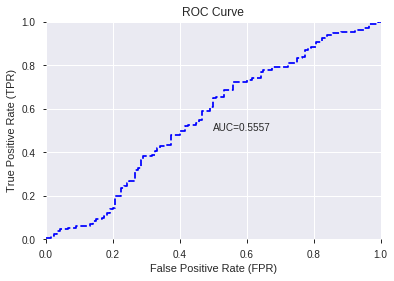

This function is available for GLM models only


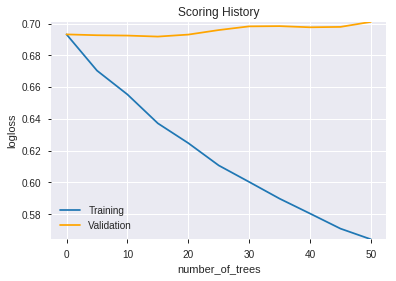

--2019-09-03 02:48:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024811_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024811_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'DIV',
 'BOP',
 'STOCHF_fastk',
 'DX_12',
 'ROC_14',
 'HT_DCPERIOD',
 'BETA_8',
 'WILLR_8',
 'ADXR_8',
 'MACDFIX_signal_24',
 'LINEARREG_ANGLE_8',
 'day',
 'STDDEV_8',
 'BETA_14',
 'BBANDS_lowerband_12_6_5',
 'MACDEXT',
 'BBANDS_lowerband_8_5_4',
 'BETA_24',
 'aroonup_30',
 'BBANDS_middleband_12_0_5',
 'aroonup_20',
 'SAR_0.24',
 'BBANDS_lowerband_30_0_5',
 'BBANDS_upperband_8_3_5',
 'weekday_name',
 'BBANDS_upperband_12_2_3',
 'aroondown_8',
 'dayofweek',
 'MIDPRICE_8',
 'aroonup_24',
 'BBANDS_upperband_24_5_5',
 'month',
 'VAR_8',
 'BBANDS_upperband_30_2_5',
 'ROCR100_14',
 'BBANDS_middleband_20_0_3',
 'weekday',
 'BBANDS_upperband_30_0_5',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [892] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024843_model_2  0.552735   2.392456              0.478117  0.595306  0.354389
1  DeepLearning_grid_1_AutoML_20190903_024843_model_4  0.543448   9.153750              0.500000  0.688949  0.474651
2  DeepLearning_grid_1_AutoML_20190903_024843_model_6  0.511228   0.692271              0.500000  0.499562  0.249562
3  DeepLearning_grid_1_AutoML_20190903_024843_model_8  0.500000   0.692772              0.500000  0.499812  0.249812
4  DeepLearning_grid_1_AutoML_20190903_024843_model_5  0.500000   0.692591              0.500000  0.499722  0.249722
5  DeepLearning_grid_1_AutoML_20190903_024843_model_9  0.500000   0.692224              0.500000  0.499538  0.249538
6  DeepLearning_grid_1_AutoML_20190903_024843_model_7  0.495547  12.527182              0.478817  0.658579  0.433726
7  DeepLearning_grid_1_AutoML_20190903_024843_model_1  0.492939  15.102601              0.500000  0.690546  0.476854
8  DeepLearning_grid_1_AutoML_20190903_024843_model_3  0.443670   4.265545              0.491317  0.691472  0.478134
9               DeepLearning_1_AutoML_20190903_024843  0.437945  12.294717              0.491317  0.685415  0.469794

variable  relative_importance  scaled_importance  percentage
0                  HT_DCPERIOD             1.000000           1.000000    0.001827
1           CDLMORNINGDOJISTAR             0.940947           0.940947    0.001719
2                          day             0.932195           0.932195    0.001703
3                         TANH             0.917231           0.917231    0.001676
4                          SIN             0.911504           0.911504    0.001665
...                        ...                  ...                ...         ...
1036                   MA_14_2             0.447805           0.447805    0.000818
1037               MIDPRICE_14             0.447792           0.447792    0.000818
1038   BBANDS_lowerband_14_6_4             0.447155           0.447155    0.000817
1039  BBANDS_middleband_12_0_2             0.443826           0.443826    0.000811
1040                    SMA_14             0.435731           0.435731    0.000796

[1041 rows x 4 columns]

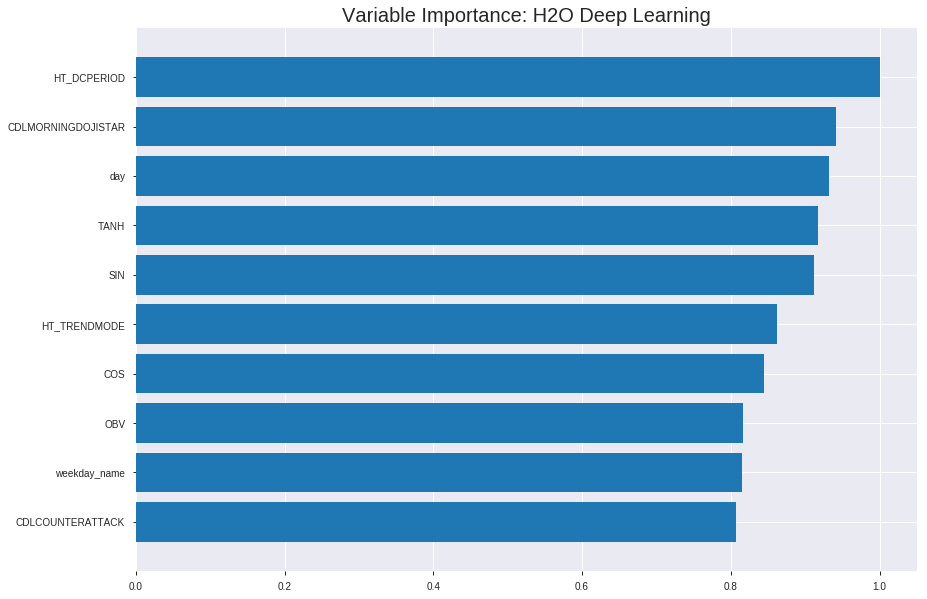

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024843_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26165675884431205
RMSE: 0.5115239572535308
LogLoss: 0.719812140081385
Mean Per-Class Error: 0.4617216396593018
AUC: 0.5458734076215136
pr_auc: 0.5775461434655841
Gini: 0.09174681524302719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20197728485194824: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   802   0.9651   (802.0/831.0)
1      13   910   0.0141   (13.0/923.0)
Total  42   1712  0.4647   (815.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.201977     0.690702   373
max f2                       0.113799     0.847722   397
max f0point5                 0.26203      0.58623    335
max accuracy                 0.282933     0.541619   320
max precision                0.620935     0.814815   14
max recall                   0.113799     1          397
max specificity              0.676164     0.998797   0
max absolute_mcc             0.57244      0.0946193  55
max min_per_class_accuracy   0.440176     0.523466   184
max mean_per_class_accuracy  0.492889     0.538278   135

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 43.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.624117           1.37246   1.37246            0.722222         0.643088  0.722222                    0.643088            0.0140845       0.0140845                  37.2457    37.2457
    2        0.0205245                   0.613138           1.5836    1.47803            0.833333         0.619395  0.777778                    0.631242            0.0162514       0.0303359                  58.3604    47.8031
    3        0.0302166                   0.608443           1.34141   1.43421            0.705882         0.610837  0.754717                    0.624697            0.0130011       0.0433369                  34.1406    43.4208
    4        0.0404789                   0.601876           1.16131   1.36502            0.611111         0.604414  0.71831                     0.619555            0.0119177       0.0552546                  16.131     36.5022
    5        0.050171                    0.59735            1.11784   1.31727            0.588235         0.599578  0.693182                    0.615696            0.0108342       0.0660888                  11.7838    31.7271
    6        0.100342                    0.575338           1.1877    1.25249            0.625            0.586108  0.659091                    0.600902            0.0595883       0.125677                   18.7703    25.2487
    7        0.149943                    0.557138           1.04846   1.18499            0.551724         0.566462  0.623574                    0.589509            0.0520043       0.177681                   4.84552    18.4994
    8        0.200114                    0.539475           0.993352  1.13695            0.522727         0.548594  0.598291                    0.579251            0.0498375       0.227519                   -0.664828  13.6947
    9        0.299886                    0.50796            1.02075   1.09829            0.537143         0.524189  0.577947                    0.560932            0.101842        0.329361                   2.0746     9.82867
    10       0.400228                    0.477333           0.950163  1.06115            0.5              0.493725  0.558405                    0.544082            0.0953413       0.424702                   -4.98375   6.11502
    11       0.5                         0.440144           0.988169  1.04659            0.52             0.45789   0.550741                    0.526883            0.0985915       0.523294                   -1.1831    4.65872
    12       0.599772                    0.408927           0.923015  1.02603            0.485714         0.425006  0.539924                    0.509936            0.092091        0.615385                   -7.6985    2.6031
    13       0.700114                    0.370949           1.05814   1.03063            0.556818         0.389534  0.542345                    0.49268             0.106176        0.72156                    5.81355    3.06323
    14       0.799886                    0.328697           0.988169  1.02534            0.52             0.350499  0.539558                    0.474945            0.0985915       0.820152                   -1.1831    2.53357
    15       0.899658                    0.273818           0.966451  1.01881            0.508571         0.302474  0.536122                    0.455818            0.0964247       0.916576                   -3.3549    1.88054
    16       1                           0.0946086          0.831392  1                  0.4375           0.222996  0.526226                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3466575773619802
RMSE: 0.58877633899638
LogLoss: 3.615888753695757
Mean Per-Class Error: 0.46949273636580136
AUC: 0.5269191077240614
pr_auc: 0.5423186146987692
Gini: 0.05383821544812273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.216329334146687e-09: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.21633e-09  0.673712  399
max f2                       3.21633e-09  0.837714  399
max f0point5                 3.8015e-07   0.563607  397
max accuracy                 0.0115537    0.533865  356
max precision                0.834946     1         0
max recall                   3.21633e-09  1         399
max specificity              0.834946     1         0
max absolute_mcc             0.495348     0.10848   23
max min_per_class_accuracy   0.341264     0.517647  249
max mean_per_class_accuracy  0.0115537    0.530507  356

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 25.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.638542           1.31242   1.31242            0.666667         0.740369     0.666667                    0.740369            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.53369            1.18118   1.25276            0.6              0.547233     0.636364                    0.65258             0.0117647       0.027451                   18.1176   25.2763
    3        0.0318725                   0.510885           1.5749    1.35343            0.8              0.518093     0.6875                      0.610553            0.0156863       0.0431373                  57.4902   35.3431
    4        0.0418327                   0.501116           1.96863   1.49991            1                0.504125     0.761905                    0.585213            0.0196078       0.0627451                  96.8627   49.9907
    5        0.0517928                   0.493287           0.787451  1.3629             0.4              0.495622     0.692308                    0.567984            0.00784314      0.0705882                  -21.2549  36.2896
    6        0.101594                    0.469054           1.02369   1.19662            0.52             0.478911     0.607843                    0.524321            0.0509804       0.121569                   2.36863   19.6617
    7        0.151394                    0.44805            0.944941  1.11383            0.48             0.458146     0.565789                    0.502553            0.0470588       0.168627                   -5.50588  11.3829
    8        0.201195                    0.431371           1.18118   1.1305             0.6              0.439734     0.574257                    0.487004            0.0588235       0.227451                   18.1176   13.0499
    9        0.300797                    0.401758           0.905569  1.05602            0.46             0.416099     0.536424                    0.463525            0.0901961       0.317647                   -9.44314  5.60187
    10       0.400398                    0.369299           0.866196  1.0088             0.44             0.383739     0.512438                    0.443678            0.0862745       0.403922                   -13.3804  0.879914
    11       0.5                         0.340424           1.1418    1.03529            0.58             0.354731     0.525896                    0.425959            0.113725        0.517647                   14.1804   3.52941
    12       0.599602                    0.208567           0.826824  1.00066            0.42             0.305643     0.508306                    0.405973            0.0823529       0.6                        -17.3176  0.0664452
    13       0.699203                    0.0141385          1.22055   1.03199            0.62             0.103117     0.524217                    0.362831            0.121569        0.721569                   22.0549   3.1987
    14       0.798805                    3.46172e-07        0.984314  1.02604            0.5              0.00289165   0.521197                    0.317951            0.0980392       0.819608                   -1.56863  2.60427
    15       0.898406                    1.5846e-14         0.944941  1.01705            0.48             2.85058e-08  0.51663                     0.282702            0.0941176       0.913725                   -5.50588  1.70514
    16       1                           4.56741e-144       0.849212  1                  0.431373         9.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:50:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:50:41  1 min 55.187 sec  435 obs/sec       0.427024  1             749        0.666887         5.84883             -0.783861      0.540222        0.46148            1.29568          0.473774                         0.705537           13.5687               -0.991634        0.507073          0.279104             0.997675           0.478088
    2019-09-03 02:50:53  2 min  6.779 sec  421 obs/sec       2.95838   7             5189       0.564061         1.36459             -0.276171      0.562627        0.598152           1.5836           0.473774                         0.712224           10.0236               -1.02957         0.523434          0.532132             1.31242            0.492032
    2019-09-03 02:51:04  2 min 17.970 sec  430 obs/sec       5.52281   13            9687       0.521137         0.762472            -0.0893321     0.565624        0.580811           1.26688          0.469213                         0.645261           7.46775               -0.66587         0.521878          0.533524             1.31242            0.492032
    2019-09-03 02:51:14  2 min 28.340 sec  441 obs/sec       8.02851   19            14082      0.511524         0.719812            -0.0495144     0.545873        0.577546           1.37246          0.464652                         0.588776           3.61589               -0.386983        0.526919          0.542319             1.31242            0.492032
    2019-09-03 02:51:24  2 min 38.389 sec  432 obs/sec       10.0849   24            17689      0.520648         0.749975            -0.0872878     0.552845        0.5693             1.37246          0.471494                         0.61837            6.80664               -0.529914        0.514861          0.52267              0.656209           0.492032
    2019-09-03 02:51:35  2 min 49.702 sec  445 obs/sec       13.0257   31            22847      0.537175         0.869387            -0.15741       0.564799        0.590158           1.37246          0.472634                         0.684234           7.47964               -0.873179        0.499151          0.329434             0.967045           0.488048
    2019-09-03 02:51:46  3 min  0.643 sec  455 obs/sec       15.9133   38            27912      0.529976         0.781951            -0.126598      0.545857        0.576249           1.37246          0.472634                         0.663202           4.51751               -0.759793        0.521688          0.521888             0.656209           0.492032
    2019-09-03 02:51:57  3 min 11.665 sec  464 obs/sec       18.8712   45            33100      0.508503         0.714962            -0.0371526     0.569317        0.590203           1.26688          0.465792                         0.61265            7.11345               -0.501739        0.495181          0.328361             0.961423           0.492032
    2019-09-03 02:51:58

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_DCPERIOD               1.0                    1.0                  0.0018271843972353405
CDLMORNINGDOJISTAR        0.940946638584137      0.940946638584137    0.001719283016651976
day                       0.9321945905685425     0.9321945905685425   0.0017032914110740273
TANH                      0.9172306656837463     0.9172306656837463   0.0016759495610031263
SIN                       0.9115040898323059     0.9115040898323059   0.0016654860509577895
---                       ---                    ---                  ---
MA_14_2                   0.4478052258491516     0.4478052258491516   0.0008182227216720176
MIDPRICE_14               0.44779184460639954    0.44779184460639954  0.0008181982716740454
BBANDS_lowerband_14_6_4   0.447155237197876      0.447155237197876    0.0008170350725500268
BBANDS_middleband_12_0_2  0.44382646679878235    0.44382646679878235  0.000810952795214824
SMA_14                    0.43573084473609924    0.43573084473609924  0.0007961606008959752


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.6900269541778976)

('auc', 0.552735368956743)

('logloss', 2.39245574440904)

('mean_per_class_error', 0.43145674300254455)

('rmse', 0.5953058036879088)

('mse', 0.354388999904507)

deeplearning prediction progress: |███████████████████████████████████████| 100%


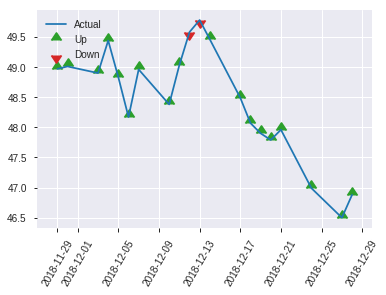


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.354388999904507
RMSE: 0.5953058036879088
LogLoss: 2.39245574440904
Mean Per-Class Error: 0.43145674300254455
AUC: 0.552735368956743
pr_auc: 0.5568923280341238
Gini: 0.10547073791348605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.5553257279532e-11: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      3    128  0.0229   (3.0/131.0)
Total  11   240  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.55533e-11  0.690027  239
max f2                       2.72102e-14  0.847348  248
max f0point5                 0.000116017  0.591054  201
max accuracy                 0.20314      0.569721  132
max precision                0.784436     0.727273  10
max recall                   2.72102e-14  1         248
max specificity              0.854331     0.991667  0
max absolute_mcc             0.20314      0.1372    132
max min_per_class_accuracy   0.243885     0.55      126
max mean_per_class_accuracy  0.20314      0.568543  132

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 28.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.836952           1.27735   1.27735            0.666667         0.848759     0.666667                    0.848759            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.821819           0.638677  0.958015           0.333333         0.827975     0.5                         0.838367            0.00763359      0.0229008                  -36.1323   -4.19847
    3        0.0318725                   0.788642           1.91603   1.19752            1                0.792907     0.625                       0.827002            0.0152672       0.0381679                  91.6031    19.7519
    4        0.0438247                   0.784436           1.91603   1.39348            1                0.785674     0.727273                    0.815731            0.0229008       0.0610687                  91.6031    39.3477
    5        0.0517928                   0.765578           0.958015  1.32648            0.5              0.774875     0.692308                    0.809445            0.00763359      0.0687023                  -4.19847   32.6483
    6        0.103586                    0.659836           0.736935  1.03171            0.384615         0.716333     0.538462                    0.762889            0.0381679       0.10687                    -26.3065   3.17087
    7        0.151394                    0.586065           1.27735   1.10928            0.666667         0.621419     0.578947                    0.718214            0.0610687       0.167939                   27.7354    10.9281
    8        0.203187                    0.527217           1.1791    1.12708            0.615385         0.558682     0.588235                    0.677549            0.0610687       0.229008                   17.9096    12.7077
    9        0.302789                    0.455002           0.996336  1.08407            0.52             0.482285     0.565789                    0.613317            0.0992366       0.328244                   -0.366412  8.40699
    10       0.40239                     0.388765           0.766412  1.00544            0.4              0.419609     0.524752                    0.56537             0.0763359       0.40458                    -23.3588   0.544177
    11       0.501992                    0.247195           1.45618   1.09487            0.76             0.324686     0.571429                    0.517615            0.145038        0.549618                   45.6183    9.48746
    12       0.601594                    0.100296           0.996336  1.07856            0.52             0.172014     0.562914                    0.460396            0.0992366       0.648855                   -0.366412  7.85602
    13       0.701195                    0.0242009          0.919695  1.05599            0.48             0.0563909    0.551136                    0.403009            0.0916031       0.740458                   -8.03053   5.59941
    14       0.800797                    0.000116571        0.996336  1.04857            0.52             0.00616319   0.547264                    0.35365             0.0992366       0.839695                   -0.366412  4.85739
    15       0.900398                    1.07691e-07        0.919695  1.03432            0.48             2.519e-05    0.539823                    0.314532            0.0916031       0.931298                   -8.03053   3.43174
    16       1                           3.12333e-15        0.689771  1                  0.

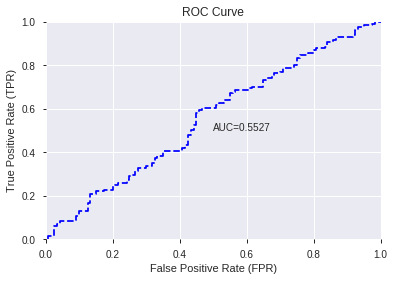

This function is available for GLM models only


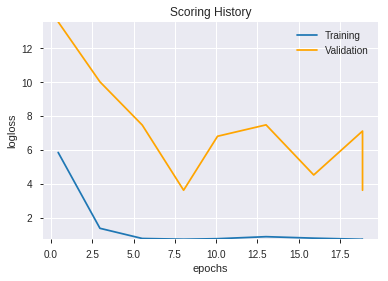

--2019-09-03 03:17:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024843_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024843_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_DCPERIOD',
 'CDLMORNINGDOJISTAR',
 'day',
 'TANH',
 'SIN',
 'HT_TRENDMODE',
 'COS',
 'OBV',
 'weekday_name',
 'CDLCOUNTERATTACK',
 'weekofyear',
 'CDLSTICKSANDWICH',
 'CDLLONGLEGGEDDOJI',
 'dayofweek',
 'BOP',
 'CDLUNIQUE3RIVER',
 'week',
 'CDL3WHITESOLDIERS',
 'DX_12',
 'ADXR_8',
 'aroonup_20',
 'CDLINNECK',
 'CDLDOJI',
 'dayofyear',
 'aroonup_8',
 'AROONOSC_8',
 'SAREXT',
 'weekday',
 'MFI_14',
 'quarter',
 'month',
 'STOCHRSI_fastd',
 'CORREL_14',
 'aroondown_30',
 'DX_8',
 'STOCHRSI_fastk',
 'aroondown_8',
 'days_in_month',
 'aroonup_14',
 'CDLONNECK',
 'aroonup_30',
 'MFI_8',
 'CDL3LINESTRIKE',
 'BETA_12',
 'aroondown_20',
 'Volume',
 'STOCHF_fastk',
 'BETA_8',
 'DX_14',
 'MFI_12',
 'MFI_20',
 'AROONOSC_30',
 'CDLSPINNINGTOP',
 'aroondown_12',
 'CDLRICKSHAWMAN',
 'aroonup_12',
 'aroondown_24',
 'CDLDARKCLOUDCOVER',
 'DX_30',
 'CORREL_12',
 'ADX_14',
 'CDLMORNINGSTAR',
 'AROONOSC_24',
 'CDLSTALLEDPATTERN',
 'DIV',
 'is_quarter_end',
 'CDLLONGLINE',
 'BETA_14',
 'AROONOSC_14',


In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031711_model_1  0.545929  6.957755              0.478117  0.685527  0.469947

variable  relative_importance  scaled_importance    percentage
0                          OBV         5.543301e-03           1.000000  1.007722e-02
1                       MFI_12         5.412297e-03           0.976367  9.839067e-03
2               CDLSPINNINGTOP         5.389864e-03           0.972320  9.798285e-03
3            CDLINVERTEDHAMMER         5.249486e-03           0.946996  9.543090e-03
4                          day         5.160818e-03           0.931001  9.381900e-03
...                        ...                  ...                ...           ...
1036  BBANDS_middleband_24_7_5         4.146504e-07           0.000075  7.537969e-07
1037   BBANDS_lowerband_12_6_5         3.795144e-07           0.000068  6.899229e-07
1038                   MA_30_0         3.382784e-07           0.000061  6.149596e-07
1039                    EMA_24         3.051705e-07           0.000055  5.547724e-07
1040  BBANDS_middleband_14_7_2         1.077064e-07           0.000019  1.958005e-07

[1041 rows x 4 columns]

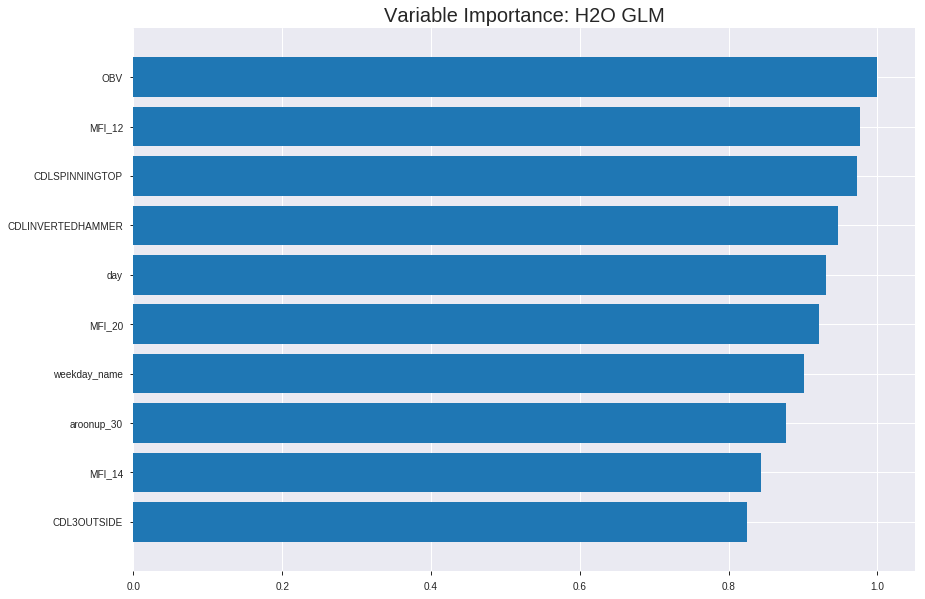

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031711_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24633367494497585
RMSE: 0.49632013352772203
LogLoss: 0.6857782038374226
Null degrees of freedom: 1753
Residual degrees of freedom: 712
Null deviance: 2426.732552703876
Residual deviance: 2405.7099390616786
AIC: 4489.709939061679
AUC: 0.5744648395789902
pr_auc: 0.590775056958388
Gini: 0.1489296791579804
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44256481076275783: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    822   0.9892   (822.0/831.0)
1      2    921   0.0022   (2.0/923.0)
Total  11   1743  0.4698   (824.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442565     0.690923  389
max f2                       0.434419     0.847722  397
max f0point5                 0.488869     0.588693  311
max accuracy                 0.5261       0.560433  195
max precision                0.62756      1         0
max recall                   0.434419     1         397
max specificity              0.62756      1         0
max absolute_mcc             0.539992     0.137912  146
max min_per_class_accuracy   0.529176     0.554753  184
max mean_per_class_accuracy  0.539453     0.566262  147

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.586543           1.16131   1.16131            0.611111         0.600803  0.611111                    0.600803            0.0119177       0.0119177                  16.131    16.131
    2        0.0205245                   0.58077            1.26688   1.2141             0.666667         0.583112  0.638889                    0.591957            0.0130011       0.0249187                  26.6883   21.4097
    3        0.0302166                   0.57598            1.34141   1.25493            0.705882         0.577891  0.660377                    0.587445            0.0130011       0.0379198                  34.1406   25.4932
    4        0.0404789                   0.573636           0.950163  1.17767            0.5              0.574851  0.619718                    0.584252            0.00975081      0.0476706                  -4.98375  17.7666
    5        0.050171                    0.571749           1.45319   1.23089            0.764706         0.572613  0.647727                    0.582004            0.0140845       0.0617551                  45.319    23.0892
    6        0.100342                    0.564023           1.27408   1.25249            0.670455         0.567627  0.659091                    0.574815            0.063922        0.125677                   27.4082   25.2487
    7        0.149943                    0.558473           1.04846   1.18499            0.551724         0.561259  0.623574                    0.570331            0.0520043       0.177681                   4.84552   18.4994
    8        0.200114                    0.552963           1.05814   1.15319            0.556818         0.555877  0.606838                    0.566707            0.0530878       0.230769                   5.81355   15.3189
    9        0.299886                    0.54475            1.21621   1.17416            0.64             0.54858   0.617871                    0.560676            0.121343        0.352113                   21.6208   17.4155
    10       0.400228                    0.536302           1.04734   1.14236            0.551136         0.540292  0.60114                     0.555566            0.105092        0.457205                   4.73382   14.2361
    11       0.5                         0.529227           0.97731   1.10943            0.514286         0.532876  0.583808                    0.551038            0.0975081       0.554713                   -2.269    10.9426
    12       0.599772                    0.521229           0.933874  1.08022            0.491429         0.525312  0.568441                    0.546759            0.0931744       0.647887                   -6.6126   8.02228
    13       0.700114                    0.510715           0.84219   1.04611            0.443182         0.516113  0.550489                    0.542366            0.084507        0.732394                   -15.781   4.61073
    14       0.799886                    0.499915           0.912156  1.0294             0.48             0.505692  0.541696                    0.537792            0.0910076       0.823402                   -8.7844   2.93992
    15       0.899658                    0.484123           0.933874  1.01881            0.491429         0.492798  0.536122                    0.532802            0.0931744       0.916576                   -6.6126   1.88054
    16       1                           0.424558           0.831392  1                  0.4375           0.467263  0.526226                    0.526226          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.35522838970223497
RMSE: 0.5960103939548663
LogLoss: 5.876865386054423
Null degrees of freedom: 501
Residual degrees of freedom: -540
Null deviance: 696.4627613688081
Residual deviance: 18667.53203499142
AIC: 20751.53203499142
AUC: 0.524791617051679
pr_auc: 0.5200001682654107
Gini: 0.049583234103357965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.8544610929230734e-28: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.85446e-28  0.673712   399
max f2                       1.85446e-28  0.837714   399
max f0point5                 1.24176e-23  0.565265   393
max accuracy                 0.506224     0.537849   116
max precision                0.547151     0.666667   5
max recall                   1.85446e-28  1          399
max specificity              0.555434     0.995951   0
max absolute_mcc             0.506224     0.0995964  116
max min_per_class_accuracy   0.470088     0.509804   250
max mean_per_class_accuracy  0.506224     0.542113   116

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 28.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.547145           1.31242   1.31242            0.666667         0.550642     0.666667                    0.550642            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.544871           0.393725  0.894831           0.2              0.545536     0.454545                    0.548321            0.00392157      0.0196078                  -60.6275  -10.5169
    3        0.0318725                   0.540557           0.393725  0.738235           0.2              0.542203     0.375                       0.546409            0.00392157      0.0235294                  -60.6275  -26.1765
    4        0.0418327                   0.538163           1.18118   0.843697           0.6              0.539062     0.428571                    0.54466             0.0117647       0.0352941                  18.1176   -15.6303
    5        0.0517928                   0.536402           0.393725  0.757164           0.2              0.537098     0.384615                    0.543206            0.00392157      0.0392157                  -60.6275  -24.2836
    6        0.101594                    0.523488           1.25992   1.00361            0.64             0.529177     0.509804                    0.536329            0.0627451       0.101961                   25.9922   0.361399
    7        0.151394                    0.51387            1.33867   1.11383            0.68             0.518358     0.565789                    0.530418            0.0666667       0.168627                   33.8667   11.3829
    8        0.201195                    0.509578           1.10243   1.11101            0.56             0.511671     0.564356                    0.525777            0.054902        0.223529                   10.2431   11.1008
    9        0.300797                    0.501393           1.06306   1.09513            0.54             0.505101     0.556291                    0.518931            0.105882        0.329412                   6.30588   9.51305
    10       0.400398                    0.486095           0.866196  1.03818            0.44             0.494534     0.527363                    0.512862            0.0862745       0.415686                   -13.3804  3.81816
    11       0.5                         0.469884           0.944941  1.01961            0.48             0.478751     0.517928                    0.506067            0.0941176       0.509804                   -5.50588  1.96078
    12       0.599602                    0.022469           1.02369   1.02029            0.52             0.346876     0.518272                    0.479623            0.101961        0.611765                   2.36863   2.02853
    13       0.699203                    1.70382e-10        1.10243   1.03199            0.56             0.00388032   0.524217                    0.411854            0.109804        0.721569                   10.2431   3.1987
    14       0.798805                    1.69836e-26        0.984314  1.02604            0.5              1.61761e-11  0.521197                    0.3605              0.0980392       0.819608                   -1.56863  2.60427
    15       0.898406                    2.28203e-52        0.944941  1.01705            0.48             3.74601e-28  0.51663                     0.320533            0.0941176       0.913725                   -5.50588  1.70514
    16       1                           0                  0.849212  1                  0.431373         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:17:15  0.000 sec   2            3.9       1042          1.37156           37.1863
    2019-09-03 03:17:17  2.171 sec   4            2.8       1042          1.36925           47.2326
    2019-09-03 03:17:20  4.337 sec   6            2         1042          1.3665            60.4256
    2019-09-03 03:17:22  6.562 sec   8            1.5       1042          1.36327           77.5937
    2019-09-03 03:17:24  8.771 sec   10           1.1       1042          1.35962           99.6663

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6900269541778976)

('auc', 0.5459287531806616)

('logloss', 6.957755029743077)

('mean_per_class_error', 0.4276717557251908)

('rmse', 0.6855267468372841)

('mse', 0.46994692062930987)

glm prediction progress: |████████████████████████████████████████████████| 100%


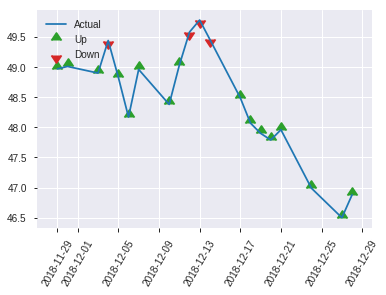


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.46994692062930987
RMSE: 0.6855267468372841
LogLoss: 6.957755029743077
Null degrees of freedom: 250
Residual degrees of freedom: -791
Null deviance: 347.49638460687265
Residual deviance: 4810.502501220276
AIC: 6894.502501220276
AUC: 0.5459287531806616
pr_auc: 0.5391976655172277
Gini: 0.09185750636132317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2375378895972292e-38: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      3    128  0.0229   (3.0/131.0)
Total  11   240  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.23754e-38  0.690027  239
max f2                       8.92574e-49  0.845161  246
max f0point5                 3.13196e-07  0.599473  156
max accuracy                 3.13196e-07  0.577689  156
max precision                0.516245     1         0
max recall                   8.92574e-49  1         246
max specificity              0.516245     1         0
max absolute_mcc             3.13196e-07  0.149297  156
max min_per_class_accuracy   4.12003e-05  0.533333  125
max mean_per_class_accuracy  3.13196e-07  0.572328  156

Gains/Lift Table: Avg response rate: 52.19 %, avg score:  8.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.504014           0.638677  0.638677           0.333333         0.510731     0.333333                    0.510731            0.00763359      0.00763359                 -36.1323   -36.1323
    2        0.0239044                   0.493686           1.91603   1.27735            1                0.497438     0.666667                    0.504084            0.0229008       0.0305344                  91.6031    27.7354
    3        0.0318725                   0.484516           0         0.958015           0                0.485317     0.5                         0.499393            0               0.0305344                  -100       -4.19847
    4        0.0438247                   0.483563           0.638677  0.870923           0.333333         0.483849     0.454545                    0.495153            0.00763359      0.0381679                  -36.1323   -12.9077
    5        0.0517928                   0.470971           0.958015  0.884322           0.5              0.477013     0.461538                    0.492363            0.00763359      0.0458015                  -4.19847   -11.5678
    6        0.103586                    0.433981           1.32648   1.1054             0.692308         0.452396     0.576923                    0.472379            0.0687023       0.114504                   32.6483    10.5402
    7        0.151394                    0.228144           0.479008  0.907593           0.25             0.366031     0.473684                    0.438796            0.0229008       0.137405                   -52.0992   -9.24066
    8        0.203187                    0.116428           1.32648   1.01437            0.692308         0.160527     0.529412                    0.367864            0.0687023       0.206107                   32.6483    1.43691
    9        0.302789                    0.0235286          1.07298   1.03365            0.56             0.0566845    0.539474                    0.265503            0.10687         0.312977                   7.29771    3.36481
    10       0.40239                     0.00161507         0.996336  1.02441            0.52             0.00597916   0.534653                    0.201264            0.0992366       0.412214                   -0.366412  2.44124
    11       0.501992                    4.12003e-05        1.22626   1.06446            0.64             0.000360679  0.555556                    0.161402            0.122137        0.534351                   22.626     6.44614
    12       0.601594                    6.37856e-07        1.22626   1.09125            0.64             1.26913e-05  0.569536                    0.134682            0.122137        0.656489                   22.626     9.12492
    13       0.701195                    2.11169e-09        0.996336  1.07777            0.52             1.52338e-07  0.5625                      0.115551            0.0992366       0.755725                   -0.366412  7.77672
    14       0.800797                    7.49414e-17        0.843053  1.04857            0.44             3.91269e-10  0.547264                    0.101179            0.0839695       0.839695                   -15.6947   4.85739
    15       0.900398                    7.97534e-28        0.919695  1.03432            0.48             3.56361e-18  0.539823                    0.0899868           0.0916031       0.931298                   -8.03053   3.43174
    16       1                           3.83013e-54        0.689771  1                 

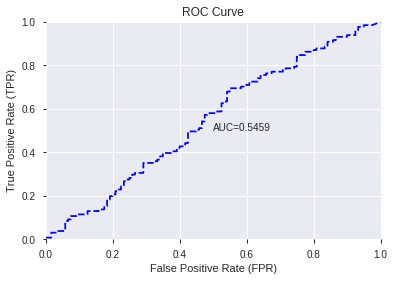

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


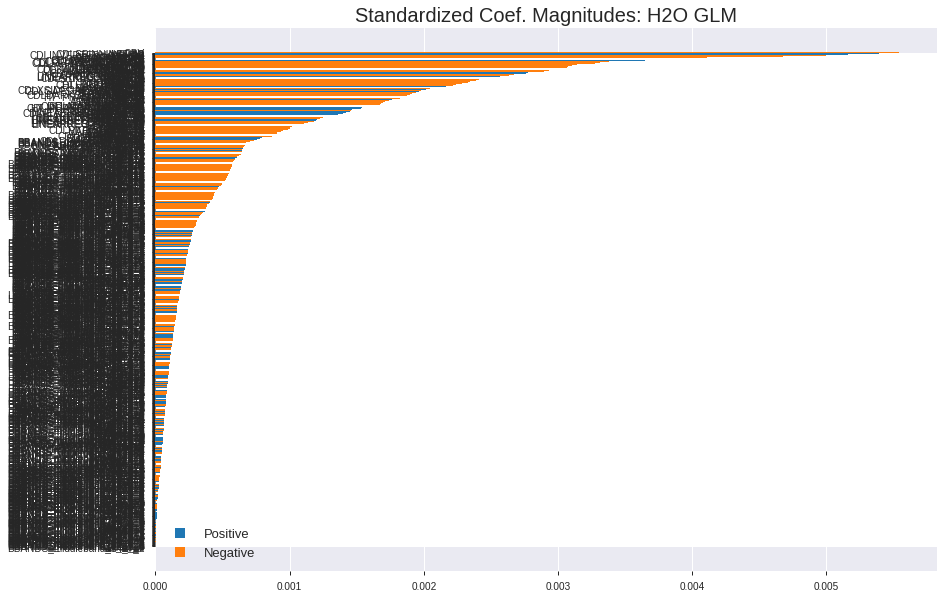

'log_likelihood'
--2019-09-03 03:17:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031711_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031711_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['OBV',
 'MFI_12',
 'CDLSPINNINGTOP',
 'CDLINVERTEDHAMMER',
 'day',
 'MFI_20',
 'weekday_name',
 'aroonup_30',
 'MFI_14',
 'CDL3OUTSIDE',
 'AROONOSC_20',
 'MFI_8',
 'SAREXT',
 'TAN',
 'aroonup_20',
 'CDLHARAMICROSS',
 'HT_DCPERIOD',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'CDLSEPARATINGLINES',
 'BOP',
 'CDLHARAMI',
 'MFI_24',
 'AROONOSC_30',
 'aroonup_24',
 'aroondown_20',
 'aroonup_14',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'CDL3LINESTRIKE',
 'CDL3WHITESOLDIERS',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'TANH',
 'DX_12',
 'TRANGE',
 'DX_14',
 'AROONOSC_14',
 'CDLMORNINGSTAR',
 'week',
 'SUB',
 'ULTOSC',
 'weekofyear',
 'MFI_30',
 'LINEARREG_SLOPE_8',
 'CDLLONGLINE',
 'LINEARREG_ANGLE_8',
 'dayofyear',
 'CDLINNECK',
 'CDLSTICKSANDWICH',
 'BETA_30',
 'RSI_8',
 'BETA_24',
 'DX_8',
 'RSI_12',
 'CMO_8',
 'CMO_12',
 'CMO_14',
 'RSI_14',
 'dayofweek',
 'weekday',
 'MOM_8',
 'CDLHIKKAKE',
 'HT_TRENDMODE',
 'DX_20',
 'CDLHANGINGMAN',
 'MACDEXT_hist',
 'CMO_20',
 'month',
 '

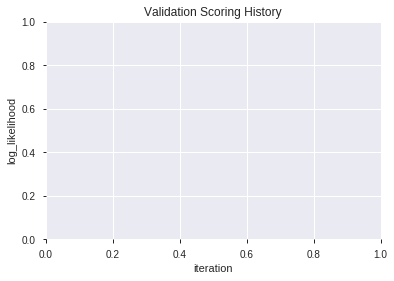

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031759_model_4  0.562341  0.685760              0.469784  0.496343  0.246357
1  XGBoost_grid_1_AutoML_20190903_031759_model_6  0.554008  0.706528              0.495833  0.506390  0.256430
2               XGBoost_2_AutoML_20190903_031759  0.547710  0.701857              0.491667  0.504043  0.254059
3               XGBoost_3_AutoML_20190903_031759  0.547265  0.697661              0.495483  0.501991  0.251995
4               XGBoost_1_AutoML_20190903_031759  0.545547  0.707394              0.495833  0.506752  0.256798
5  XGBoost_grid_1_AutoML_20190903_031759_model_1  0.533779  0.711489              0.486450  0.508431  0.258502
6  XGBoost_grid_1_AutoML_20190903_031759_model_5  0.526081  0.746865              0.491667  0.523957  0.274531
7  XGBoost_grid_1_AutoML_20190903_031759_model_2  0.524173  0.697811              0.495833  0.502215  0.252220
8  XGBoost_grid_1_AutoML_20190903_031759_model_3  0.522964  0.732850              0.472901  0.518240  0.268573
9  XGBoost_grid_1_AutoML_20190903_031759_model_7  0.520611  0.721640              0.500000  0.513146  0.263319

variable  relative_importance  scaled_importance  percentage
0                        OBV           156.012787           1.000000    0.044699
1                        TAN           137.678604           0.882483    0.039446
2                    ADXR_14            94.335854           0.604667    0.027028
3                     MFI_12            85.245598           0.546401    0.024423
4                        day            75.978485           0.487002    0.021768
..                       ...                  ...                ...         ...
164              AROONOSC_30             5.747115           0.036837    0.001647
165  BBANDS_lowerband_14_4_2             5.592158           0.035844    0.001602
166       LINEARREG_ANGLE_14             5.532948           0.035465    0.001585
167             STOCHF_fastk             5.118376           0.032807    0.001466
168                   MOM_12             4.970442           0.031859    0.001424

[169 rows x 4 columns]

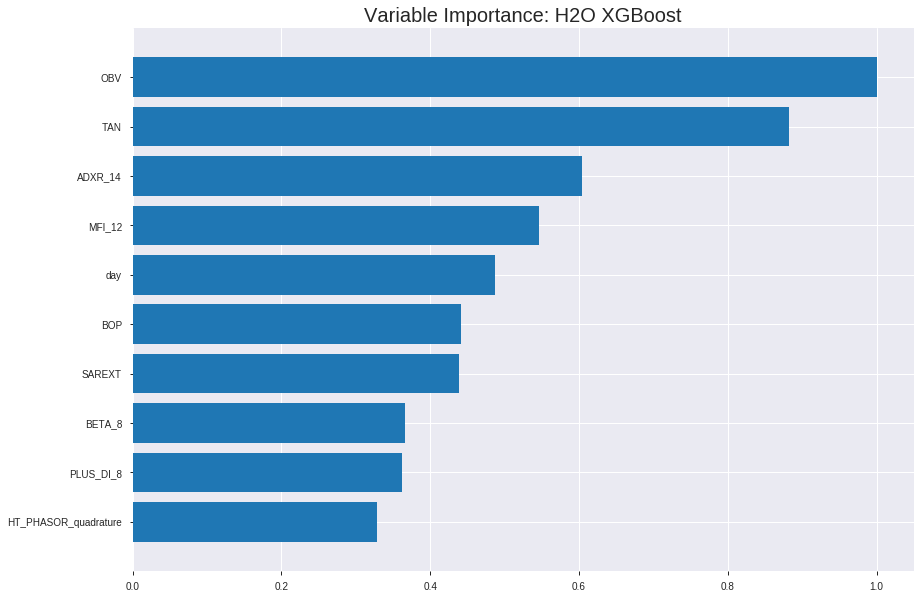

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031759_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21123441460287623
RMSE: 0.45960245278161455
LogLoss: 0.614065066695122
Mean Per-Class Error: 0.2597446197130948
AUC: 0.8211686112230171
pr_auc: 0.839225378474693
Gini: 0.6423372224460342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48118557780981064: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  383   0.4609   (383.0/831.0)
1      110  813   0.1192   (110.0/923.0)
Total  558  1196  0.2811   (493.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481186     0.767343  250
max f2                       0.4231       0.866285  324
max f0point5                 0.53782      0.770115  169
max accuracy                 0.507133     0.738883  210
max precision                0.743983     1         0
max recall                   0.373325     1         371
max specificity              0.743983     1         0
max absolute_mcc             0.53782      0.483415  169
max min_per_class_accuracy   0.51728      0.735259  197
max mean_per_class_accuracy  0.531488     0.740255  178

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.692738           1.90033   1.90033            1                0.706913  1                           0.706913            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.677601           1.90033   1.90033            1                0.684842  1                           0.695878            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.666898           1.90033   1.90033            1                0.670977  1                           0.687891            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.660032           1.79475   1.87356            0.944444         0.663514  0.985915                    0.681711            0.0184182       0.0758397                  79.4751   87.356
    5        0.050171                    0.65286            1.90033   1.87873            1                0.656113  0.988636                    0.676766            0.0184182       0.0942579                  90.0325   87.873
    6        0.100342                    0.626476           1.79235   1.83554            0.943182         0.639567  0.965909                    0.658166            0.0899242       0.184182                   79.2352   83.5541
    7        0.149943                    0.610937           1.63821   1.77026            0.862069         0.61807   0.931559                    0.644902            0.0812568       0.265439                   63.8211   77.0265
    8        0.200114                    0.596986           1.68438   1.74873            0.886364         0.604427  0.920228                    0.634755            0.084507        0.349946                   68.4379   74.8732
    9        0.299886                    0.569123           1.33566   1.6113             0.702857         0.583307  0.847909                    0.617638            0.133261        0.483207                   33.5657   61.1302
    10       0.400228                    0.543799           1.34966   1.54571            0.710227         0.555979  0.81339                     0.602179            0.135428        0.618635                   34.9663   54.5706
    11       0.5                         0.519891           1.02075   1.44095            0.537143         0.531632  0.758267                    0.588102            0.101842        0.720477                   2.0746    44.0953
    12       0.599772                    0.498966           0.944733  1.35841            0.497143         0.509518  0.714829                    0.575029            0.0942579       0.814735                   -5.5267   35.8407
    13       0.700114                    0.475677           0.734216  1.26895            0.386364         0.487796  0.667752                    0.562527            0.0736728       0.888407                   -26.5784  26.8947
    14       0.799886                    0.446823           0.608104  1.18652            0.32             0.461928  0.624376                    0.549979            0.0606717       0.949079                   -39.1896  18.6518
    15       0.899658                    0.415881           0.390924  1.09829            0.205714         0.431039  0.577947                    0.536789            0.0390033       0.988082                   -60.9076  9.82867
    16       1                           0.281908           0.11877   1                  0.0625           0.385162  0.526226                    0.521574           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25497716763202294
RMSE: 0.5049526389989688
LogLoss: 0.7034940686861555
Mean Per-Class Error: 0.4790823211875843
AUC: 0.5062554576486465
pr_auc: 0.5079360949889227
Gini: 0.01251091529729309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37902867794036865: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.379029     0.673712   399
max f2                       0.379029     0.837714   399
max f0point5                 0.379029     0.563411   399
max accuracy                 0.489397     0.51992    317
max precision                0.650686     0.55       18
max recall                   0.379029     1          399
max specificity              0.708762     0.995951   0
max absolute_mcc             0.389195     0.0987155  394
max min_per_class_accuracy   0.544908     0.509804   198
max mean_per_class_accuracy  0.56922      0.520918   131

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 54.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.670887           0.328105  0.328105           0.166667         0.687824  0.166667                    0.687824            0.00392157      0.00392157                 -67.1895  -67.1895
    2        0.0219124                   0.656105           1.5749    0.894831           0.8              0.661134  0.454545                    0.675692            0.0156863       0.0196078                  57.4902   -10.5169
    3        0.0318725                   0.65424            1.18118   0.984314           0.6              0.654631  0.5                         0.66911             0.0117647       0.0313725                  18.1176   -1.56863
    4        0.0418327                   0.65042            1.18118   1.03119            0.6              0.651244  0.52381                     0.664857            0.0117647       0.0431373                  18.1176   3.11858
    5        0.0517928                   0.644858           0.787451  0.984314           0.4              0.648254  0.5                         0.661664            0.00784314      0.0509804                  -21.2549  -1.56863
    6        0.101594                    0.620376           1.02369   1.00361            0.52             0.630847  0.509804                    0.646558            0.0509804       0.101961                   2.36863   0.361399
    7        0.151394                    0.604777           1.18118   1.06202            0.6              0.612473  0.539474                    0.635345            0.0588235       0.160784                   18.1176   6.20227
    8        0.201195                    0.592546           0.629961  0.955077           0.32             0.599867  0.485149                    0.626564            0.0313725       0.192157                   -37.0039  -4.49233
    9        0.300797                    0.571323           1.25992   1.05602            0.64             0.581218  0.536424                    0.611549            0.12549         0.317647                   25.9922   5.60187
    10       0.400398                    0.555841           0.944941  1.02839            0.48             0.56273   0.522388                    0.599405            0.0941176       0.411765                   -5.50588  2.83875
    11       0.5                         0.54409            0.984314  1.01961            0.5              0.550404  0.517928                    0.589644            0.0980392       0.509804                   -1.56863  1.96078
    12       0.599602                    0.527724           0.905569  1.00066            0.46             0.536667  0.508306                    0.580844            0.0901961       0.6                        -9.44314  0.0664452
    13       0.699203                    0.510119           1.02369   1.00394            0.52             0.519342  0.509972                    0.572083            0.101961        0.701961                   2.36863   0.394391
    14       0.798805                    0.494878           0.984314  1.0015             0.5              0.502235  0.508728                    0.563374            0.0980392       0.8                        -1.56863  0.149626
    15       0.898406                    0.463786           0.905569  0.990861           0.46             0.481949  0.503326                    0.554346            0.0901961       0.890196                   -9.44314  -0.913873
    16       1                           0.379029           1.08082   1                  0.54902          0.432848  0.507968                    0.542


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:18:30  13.469 sec  0                  0.5              0.693147            0.5             0                  1                0.473774                         0.5                0.693147              0.5               0                    1                  0.492032
    2019-09-03 03:18:31  14.754 sec  5                  0.493738         0.680687            0.699006        0.700956           1.47803          0.369441                         0.500569           0.694286              0.481694          0.521932             1.6107             0.492032
    2019-09-03 03:18:32  15.137 sec  10                 0.488212         0.669766            0.720747        0.72712            1.5836           0.341505                         0.500881           0.694919              0.493443          0.498381             0.984314           0.49004
    2019-09-03 03:18:32  15.520 sec  15                 0.483038         0.659584            0.742166        0.748009           1.5836           0.332383                         0.501432           0.69603               0.48633           0.493388             0.984314           0.492032
    2019-09-03 03:18:33  15.916 sec  20                 0.478901         0.651442            0.74971         0.757274           1.68918          0.340365                         0.502284           0.697775              0.488577          0.494838             0.656209           0.492032
    2019-09-03 03:18:33  16.300 sec  25                 0.475293         0.644396            0.765512        0.774729           1.90033          0.335804                         0.503002           0.69926               0.489045          0.492875             0.656209           0.492032
    2019-09-03 03:18:33  16.705 sec  30                 0.472789         0.639494            0.770941        0.783493           1.90033          0.332953                         0.503237           0.699815              0.495586          0.494795             0.328105           0.492032
    2019-09-03 03:18:34  17.117 sec  35                 0.469537         0.633132            0.780817        0.793394           1.90033          0.327252                         0.503307           0.700063              0.506898          0.496069             0                  0.49004
    2019-09-03 03:18:34  17.535 sec  40                 0.467185         0.628641            0.796327        0.815044           1.90033          0.304447                         0.504161           0.701736              0.497047          0.501713             0.656209           0.488048
    2019-09-03 03:18:35  17.956 sec  45                 0.464691         0.62372             0.80228         0.815735           1.90033          0.293044                         0.504377           0.702348              0.512662          0.505682             0.656209           0.492032
    2019-09-03 03:18:35  18.360 sec  50                 0.459602         0.614065            0.821169        0.839225           1.90033          0.281072                         0.504953           0.703494              0.506255          0.507936             0.328105           0.492032

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
OBV                      156.01278686523438     1.0                   0.044698808735566795
TAN                      137.67860412597656     0.882482820109514     0.03944593078849876
ADXR_14                  94.33585357666016      0.6046674472788474    0.027027914574540617
MFI_12                   85.24559783935547      0.546401353069807     0.024423489573722205
day                      75.97848510742188      0.48700165309560783   0.021768393745625426
---                      ---                    ---                   ---
AROONOSC_30              5.747114658355713      0.03683745912006646   0.0016465905395121113
BBANDS_lowerband_14_4_2  5.592158317565918      0.035844230655250636  0.0016021944103325884
LINEARREG_ANGLE_14       5.532948017120361      0.03546470855558644   0.0015852302245887777
STOCHF_fastk             5.118375778198242      0.0328074120143726    0.001466452234739377
MOM_12                   4.970441818237305      0.03185919512181286   0.0014240680692190158


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6937669376693767)

('auc', 0.5623409669211196)

('logloss', 0.685759925494409)

('mean_per_class_error', 0.4462786259541984)

('rmse', 0.49634328202647293)

('mse', 0.24635665361281087)

xgboost prediction progress: |████████████████████████████████████████████| 100%


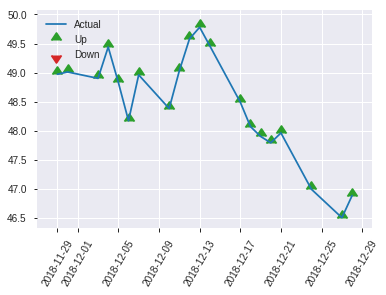


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24635665361281087
RMSE: 0.49634328202647293
LogLoss: 0.685759925494409
Mean Per-Class Error: 0.4462786259541984
AUC: 0.5623409669211196
pr_auc: 0.5822350868487306
Gini: 0.12468193384223913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4566209018230438: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   110  0.9167   (110.0/120.0)
1      3    128  0.0229   (3.0/131.0)
Total  13   238  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456621     0.693767  237
max f2                       0.441524     0.848446  247
max f0point5                 0.477428     0.592705  213
max accuracy                 0.477428     0.557769  213
max precision                0.642639     0.857143  6
max recall                   0.441524     1         247
max specificity              0.654397     0.991667  0
max absolute_mcc             0.614783     0.138115  22
max min_per_class_accuracy   0.53739      0.525     125
max mean_per_class_accuracy  0.579971     0.553721  57

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.652937           1.27735   1.27735            0.666667         0.653921  0.666667                    0.653921            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.64541            1.91603   1.59669            1                0.648958  0.833333                    0.65144             0.0229008       0.0381679                  91.6031    59.6692
    3        0.0318725                   0.642037           0.958015  1.43702            0.5              0.642567  0.75                        0.649221            0.00763359      0.0458015                  -4.19847   43.7023
    4        0.0438247                   0.636961           1.27735   1.39348            0.666667         0.638634  0.727273                    0.646334            0.0152672       0.0610687                  27.7354    39.3477
    5        0.0517928                   0.633111           0.958015  1.32648            0.5              0.635295  0.692308                    0.644636            0.00763359      0.0687023                  -4.19847   32.6483
    6        0.103586                    0.613411           1.32648   1.32648            0.692308         0.620601  0.692308                    0.632618            0.0687023       0.137405                   32.6483    32.6483
    7        0.151394                    0.595779           0.798346  1.1597             0.416667         0.603177  0.605263                    0.623321            0.0381679       0.175573                   -20.1654   15.9703
    8        0.203187                    0.584068           1.1791    1.16465            0.615385         0.589621  0.607843                    0.614731            0.0610687       0.236641                   17.9096    16.4646
    9        0.302789                    0.567874           0.843053  1.05886            0.44             0.576679  0.552632                    0.602214            0.0839695       0.320611                   -15.6947   5.8859
    10       0.40239                     0.551318           1.22626   1.10029            0.64             0.557655  0.574257                    0.591184            0.122137        0.442748                   22.626     10.0295
    11       0.501992                    0.53739            0.843053  1.04925            0.44             0.544346  0.547619                    0.581891            0.0839695       0.526718                   -15.6947   4.92548
    12       0.601594                    0.521415           1.07298   1.05318            0.56             0.529769  0.549669                    0.573262            0.10687         0.633588                   7.29771    5.31823
    13       0.701195                    0.504502           0.996336  1.04511            0.52             0.513079  0.545455                    0.564713            0.0992366       0.732824                   -0.366412  4.51076
    14       0.800797                    0.487634           0.996336  1.03904            0.52             0.496844  0.542289                    0.556271            0.0992366       0.832061                   -0.366412  3.90414
    15       0.900398                    0.462526           0.919695  1.02584            0.48             0.476634  0.535398                    0.547462            0.0916031       0.923664                   -8.03053   2.58394
    16       1                           0.433514           0.766412  1                  0.4              0.452463  0.521912                    0

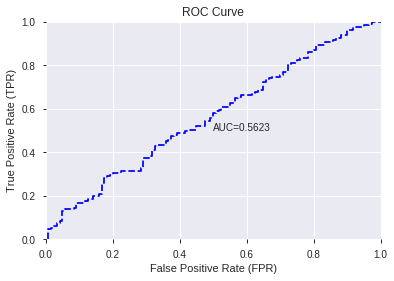

This function is available for GLM models only


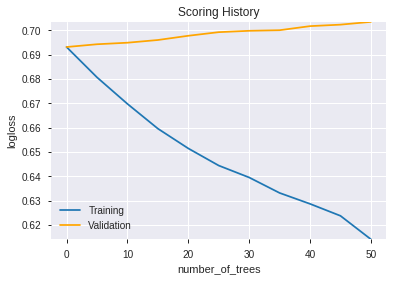

--2019-09-03 03:19:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031759_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031759_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'TAN',
 'ADXR_14',
 'MFI_12',
 'day',
 'BOP',
 'SAREXT',
 'BETA_8',
 'PLUS_DI_8',
 'HT_PHASOR_quadrature',
 'MINUS_DM_8',
 'CORREL_24',
 'STOCHRSI_fastk',
 'MINUS_DM_12',
 'DIV',
 'DX_12',
 'NATR_8',
 'MFI_20',
 'ULTOSC',
 'BETA_30',
 'Volume',
 'CCI_8',
 'TRIX_8',
 'MINUS_DI_30',
 'MINUS_DM_14',
 'DX_24',
 'aroonup_20',
 'NATR_12',
 'SUB',
 'aroonup_14',
 'MFI_24',
 'PLUS_DI_14',
 'MACDFIX_hist_20',
 'CORREL_20',
 'HT_PHASOR_inphase',
 'ADX_20',
 'CMO_14',
 'CCI_20',
 'STDDEV_24',
 'DX_20',
 'weekday_name',
 'STOCHRSI_fastd',
 'MACDEXT_hist',
 'MFI_8',
 'ROC_30',
 'STDDEV_12',
 'MACDFIX_signal_20',
 'MINUS_DI_14',
 'MOM_30',
 'ROC_20',
 'MACDFIX_8',
 'LINEARREG_ANGLE_24',
 'ROC_14',
 'STDDEV_8',
 'aroondown_20',
 'LINEARREG_ANGLE_8',
 'ADXR_8',
 'PLUS_DI_12',
 'ATR_14',
 'SIN',
 'MFI_14',
 'aroondown_14',
 'BBANDS_upperband_12_2_5',
 'ATR_8',
 'CDLSPINNINGTOP',
 'BBANDS_upperband_14_6_5',
 'MFI_30',
 'AROONOSC_20',
 'MINUS_DM_20',
 'MINUS_DI_20',
 'BBANDS_lowerband_20_3_5',
 

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

355

['BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_upperband_14_2_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'MA_14_3',
 'MAVP_14_3',
 'BBANDS_upperband_14_3_2',
 'BBANDS_middleband_14_3_2',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_middleband_14_3_4',
 'BBANDS_lowerband_14_3_4',
 'BBANDS_upperband_14_3_5',
 'BBANDS_middleband_14_3_5',
 'BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'MAVP_14_4',
 'BBANDS_middleband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_4_3',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_14_4_5',
 'BBANDS_middle

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_032018_model_1  0.530916  3.755547              0.482634  0.688721  0.474336
1               DeepLearning_1_AutoML_20190903_032018  0.530025  2.481791              0.474300  0.706572  0.499244
2  DeepLearning_grid_1_AutoML_20190903_032018_model_9  0.510687  0.692717              0.470134  0.499785  0.249785
3  DeepLearning_grid_1_AutoML_20190903_032018_model_2  0.506934  2.341461              0.500000  0.676556  0.457728
4  DeepLearning_grid_1_AutoML_20190903_032018_model_7  0.505153  0.709706              0.500000  0.507872  0.257934
5  DeepLearning_grid_1_AutoML_20190903_032018_model_8  0.500000  0.692655              0.500000  0.499754  0.249754
6  DeepLearning_grid_1_AutoML_20190903_032018_model_5  0.500000  0.692571              0.500000  0.499712  0.249712
7  DeepLearning_grid_1_AutoML_20190903_032018_model_4  0.491476  0.982275              0.495833  0.579305  0.335595
8  DeepLearning_grid_1_AutoML_20190903_032018_model_3  0.490967  0.807819              0.495833  0.543694  0.295604
9  DeepLearning_grid_1_AutoML_20190903_032018_model_6  0.485433  0.692542              0.500000  0.499697  0.249697

variable  relative_importance  scaled_importance  percentage
0                         OBV             1.000000           1.000000    0.003930
1          CDLMORNINGDOJISTAR             0.928994           0.928994    0.003651
2           CDLSTALLEDPATTERN             0.867632           0.867632    0.003410
3           CDLINVERTEDHAMMER             0.862407           0.862407    0.003389
4                CDLTHRUSTING             0.858936           0.858936    0.003376
..                        ...                  ...                ...         ...
349   BBANDS_lowerband_14_6_3             0.655935           0.655935    0.002578
350                   ROCP_14             0.654348           0.654348    0.002572
351                 CORREL_14             0.653663           0.653663    0.002569
352   BBANDS_upperband_30_0_3             0.651350           0.651350    0.002560
353  BBANDS_middleband_14_3_3             0.621768           0.621768    0.002444

[354 rows x 4 columns]

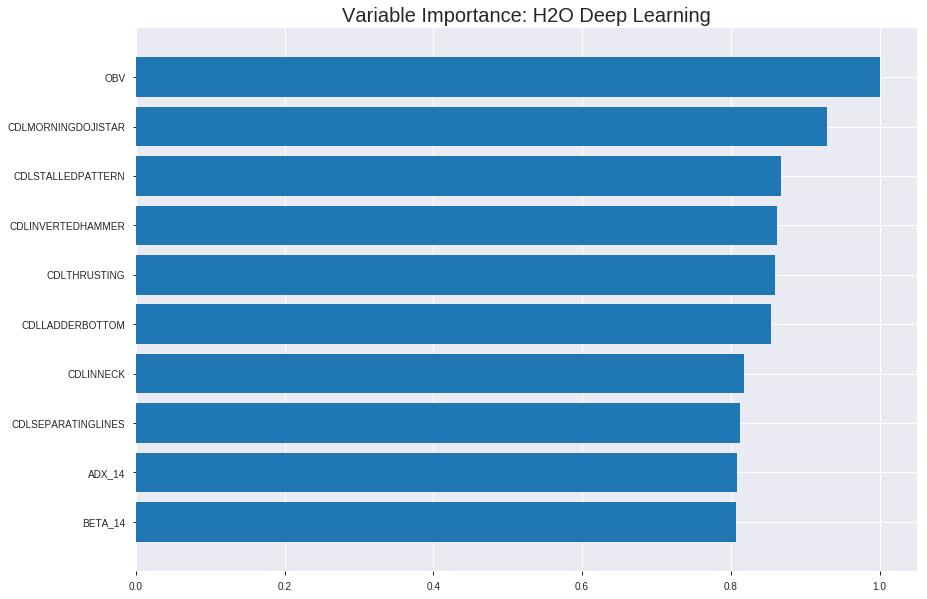

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_032018_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.37690165153870325
RMSE: 0.6139231641978524
LogLoss: 3.779876468740174
Mean Per-Class Error: 0.3978654859826365
AUC: 0.6102595392776915
pr_auc: 0.410463098867685
Gini: 0.220519078555383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.53798229544764e-05: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    831   1        (831.0/831.0)
1      0    923   0        (0.0/923.0)
Total  0    1754  0.4738   (831.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.53798e-05  0.689578  399
max f2                       1.53798e-05  0.847411  399
max f0point5                 0.983938     0.615496  30
max accuracy                 0.997544     0.596351  8
max precision                0.998086     0.656848  7
max recall                   1.53798e-05  1         399
max specificity              0.999997     0.807461  0
max absolute_mcc             0.997544     0.208631  8
max min_per_class_accuracy   0.94052      0.586132  63
max mean_per_class_accuracy  0.997544     0.602135  8

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 61.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0171038                   1                  1.1402    1.1402             0.6              1            0.6                         1                   0.0195016       0.0195016                  14.0195   14.0195
    2        0.0205245                   1                  0.950163  1.10852            0.5              1            0.583333                    1                   0.00325027      0.0227519                  -4.98375  10.8523
    3        0.0302166                   1                  1.34141   1.18322            0.705882         1            0.622642                    1                   0.0130011       0.035753                   34.1406   18.3221
    4        0.0404789                   1                  1.05574   1.1509             0.555556         1            0.605634                    1                   0.0108342       0.0465872                  5.57361   15.0901
    5        0.050171                    1                  1.22962   1.16611            0.647059         1            0.613636                    1                   0.0119177       0.0585049                  22.9622   16.6109
    6        0.100342                    1                  1.23089   1.1985             0.647727         1            0.630682                    1                   0.0617551       0.12026                    23.0892   19.85
    7        0.149943                    1                  1.11398   1.17054            0.586207         1            0.61597                     1                   0.0552546       0.175515                   11.3984   17.0542
    8        0.200114                    0.999998           1.1877    1.17484            0.625            0.999999     0.618234                    1                   0.0595883       0.235103                   18.7703   17.4845
    9        0.299886                    0.999804           1.3248    1.22473            0.697143         0.999951     0.644487                    0.999984            0.132178        0.367281                   32.4798   22.4734
    10       0.400228                    0.99692            1.27408   1.23711            0.670455         0.998933     0.650997                    0.99972             0.127844        0.495125                   27.4082   23.7106
    11       0.5                         0.94654            0.879579  1.16576            0.462857         0.982033     0.613455                    0.996191            0.0877573       0.582882                   -12.0421  16.5764
    12       0.599772                    0.598107           0.923015  1.12538            0.485714         0.82133      0.592205                    0.967103            0.092091        0.674973                   -7.6985   12.5383
    13       0.700114                    0.103332           0.917771  1.09563            0.482955         0.311052     0.576547                    0.873076            0.092091        0.767064                   -8.22294  9.56271
    14       0.799886                    0.00701182         0.76013   1.05378            0.4              0.0375311    0.554526                    0.768856            0.0758397       0.842904                   -23.987   5.37797
    15       0.899658                    6.60528e-05        0.814425  1.02724            0.428571         0.00172742   0.540558                    0.683782            0.0812568       0.92416                    -18.5575  2.72353
    16       1                           4.80616e-22        0.755811  1                  0.397727         8.5988



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.44230708661752144
RMSE: 0.6650617163974494
LogLoss: 3.6800432790157043
Mean Per-Class Error: 0.4646661903627848
AUC: 0.525394935302056
pr_auc: 0.5265208453936648
Gini: 0.05078987060411211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.3883978604163336e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    255  0        (0.0/255.0)
Total  0    502  0.492    (247.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.3884e-08   0.673712  399
max f2                       2.3884e-08   0.837714  399
max f0point5                 2.3884e-08   0.563411  399
max accuracy                 0.000909841  0.535857  320
max precision                0.868337     0.607143  55
max recall                   2.3884e-08   1         399
max specificity              0.999866     0.995951  0
max absolute_mcc             0.0314021    0.071876  204
max min_per_class_accuracy   0.00692339   0.509804  250
max mean_per_class_accuracy  0.0314021    0.535334  204

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 20.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.996582           0.984314  0.984314           0.5              0.998412     0.5                         0.998412            0.0117647       0.0117647                  -1.56863  -1.56863
    2        0.0219124                   0.993254           1.18118   1.0738             0.6              0.99534      0.545455                    0.997016            0.0117647       0.0235294                  18.1176   7.37968
    3        0.0318725                   0.983043           0.393725  0.861275           0.2              0.987377     0.4375                      0.994004            0.00392157      0.027451                   -60.6275  -13.8725
    4        0.0418327                   0.977416           1.5749    1.03119            0.8              0.979836     0.52381                     0.99063             0.0156863       0.0431373                  57.4902   3.11858
    5        0.0517928                   0.973133           1.18118   1.06003            0.6              0.974602     0.538462                    0.987548            0.0117647       0.054902                   18.1176   6.00302
    6        0.101594                    0.892766           1.25992   1.15802            0.64             0.944663     0.588235                    0.966526            0.0627451       0.117647                   25.9922   15.8016
    7        0.151394                    0.738896           0.787451  1.03612            0.4              0.815024     0.526316                    0.91669             0.0392157       0.156863                   -21.2549  3.61197
    8        0.201195                    0.534469           1.10243   1.05253            0.56             0.639562     0.534653                    0.848094            0.054902        0.211765                   10.2431   5.25335
    9        0.300797                    0.114892           1.10243   1.06906            0.56             0.266512     0.543046                    0.655517            0.109804        0.321569                   10.2431   6.9056
    10       0.400398                    0.0338466          1.06306   1.06756            0.54             0.0665386    0.542289                    0.509005            0.105882        0.427451                   6.30588   6.75641
    11       0.5                         0.00689483         0.826824  1.01961            0.42             0.0171297    0.517928                    0.411022            0.0823529       0.509804                   -17.3176  1.96078
    12       0.599602                    0.00230577         1.18118   1.04645            0.6              0.00427407   0.531561                    0.343456            0.117647        0.627451                   18.1176   4.64465
    13       0.699203                    0.000262055        0.866196  1.02077            0.44             0.000907524  0.518519                    0.29466             0.0862745       0.713725                   -13.3804  2.07698
    14       0.798805                    2.65885e-05        0.944941  1.01131            0.48             0.000124055  0.513716                    0.257935            0.0941176       0.807843                   -5.50588  1.13149
    15       0.898406                    1.8682e-07         0.866196  0.995226           0.44             9.36365e-06  0.505543                    0.22934             0.0862745       0.894118                   -13.3804  -0.477371
    16       1                           5.87831e-27        1.04221   1                  0.529412         1


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:20:19  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:20:22  3.253 sec   616 obs/sec       1         1             1754       0.662801         6.80739             -0.762066      0.557569        0.352507           1.2093           0.473774                         0.712706           15.0392               -1.03231         0.520124          0.524827             1.64052            0.492032
    2019-09-03 03:20:28  8.968 sec   639 obs/sec       3         3             5262       0.652454         6.41751             -0.70748       0.565673        0.380428           1.12292          0.473774                         0.712719           15.6395               -1.03239         0.514488          0.523126             0.984314           0.492032
    2019-09-03 03:20:33  14.433 sec  656 obs/sec       5         5             8770       0.656196         6.37476             -0.727123      0.565336        0.364257           1.07198          0.473774                         0.712718           14.6625               -1.03239         0.51567           0.528743             1.31242            0.492032
    2019-09-03 03:20:39  19.827 sec  666 obs/sec       7         7             12278      0.639512         5.35016             -0.640415      0.583412        0.368256           1.0272           0.473774                         0.710473           11.2337               -1.0196          0.524022          0.526809             0.984314           0.492032
    2019-09-03 03:20:44  25.158 sec  674 obs/sec       9         9             15786      0.63097          4.36445             -0.596885      0.592527        0.397551           1.29568          0.473774                         0.702354           7.48135               -0.973703        0.520957          0.530497             0.984314           0.492032
    2019-09-03 03:20:50  30.494 sec  680 obs/sec       11        11            19294      0.623463         4.31586             -0.559116      0.598397        0.373108           1.03161          0.473774                         0.687963           5.95008               -0.893653        0.525879          0.532                0.984314           0.492032
    2019-09-03 03:20:55  35.836 sec  683 obs/sec       13        13            22802      0.613923         3.77988             -0.511766      0.61026         0.410463           1.1402           0.473774                         0.665062           3.68004               -0.769678        0.525395          0.526521             0.984314           0.492032
    2019-09-03 03:21:00  41.089 sec  687 obs/sec       15        15            26310      0.608349         3.73948             -0.48444       0.610432        0.389398           1.04211          0.473774                         0.659235           3.83626               -0.738803        0.520275          0.528251             0.984314           0.492032
    2019-09-03 03:21:05  46.356 sec  690 obs/sec       17        17            29818     

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
OBV                       1.0                    1.0                  0.003930042067477141
CDLMORNINGDOJISTAR        0.9289937019348145     0.9289937019348145   0.0036509843290251412
CDLSTALLEDPATTERN         0.8676320314407349     0.8676320314407349   0.0034098303826527376
CDLINVERTEDHAMMER         0.8624074459075928     0.8624074459075928   0.0033892975417223565
CDLTHRUSTING              0.8589360117912292     0.8589360117912292   0.003375654659610573
---                       ---                    ---                  ---
BBANDS_lowerband_14_6_3   0.6559348106384277     0.6559348106384277   0.0025778513993316736
ROCP_14                   0.6543481945991516     0.6543481945991516   0.0025716159315523845
CORREL_14                 0.6536627411842346     0.6536627411842346   0.002568922070796465
BBANDS_upperband_30_0_3   0.6513495445251465     0.6513495445251465   0.002559831110615901
BBANDS_middleband_14_3_3  0.6217676997184753     0.6217676997184753   0.002443573216092103


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6898395721925135)

('auc', 0.5309160305343511)

('logloss', 3.7555472831197094)

('mean_per_class_error', 0.43743638676844787)

('rmse', 0.6887206638512507)

('mse', 0.47433615281570757)

deeplearning prediction progress: |███████████████████████████████████████| 100%


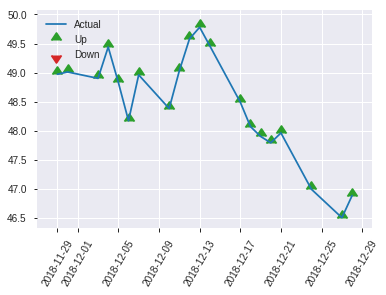


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.47433615281570757
RMSE: 0.6887206638512507
LogLoss: 3.7555472831197094
Mean Per-Class Error: 0.43743638676844787
AUC: 0.5309160305343511
pr_auc: 0.5330440894731387
Gini: 0.061832061068702204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.214384467811966e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    114  0.95     (114.0/120.0)
1      2    129  0.0153   (2.0/131.0)
Total  8    243  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.21438e-08  0.68984   242
max f2                       1.43246e-10  0.846253  249
max f0point5                 1.18118e-05  0.600449  189
max accuracy                 1.18118e-05  0.573705  189
max precision                0.999924     1         0
max recall                   1.43246e-10  1         249
max specificity              0.999924     1         0
max absolute_mcc             1.18118e-05  0.145726  189
max min_per_class_accuracy   0.00188722   0.508333  125
max mean_per_class_accuracy  1.18118e-05  0.562564  189

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 14.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.998627           1.27735   1.27735            0.666667         0.999544     0.666667                    0.999544            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.994795           0.638677  0.958015           0.333333         0.99625      0.5                         0.997897            0.00763359      0.0229008                  -36.1323   -4.19847
    3        0.0318725                   0.982424           0.958015  0.958015           0.5              0.990576     0.5                         0.996067            0.00763359      0.0305344                  -4.19847   -4.19847
    4        0.0438247                   0.958728           0.638677  0.870923           0.333333         0.967586     0.454545                    0.988299            0.00763359      0.0381679                  -36.1323   -12.9077
    5        0.0517928                   0.939433           0.958015  0.884322           0.5              0.946569     0.461538                    0.981879            0.00763359      0.0458015                  -4.19847   -11.5678
    6        0.103586                    0.755798           1.1791    1.03171            0.615385         0.857097     0.538462                    0.919488            0.0610687       0.10687                    17.9096    3.17087
    7        0.151394                    0.356766           1.11768   1.05886            0.583333         0.568105     0.552632                    0.808525            0.0534351       0.160305                   11.7684    5.8859
    8        0.203187                    0.185289           0.884322  1.01437            0.461538         0.241392     0.529412                    0.663962            0.0458015       0.206107                   -11.5678   1.43691
    9        0.302789                    0.0428037          0.919695  0.983226           0.48             0.0831706    0.513158                    0.472912            0.0916031       0.29771                    -8.03053   -1.67738
    10       0.40239                     0.0141339          1.14962   1.02441            0.6              0.0244277    0.534653                    0.361901            0.114504        0.412214                   14.9618    2.44124
    11       0.501992                    0.00188722         0.996336  1.01884            0.52             0.00605645   0.531746                    0.291297            0.0992366       0.51145                    -0.366412  1.88416
    12       0.601594                    0.000218603        1.07298   1.0278             0.56             0.000588973  0.536424                    0.243167            0.10687         0.618321                   7.29771    2.78045
    13       0.701195                    2.99017e-05        1.14962   1.04511            0.6              8.09292e-05  0.545455                    0.208637            0.114504        0.732824                   14.9618    4.51076
    14       0.800797                    6.16822e-06        0.996336  1.03904            0.52             1.45537e-05  0.542289                    0.182689            0.0992366       0.832061                   -0.366412  3.90414
    15       0.900398                    5.09575e-07        0.843053  1.01736            0.44             1.64292e-06  0.530973                    0.16248             0.0839695       0.916031                   -15.6947   1.73613
    16       1                           1.24044e-11        0.843053  1                  

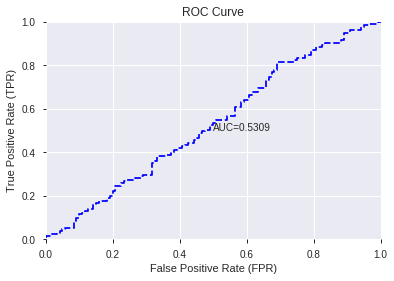

This function is available for GLM models only


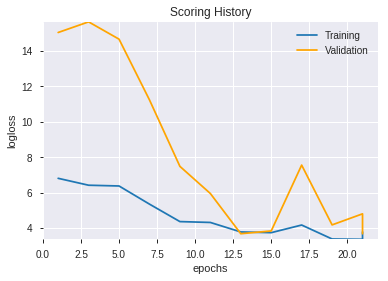

--2019-09-03 03:34:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_032018_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_032018_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CDLSEPARATINGLINES',
 'ADX_14',
 'BETA_14',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'STOCHRSI_fastk',
 'VAR_12',
 'BETA_8',
 'aroondown_14',
 'CDLDARKCLOUDCOVER',
 'ADX_20',
 'aroondown_30',
 'WILLR_8',
 'MFI_12',
 'MACD_signal',
 'aroonup_30',
 'ADXR_8',
 'MACDFIX_signal_14',
 'ATR_14',
 'ROCP_20',
 'STOCH_slowk',
 'CDLRICKSHAWMAN',
 'TRIX_14',
 'AROONOSC_30',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'CORREL_20',
 'NATR_30',
 'BBANDS_middleband_20_7_5',
 'ADX_12',
 'VAR_14',
 'AD',
 'LINEARREG_ANGLE_20',
 'DX_20',
 'CDLHIGHWAVE',
 'ADXR_14',
 'MACDFIX_24',
 'ATR_8',
 'STOCH_slowd',
 'LINEARREG_ANGLE_12',
 'aroonup_24',
 'aroondown_12',
 'AROONOSC_14',
 'BBANDS_lowerband_14_2_5',
 'STOCHF_fastk',
 'CORREL_12',
 'MACDFIX_signal_12',
 'MINUS_DI_20',
 'ROC_20',
 'BBANDS_upperband_20_0_2',
 'CDLSHOOTINGSTAR',
 'MACDEXT',
 'STOCHRSI_fastd',
 'MACDFIX_hist_24',
 'MFI_30'

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_033430_model_1  0.494593  0.697143                   0.5  0.501988  0.251992

variable  relative_importance  scaled_importance  percentage
0                        OBV             0.005460           1.000000    0.016408
1                     MFI_12             0.005442           0.996749    0.016355
2          CDLINVERTEDHAMMER             0.005392           0.987489    0.016203
3             CDLSPINNINGTOP             0.005369           0.983351    0.016135
4                     MFI_20             0.005177           0.948088    0.015556
..                       ...                  ...                ...         ...
349               ROCR100_30             0.000008           0.001497    0.000025
350  BBANDS_upperband_14_6_3             0.000008           0.001390    0.000023
351                  ROCR_30             0.000006           0.001187    0.000019
352  BBANDS_upperband_14_7_5             0.000005           0.000876    0.000014
353                  ROCP_30             0.000004           0.000801    0.000013

[354 rows x 4 columns]

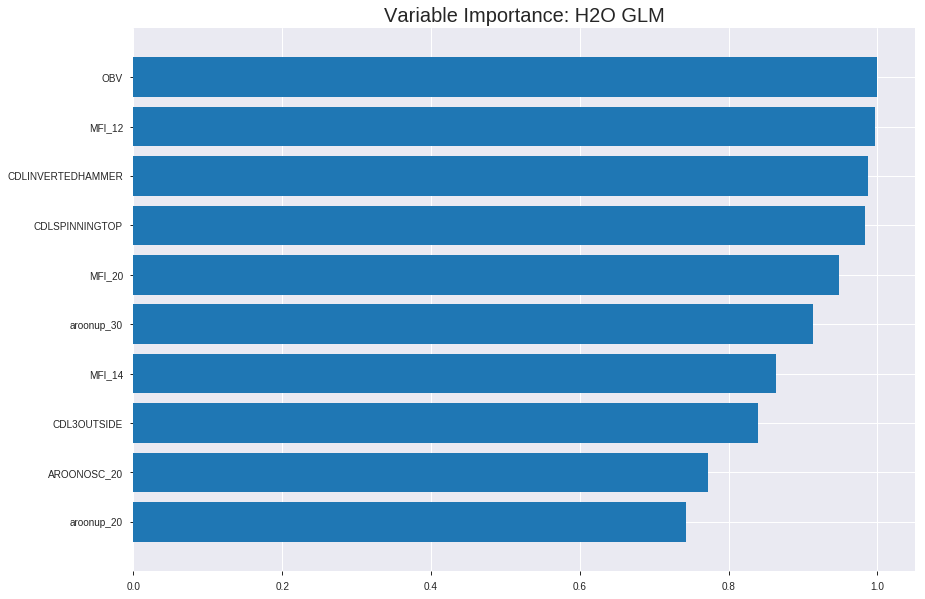

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_033430_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2470693465072883
RMSE: 0.4970607070643266
LogLoss: 0.6872613845817863
Null degrees of freedom: 1753
Residual degrees of freedom: 1399
Null deviance: 2426.732552703876
Residual deviance: 2410.9129371129065
AIC: 3120.9129371129065
AUC: 0.5640256423293999
pr_auc: 0.579074127872629
Gini: 0.12805128465879978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4542189579605922: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    822   0.9892   (822.0/831.0)
1      3    920   0.0033   (3.0/923.0)
Total  12   1742  0.4704   (825.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454219     0.690432  390
max f2                       0.447376     0.847878  396
max f0point5                 0.493041     0.587021  313
max accuracy                 0.534344     0.558723  162
max precision                0.607227     1         0
max recall                   0.447376     1         396
max specificity              0.607227     1         0
max absolute_mcc             0.535433     0.129736  158
max min_per_class_accuracy   0.52857      0.547129  185
max mean_per_class_accuracy  0.535433     0.563621  158

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.581643           1.05574   1.05574            0.555556         0.591676  0.555556                    0.591676            0.0108342       0.0108342                  5.57361   5.57361
    2        0.0205245                   0.576983           1.26688   1.16131            0.666667         0.579394  0.611111                    0.585535            0.0130011       0.0238353                  26.6883   16.131
    3        0.0302166                   0.573452           1.22962   1.18322            0.647059         0.57471   0.622642                    0.582063            0.0119177       0.035753                   22.9622   18.3221
    4        0.0404789                   0.570884           1.05574   1.1509             0.555556         0.572329  0.605634                    0.579595            0.0108342       0.0465872                  5.57361   15.0901
    5        0.050171                    0.568446           1.45319   1.2093             0.764706         0.569666  0.636364                    0.577677            0.0140845       0.0606717                  45.319    20.9298
    6        0.100342                    0.562076           1.1877    1.1985             0.625            0.56461   0.630682                    0.571144            0.0595883       0.12026                    18.7703   19.85
    7        0.149943                    0.556364           1.0703    1.15609            0.563218         0.55909   0.608365                    0.567156            0.0530878       0.173348                   7.0298    15.6091
    8        0.200114                    0.551755           1.14451   1.15319            0.602273         0.554019  0.606838                    0.563863            0.0574215       0.230769                   14.4514   15.3189
    9        0.299886                    0.542493           1.1402    1.14887            0.6              0.546751  0.604563                    0.55817             0.113759        0.344529                   14.0195   14.8866
    10       0.400228                    0.535215           1.15531   1.15048            0.607955         0.539116  0.605413                    0.553393            0.115926        0.460455                   15.5311   15.0482
    11       0.5                         0.528526           0.86872   1.09426            0.457143         0.531874  0.575827                    0.549099            0.0866739       0.547129                   -13.128   9.42579
    12       0.599772                    0.521491           0.988169  1.07661            0.52             0.524991  0.56654                     0.545088            0.0985915       0.64572                    -1.1831   7.661
    13       0.700114                    0.511889           0.799     1.03682            0.420455         0.516924  0.545603                    0.541052            0.0801733       0.725894                   -20.1     3.68223
    14       0.799886                    0.501698           0.912156  1.02127            0.48             0.506716  0.53742                     0.536769            0.0910076       0.816901                   -8.7844   2.12723
    15       0.899658                    0.487266           0.97731   1.0164             0.514286         0.495221  0.534854                    0.532161            0.0975081       0.91441                    -2.269    1.63969
    16       1                           0.436769           0.852987  1                  0.448864         0.473008  0.526226                    0.526226            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504423949208099
RMSE: 0.5004421993805177
LogLoss: 0.6940489933678045
Null degrees of freedom: 501
Residual degrees of freedom: 147
Null deviance: 696.4627613688081
Residual deviance: 696.8251893412756
AIC: 1406.8251893412757
AUC: 0.5260300071445583
pr_auc: 0.5243363605146789
Gini: 0.05206001428911655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4159944579764807: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    245  0.9919   (245.0/247.0)
1      1    254  0.0039   (1.0/255.0)
Total  3    499  0.49     (246.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415994     0.67374   396
max f2                       0.413848     0.837714  399
max f0point5                 0.428222     0.564479  378
max accuracy                 0.510722     0.547809  126
max precision                0.514086     0.604839  101
max recall                   0.413848     1         399
max specificity              0.559958     0.995951  0
max absolute_mcc             0.514086     0.110979  101
max min_per_class_accuracy   0.495442     0.513725  196
max mean_per_class_accuracy  0.510722     0.550838  126

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.549299           0.984314  0.984314           0.5              0.552451  0.5                         0.552451            0.0117647       0.0117647                  -1.56863  -1.56863
    2        0.0219124                   0.546166           0.393725  0.715865           0.2              0.547605  0.363636                    0.550248            0.00392157      0.0156863                  -60.6275  -28.4135
    3        0.0318725                   0.54445            0.787451  0.738235           0.4              0.545088  0.375                       0.548636            0.00784314      0.0235294                  -21.2549  -26.1765
    4        0.0418327                   0.538489           0.787451  0.749953           0.4              0.540717  0.380952                    0.54675             0.00784314      0.0313725                  -21.2549  -25.0047
    5        0.0517928                   0.535751           1.18118   0.832881           0.6              0.53657   0.423077                    0.544793            0.0117647       0.0431373                  18.1176   -16.7119
    6        0.101594                    0.528037           1.10243   0.965013           0.56             0.531778  0.490196                    0.538413            0.054902        0.0980392                  10.2431   -3.49865
    7        0.151394                    0.521517           1.49616   1.13973            0.76             0.524797  0.578947                    0.533934            0.0745098       0.172549                   49.6157   13.9732
    8        0.201195                    0.516484           1.25992   1.16948            0.64             0.51805   0.594059                    0.530002            0.0627451       0.235294                   25.9922   16.9482
    9        0.300797                    0.51118            1.10243   1.14728            0.56             0.513898  0.582781                    0.52467             0.109804        0.345098                   10.2431   14.728
    10       0.400398                    0.503307           0.826824  1.06756            0.42             0.508104  0.542289                    0.520549            0.0823529       0.427451                   -17.3176  6.75641
    11       0.5                         0.495264           0.866196  1.02745            0.44             0.499342  0.521912                    0.516325            0.0862745       0.513725                   -13.3804  2.7451
    12       0.599602                    0.486153           1.06306   1.03337            0.54             0.491472  0.524917                    0.512196            0.105882        0.619608                   6.30588   3.33659
    13       0.699203                    0.480375           0.826824  1.00394            0.42             0.483154  0.509972                    0.508059            0.0823529       0.701961                   -17.3176  0.394391
    14       0.798805                    0.468772           0.905569  0.991678           0.46             0.475992  0.503741                    0.504061            0.0901961       0.792157                   -9.44314  -0.832233
    15       0.898406                    0.443921           1.06306   0.999591           0.54             0.455588  0.507761                    0.498687            0.105882        0.898039                   6.30588   -0.0408678
    16       1                           0.413848           1.00361   1                  0.509804         0.431161  0.507968                    0.49182


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:34:31  0.000 sec   2            3.9       355           1.37452           1.3881
    2019-09-03 03:34:32  0.274 sec   4            2.8       355           1.37303           1.38857
    2019-09-03 03:34:32  0.550 sec   6            2         355           1.37128           1.38904
    2019-09-03 03:34:32  0.834 sec   8            1.5       355           1.36925           1.38944
    2019-09-03 03:34:32  1.115 sec   10           1.1       355           1.36693           1.38981

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6858638743455497)

('auc', 0.49459287531806617)

('logloss', 0.6971426488140763)

('mean_per_class_error', 0.47913486005089057)

('rmse', 0.5019882617861101)

('mse', 0.25199221497104024)

glm prediction progress: |████████████████████████████████████████████████| 100%


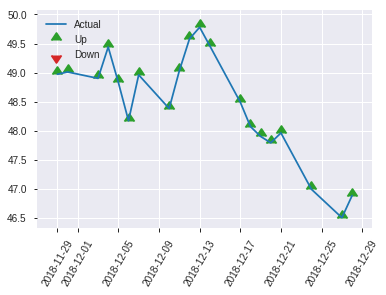


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25199221497104024
RMSE: 0.5019882617861101
LogLoss: 0.6971426488140763
Null degrees of freedom: 250
Residual degrees of freedom: -104
Null deviance: 347.49638460687265
Residual deviance: 349.9656097046663
AIC: 1059.9656097046663
AUC: 0.49459287531806617
pr_auc: 0.5177286636415761
Gini: -0.010814249363867656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43330299325633986: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    120  1        (120.0/120.0)
1      0    131  0        (0.0/131.0)
Total  0    251  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.433303     0.685864   250
max f2                       0.433303     0.845161   250
max f0point5                 0.452043     0.581959   224
max accuracy                 0.453193     0.537849   222
max precision                0.533501     0.714286   6
max recall                   0.433303     1          250
max specificity              0.541309     0.991667   0
max absolute_mcc             0.438094     0.0857769  248
max min_per_class_accuracy   0.483819     0.48855    124
max mean_per_class_accuracy  0.453193     0.520865   222

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 48.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.536438           1.27735   1.27735            0.666667         0.539109  0.666667                    0.539109            0.0152672       0.0152672                  27.7354   27.7354
    2        0.0239044                   0.533896           1.27735   1.27735            0.666667         0.535156  0.666667                    0.537132            0.0152672       0.0305344                  27.7354   27.7354
    3        0.0318725                   0.533448           0.958015  1.19752            0.5              0.533484  0.625                       0.53622             0.00763359      0.0381679                  -4.19847  19.7519
    4        0.0438247                   0.531717           1.27735   1.21929            0.666667         0.532457  0.636364                    0.535194            0.0152672       0.0534351                  27.7354   21.9292
    5        0.0517928                   0.530311           0         1.03171            0                0.531018  0.538462                    0.534551            0               0.0534351                  -100      3.17087
    6        0.103586                    0.51556            0.589548  0.810628           0.307692         0.522132  0.423077                    0.528342            0.0305344       0.0839695                  -41.0452  -18.9372
    7        0.151394                    0.511482           1.59669   1.05886            0.833333         0.513631  0.552632                    0.523696            0.0763359       0.160305                   59.6692   5.8859
    8        0.203187                    0.50608            0.884322  1.01437            0.461538         0.509101  0.529412                    0.519976            0.0458015       0.206107                   -11.5678  1.43691
    9        0.302789                    0.499721           0.766412  0.932804           0.4              0.502634  0.486842                    0.514271            0.0763359       0.282443                   -23.3588  -6.71957
    10       0.40239                     0.49232            1.14962   0.986471           0.6              0.495631  0.514851                    0.509657            0.114504        0.396947                   14.9618   -1.35288
    11       0.501992                    0.483343           0.919695  0.973222           0.48             0.488054  0.507937                    0.505371            0.0916031       0.48855                    -8.03053  -2.67781
    12       0.601594                    0.473323           0.919695  0.96436            0.48             0.477728  0.503311                    0.500794            0.0916031       0.580153                   -8.03053  -3.56403
    13       0.701195                    0.464968           1.22626   1.00156            0.64             0.469085  0.522727                    0.49629             0.122137        0.70229                    22.626    0.156142
    14       0.800797                    0.458671           1.07298   1.01044            0.56             0.461614  0.527363                    0.491977            0.10687         0.80916                    7.29771   1.0444
    15       0.900398                    0.45179            1.07298   1.01736            0.56             0.455867  0.530973                    0.487983            0.10687         0.916031                   7.29771   1.73613
    16       1                           0.433303           0.843053  1                  0.44             0.444825  0.521912                    0.483684     

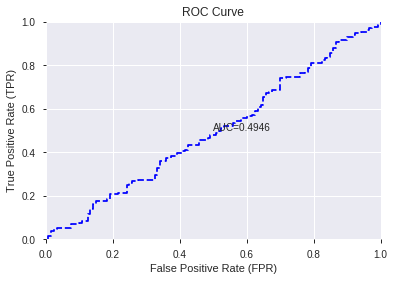

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


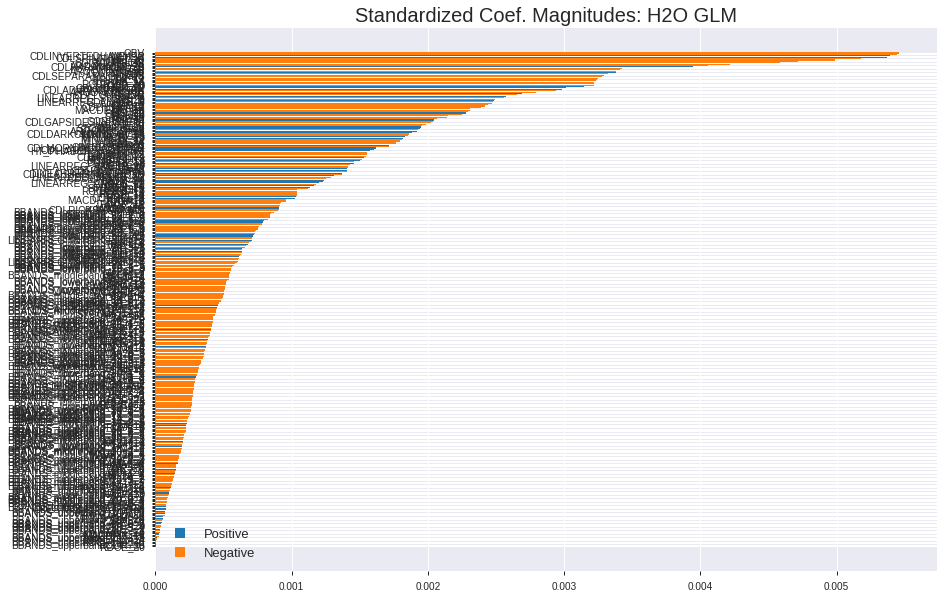

'log_likelihood'
--2019-09-03 03:34:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.216
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.216|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_033430_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_033430_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['OBV',
 'MFI_12',
 'CDLINVERTEDHAMMER',
 'CDLSPINNINGTOP',
 'MFI_20',
 'aroonup_30',
 'MFI_14',
 'CDL3OUTSIDE',
 'AROONOSC_20',
 'aroonup_20',
 'CDLHARAMICROSS',
 'TRANGE',
 'AROONOSC_30',
 'MFI_24',
 'CDLHARAMI',
 'BOP',
 'CDLSEPARATINGLINES',
 'aroonup_24',
 'DX_12',
 'DX_14',
 'aroonup_14',
 'ROCR100_20',
 'ROCP_20',
 'ROC_20',
 'aroondown_20',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'AROONOSC_14',
 'MFI_30',
 'ULTOSC',
 'CDLLONGLINE',
 'LINEARREG_SLOPE_8',
 'DX_20',
 'RSI_8',
 'LINEARREG_ANGLE_8',
 'CDLINNECK',
 'CMO_8',
 'RSI_12',
 'CDLHIKKAKE',
 'CMO_14',
 'MACDEXT_hist',
 'RSI_20',
 'CMO_20',
 'MOM_8',
 'RSI_24',
 'CMO_30',
 'RSI_30',
 'PPO',
 'CORREL_14',
 'CDLGAPSIDESIDEWHITE',
 'CCI_30',
 'WILLR_20',
 'aroonup_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'AROONOSC_24',
 'aroondown_14',
 'MINUS_DI_14',
 'CDLDARKCLOUDCOVER',
 'MOM_20',
 'MINUS_DI_20',
 'MINUS_DI_12',
 'CCI_24',
 'WILLR_24',
 'CCI_20',
 'ADXR_8',
 'MINUS_DI_24',
 'CDLBELTHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',


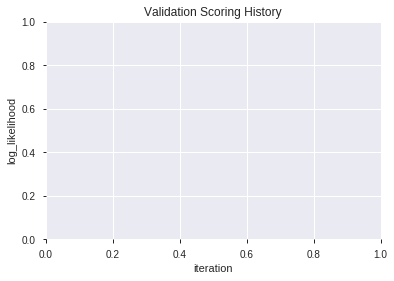

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_033454_model_1  0.573760  0.693263              0.450668  0.499856  0.249856
1  XGBoost_grid_1_AutoML_20190903_033454_model_4  0.550318  0.687683              0.482634  0.497291  0.247298
2  XGBoost_grid_1_AutoML_20190903_033454_model_6  0.537659  0.697136              0.464917  0.501982  0.251986
3  XGBoost_grid_1_AutoML_20190903_033454_model_7  0.517684  0.721684              0.500000  0.513336  0.263514
4  XGBoost_grid_1_AutoML_20190903_033454_model_2  0.515013  0.695345              0.481934  0.501061  0.251062
5               XGBoost_1_AutoML_20190903_033454  0.507634  0.701128              0.486800  0.503894  0.253909
6               XGBoost_3_AutoML_20190903_033454  0.505725  0.716957              0.500000  0.511266  0.261393
7  XGBoost_grid_1_AutoML_20190903_033454_model_3  0.499109  0.714793              0.490967  0.510331  0.260438
8               XGBoost_2_AutoML_20190903_033454  0.498791  0.715880              0.500000  0.510889  0.261007
9  XGBoost_grid_1_AutoML_20190903_033454_model_5  0.481934  0.736030              0.495833  0.519730  0.270119

variable  relative_importance  scaled_importance  percentage
0                         OBV           302.293365           1.000000    0.063989
1              STOCHRSI_fastk           106.793900           0.353279    0.022606
2                   PLUS_DI_8            99.958817           0.330668    0.021159
3                     ADXR_14            88.874359           0.294000    0.018813
4              STOCHRSI_fastd            86.842194           0.287278    0.018383
..                        ...                  ...                ...         ...
181                PLUS_DM_24             3.107444           0.010280    0.000658
182  BBANDS_middleband_24_0_5             2.766461           0.009152    0.000586
183    LINEARREG_INTERCEPT_14             2.358184           0.007801    0.000499
184                    ATR_30             2.340272           0.007742    0.000495
185   BBANDS_lowerband_14_1_5             1.209654           0.004002    0.000256

[186 rows x 4 columns]

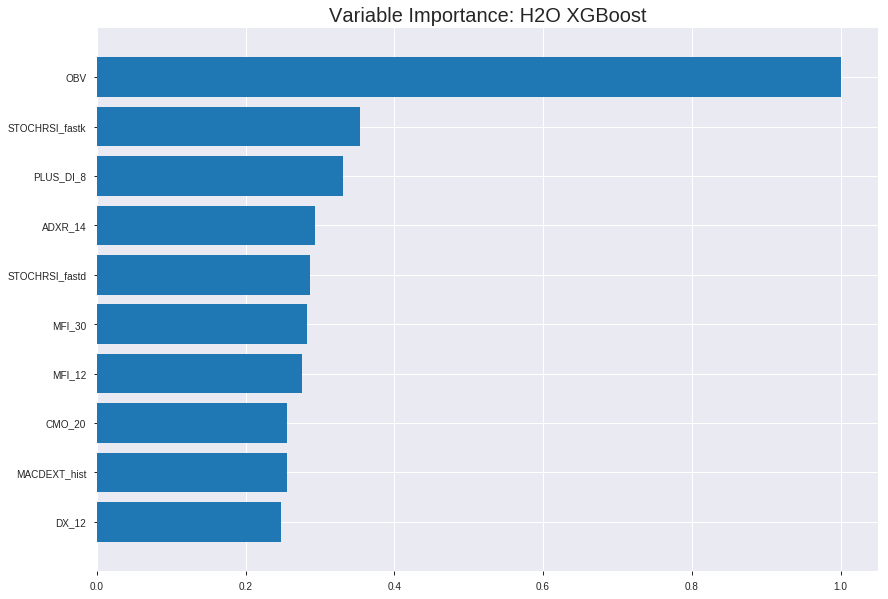

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_033454_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1856895740564743
RMSE: 0.43091713131004006
LogLoss: 0.5606762962626408
Mean Per-Class Error: 0.1444317110661748
AUC: 0.9264999419827303
pr_auc: 0.9341287452183058
Gini: 0.8529998839654607
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5165510773658752: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      686  145  0.1745   (145.0/831.0)
1      112  811  0.1213   (112.0/923.0)
Total  798  956  0.1465   (257.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516551     0.863225  203
max f2                       0.466706     0.905856  253
max f0point5                 0.534746     0.873558  184
max accuracy                 0.525541     0.855188  194
max precision                0.835422     1         0
max recall                   0.296247     1         376
max specificity              0.835422     1         0
max absolute_mcc             0.525541     0.710342  194
max min_per_class_accuracy   0.522782     0.852654  196
max mean_per_class_accuracy  0.525541     0.855568  194

Gains/Lift Table: Avg response rate: 52.62 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.734975           1.90033    1.90033            1                0.757612  1                           0.757612            0.0195016       0.0195016                  90.0325   90.0325
    2        0.0205245                   0.718636           1.90033    1.90033            1                0.727206  1                           0.742409            0.0195016       0.0390033                  90.0325   90.0325
    3        0.0302166                   0.707515           1.90033    1.90033            1                0.713129  1                           0.733018            0.0184182       0.0574215                  90.0325   90.0325
    4        0.0404789                   0.695397           1.90033    1.90033            1                0.700655  1                           0.724813            0.0195016       0.0769231                  90.0325   90.0325
    5        0.050171                    0.689346           1.90033    1.90033            1                0.692346  1                           0.718541            0.0184182       0.0953413                  90.0325   90.0325
    6        0.100342                    0.661097           1.90033    1.90033            1                0.673724  1                           0.696132            0.0953413       0.190683                   90.0325   90.0325
    7        0.149943                    0.63549            1.81295    1.87142            0.954023         0.647832  0.984791                    0.680155            0.0899242       0.280607                   81.2954   87.1423
    8        0.200114                    0.619323           1.83554    1.86243            0.965909         0.627288  0.980057                    0.6669              0.092091        0.372698                   83.5541   86.2427
    9        0.299886                    0.586114           1.77002    1.83168            0.931429         0.602997  0.963878                    0.64564             0.176598        0.549296                   77.0017   83.1682
    10       0.400228                    0.558414           1.53322    1.75685            0.806818         0.571688  0.924501                    0.627099            0.153846        0.703142                   53.3217   75.6853
    11       0.5                         0.527677           1.30308    1.66631            0.685714         0.542865  0.876853                    0.610291            0.130011        0.833153                   30.308    66.6306
    12       0.599772                    0.498467           0.770989   1.51737            0.405714         0.513727  0.798479                    0.594227            0.0769231       0.910076                   -22.9011  51.737
    13       0.700114                    0.465918           0.550662   1.37882            0.289773         0.481627  0.72557                     0.578089            0.0552546       0.96533                    -44.9338  37.8819
    14       0.799886                    0.436364           0.238898   1.23663            0.125714         0.45182   0.650748                    0.562339            0.0238353       0.989166                   -76.1102  23.6633
    15       0.899658                    0.385808           0.086872   1.10913            0.0457143        0.414911  0.58365                     0.54599             0.00866739      0.997833                   -91.3128  10.9125
    16       1                           0.164053           0.0215946  1                  0.0113636        0.328451  0.526226                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2618979338595348
RMSE: 0.5117596446179933
LogLoss: 0.718574000628826
Mean Per-Class Error: 0.48014606652377556
AUC: 0.49848376597602606
pr_auc: 0.5197025103118937
Gini: -0.0030324680479478783
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23201556503772736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    241  0.9757   (241.0/247.0)
1      0    255  0        (0.0/255.0)
Total  6    496  0.4801   (241.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232016     0.679095  393
max f2                       0.232016     0.841029  393
max f0point5                 0.232016     0.569451  393
max accuracy                 0.232016     0.51992   393
max precision                0.767536     1         0
max recall                   0.232016     1         393
max specificity              0.767536     1         0
max absolute_mcc             0.232016     0.111752  393
max min_per_class_accuracy   0.50059      0.486275  197
max mean_per_class_accuracy  0.623688     0.519854  61

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.719254           1.31242   1.31242            0.666667         0.740878  0.666667                    0.740878            0.0156863       0.0156863                  31.2418   31.2418
    2        0.0219124                   0.695083           0.787451  1.0738             0.4              0.703814  0.545455                    0.724031            0.00784314      0.0235294                  -21.2549  7.37968
    3        0.0318725                   0.683736           1.5749    1.23039            0.8              0.688357  0.625                       0.712883            0.0156863       0.0392157                  57.4902   23.0392
    4        0.0418327                   0.674789           1.18118   1.21867            0.6              0.678429  0.619048                    0.70468             0.0117647       0.0509804                  18.1176   21.8674
    5        0.0517928                   0.66349            0.787451  1.13575            0.4              0.669901  0.576923                    0.697991            0.00784314      0.0588235                  -21.2549  13.5747
    6        0.101594                    0.634354           1.02369   1.08082            0.52             0.647718  0.54902                     0.673347            0.0509804       0.109804                   2.36863   8.08151
    7        0.151394                    0.614358           1.10243   1.08793            0.56             0.625234  0.552632                    0.657521            0.054902        0.164706                   10.2431   8.79257
    8        0.201195                    0.589068           0.866196  1.03304            0.44             0.600452  0.524752                    0.643395            0.0431373       0.207843                   -13.3804  3.30421
    9        0.300797                    0.550899           0.944941  1.00387            0.48             0.571747  0.509934                    0.619671            0.0941176       0.301961                   -5.50588  0.386963
    10       0.400398                    0.523444           1.02369   1.0088             0.52             0.536721  0.512438                    0.599036            0.101961        0.403922                   2.36863   0.879914
    11       0.5                         0.500382           0.826824  0.972549           0.42             0.512402  0.494024                    0.581779            0.0823529       0.486275                   -17.3176  -2.7451
    12       0.599602                    0.475192           0.984314  0.974503           0.5              0.48816   0.495017                    0.566227            0.0980392       0.584314                   -1.56863  -2.54967
    13       0.699203                    0.447612           1.1418    0.998335           0.58             0.462973  0.507123                    0.551519            0.113725        0.698039                   14.1804   -0.166471
    14       0.798805                    0.410522           0.944941  0.991678           0.48             0.431399  0.503741                    0.536541            0.0941176       0.792157                   -5.50588  -0.832233
    15       0.898406                    0.337557           0.944941  0.986496           0.48             0.376655  0.501109                    0.518815            0.0941176       0.886275                   -5.50588  -1.35038
    16       1                           0.203266           1.11942   1                  0.568627         0.282326  0.507968                    0.49479  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:35:02  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.473774                         0.5                0.693147              0.5               0                    1                  0.492032
    2019-09-03 03:35:03  0.436 sec   5                  0.488275         0.669871            0.739577        0.763644           1.90033          0.330103                         0.50076            0.694684              0.503255          0.494122             0.770332           0.492032
    2019-09-03 03:35:03  0.533 sec   10                 0.479094         0.651896            0.807876        0.815496           1.90033          0.27309                          0.500923           0.695031              0.514154          0.529464             1.40616            0.486056
    2019-09-03 03:35:03  0.638 sec   15                 0.470726         0.635707            0.84787         0.854429           1.90033          0.22805                          0.501752           0.696721              0.508042          0.524037             1.31242            0.484064
    2019-09-03 03:35:03  0.737 sec   20                 0.463978         0.622735            0.864055        0.873802           1.90033          0.209806                         0.502295           0.697917              0.513225          0.534226             0.984314           0.482072
    2019-09-03 03:35:03  0.840 sec   25                 0.456702         0.608872            0.88422         0.894154           1.90033          0.193273                         0.502818           0.699035              0.51652           0.530881             1.31242            0.48008
    2019-09-03 03:35:03  0.937 sec   30                 0.450881         0.597855            0.893519        0.90311            1.90033          0.200114                         0.504777           0.703297              0.519584          0.527671             1.31242            0.484064
    2019-09-03 03:35:03  1.026 sec   35                 0.447083         0.590678            0.898564        0.907991           1.90033          0.188141                         0.506803           0.707755              0.512336          0.517197             0.984314           0.486056
    2019-09-03 03:35:03  1.135 sec   40                 0.441269         0.579766            0.907483        0.915735           1.90033          0.171608                         0.508718           0.711791              0.503533          0.514282             1.31242            0.484064
    2019-09-03 03:35:03  1.237 sec   45                 0.436026         0.570032            0.916558        0.924473           1.90033          0.163626                         0.510225           0.715165              0.502096          0.519516             1.31242            0.484064
    2019-09-03 03:35:03  1.339 sec   50                 0.430917         0.560676            0.9265          0.934129           1.90033          0.146522                         0.51176            0.718574              0.498484          0.519703             1.31242            0.48008

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
OBV                       302.2933654785156      1.0                   0.0639892224801286
STOCHRSI_fastk            106.79389953613281     0.3532790055351803    0.02260604888274924
PLUS_DI_8                 99.95881652832031      0.33066824463742495   0.021159203873217777
ADXR_14                   88.87435913085938      0.2940003628269367    0.018812854626171382
STOCHRSI_fastd            86.84219360351562      0.28727786819286844   0.01838268742141052
---                       ---                    ---                   ---
PLUS_DM_24                3.1074438095092773     0.01027956337907167   0.0006577812680619996
BBANDS_middleband_24_0_5  2.7664613723754883     0.009151578196221128  0.0005856023732422877
LINEARREG_INTERCEPT_14    2.3581838607788086     0.007800977891280938  0.0004991785098477404
ATR_30                    2.3402724266052246     0.007741726064350396  0.0004953870315119279
BBANDS_lowerband_14_1_5   1.2096543312072754     0.00400159073717166   0.0002560586799552992


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6894586894586895)

('auc', 0.5737595419847329)

('logloss', 0.6932634427448726)

('mean_per_class_error', 0.42029262086513997)

('rmse', 0.49985614398292927)

('mse', 0.24985616467748292)

xgboost prediction progress: |████████████████████████████████████████████| 100%


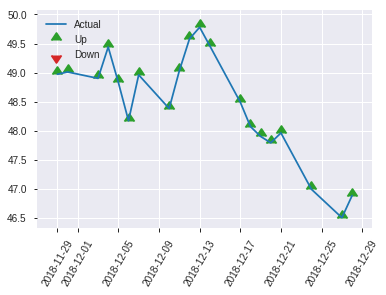


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24985616467748292
RMSE: 0.49985614398292927
LogLoss: 0.6932634427448726
Mean Per-Class Error: 0.42029262086513997
AUC: 0.5737595419847329
pr_auc: 0.5901126086316733
Gini: 0.14751908396946578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3610738515853882: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   99   0.825    (99.0/120.0)
1      10   121  0.0763   (10.0/131.0)
Total  31   220  0.4343   (109.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361074     0.689459  217
max f2                       0.281805     0.845161  248
max f0point5                 0.361074     0.598417  217
max accuracy                 0.502398     0.573705  90
max precision                0.644137     1         0
max recall                   0.281805     1         248
max specificity              0.644137     1         0
max absolute_mcc             0.541057     0.174373  51
max min_per_class_accuracy   0.466202     0.533333  124
max mean_per_class_accuracy  0.502398     0.579707  90

Gains/Lift Table: Avg response rate: 52.19 %, avg score: 46.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.634925           1.27735   1.27735            0.666667         0.640898  0.666667                    0.640898            0.0152672       0.0152672                  27.7354    27.7354
    2        0.0239044                   0.619887           1.91603   1.59669            1                0.625373  0.833333                    0.633135            0.0229008       0.0381679                  91.6031    59.6692
    3        0.0318725                   0.614805           1.91603   1.67653            1                0.616684  0.875                       0.629023            0.0152672       0.0534351                  91.6031    67.6527
    4        0.0438247                   0.61203            0.638677  1.39348            0.333333         0.613263  0.727273                    0.624725            0.00763359      0.0610687                  -36.1323   39.3477
    5        0.0517928                   0.602341           0.958015  1.32648            0.5              0.605896  0.692308                    0.621828            0.00763359      0.0687023                  -4.19847   32.6483
    6        0.103586                    0.577383           1.03171   1.1791             0.538462         0.58737   0.615385                    0.604599            0.0534351       0.122137                   3.17087    17.9096
    7        0.151394                    0.558502           1.43702   1.26055            0.75             0.567558  0.657895                    0.592902            0.0687023       0.19084                    43.7023    26.0546
    8        0.203187                    0.541434           1.47387   1.31492            0.769231         0.550347  0.686275                    0.582054            0.0763359       0.267176                   47.387     31.4923
    9        0.302789                    0.516342           0.919695  1.18491            0.48             0.528098  0.618421                    0.564305            0.0916031       0.358779                   -8.03053   18.4914
    10       0.40239                     0.492166           1.07298   1.15721            0.56             0.50573   0.60396                     0.549807            0.10687         0.465649                   7.29771    15.7207
    11       0.501992                    0.466202           0.689771  1.06446            0.36             0.477842  0.555556                    0.535528            0.0687023       0.534351                   -31.0229   6.44614
    12       0.601594                    0.435082           0.843053  1.0278             0.44             0.449902  0.536424                    0.521351            0.0839695       0.618321                   -15.6947   2.78045
    13       0.701195                    0.404748           1.14962   1.04511            0.6              0.417042  0.545455                    0.506535            0.114504        0.732824                   14.9618    4.51076
    14       0.800797                    0.381153           0.996336  1.03904            0.52             0.392046  0.542289                    0.492295            0.0992366       0.832061                   -0.366412  3.90414
    15       0.900398                    0.356303           0.919695  1.02584            0.48             0.368108  0.535398                    0.478557            0.0916031       0.923664                   -8.03053   2.58394
    16       1                           0.281805           0.766412  1                  0.4              0.326695  0.521912                    

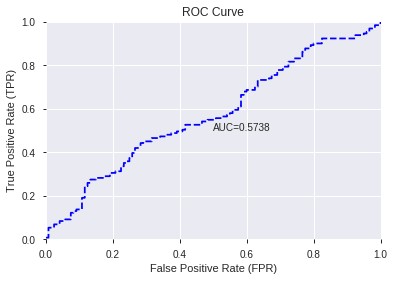

This function is available for GLM models only


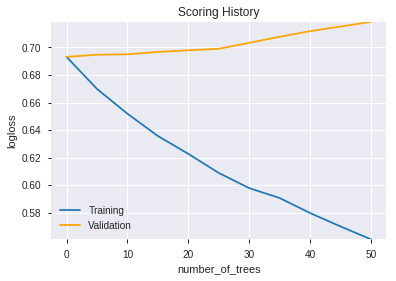

--2019-09-03 03:35:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_033454_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_033454_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a0ce',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['OBV',
 'STOCHRSI_fastk',
 'PLUS_DI_8',
 'ADXR_14',
 'STOCHRSI_fastd',
 'MFI_30',
 'MFI_12',
 'CMO_20',
 'MACDEXT_hist',
 'DX_12',
 'PLUS_DM_8',
 'MACDFIX_12',
 'BETA_12',
 'MFI_24',
 'BETA_8',
 'CCI_20',
 'ULTOSC',
 'RSI_12',
 'PLUS_DI_14',
 'CMO_30',
 'DEMA_24',
 'aroondown_20',
 'BBANDS_upperband_20_7_3',
 'STOCH_slowd',
 'MFI_14',
 'MINUS_DM_14',
 'BBANDS_upperband_14_2_2',
 'TRANGE',
 'TRIX_14',
 'LINEARREG_ANGLE_8',
 'STOCHF_fastk',
 'ROC_24',
 'ADX_20',
 'BOP',
 'WILLR_30',
 'ROCP_30',
 'CCI_14',
 'BBANDS_lowerband_14_2_2',
 'aroondown_24',
 'NATR_30',
 'PLUS_DI_12',
 'BBANDS_upperband_30_1_5',
 'DX_20',
 'MACDFIX_signal_24',
 'STDDEV_8',
 'MACDFIX_hist_8',
 'BBANDS_upperband_14_3_2',
 'LINEARREG_ANGLE_14',
 'WILLR_24',
 'MINUS_DI_24',
 'CCI_24',
 'MOM_14',
 'BBANDS_lowerband_24_5_4',
 'ADX_12',
 'MACDFIX_hist_12',
 'AD',
 'WILLR_14',
 'BETA_14',
 'CDLSPINNINGTOP',
 'PLUS_DM_20',
 'CORREL_20',
 'aroonup_12',
 'HT_PHASOR_quadrature',
 'CORREL_14',
 'WILLR_12',
 'MINUS_DI_20',
 '

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.578
GLM             0.578
XGBoost         0.590
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.578    0.558
DLF          0.534  0.554    0.590
Fwe          0.570  0.578    0.558
RFE          0.574  0.538    0.574
XGBF         0.574  0.554    0.590





F1


DeepLearning    0.692
GLM             0.690
XGBoost         0.694
dtype: float64

DeepLearning    GLM  XGBoost
All          0.692  0.690    0.694
DLF          0.689  0.688    0.693
Fwe          0.690  0.690    0.694
RFE          0.690  0.686    0.689
XGBF         0.690  0.688    0.693





auc


DeepLearning    0.556
GLM             0.546
XGBoost         0.574
dtype: float64

DeepLearning    GLM  XGBoost
All          0.541  0.546    0.562
DLF          0.508  0.497    0.556
Fwe          0.553  0.546    0.562
RFE          0.531  0.495    0.574
XGBF         0.556  0.497    0.556





logloss


DeepLearning    3.794
GLM             6.958
XGBoost         0.697
dtype: float64

DeepLearning    GLM  XGBoost
All          3.794  6.958    0.686
DLF          0.696  0.693    0.697
Fwe          2.392  6.958    0.686
RFE          3.756  0.697    0.693
XGBF         0.692  0.693    0.697





mean_per_class_error


DeepLearning    0.469
GLM             0.479
XGBoost         0.446
dtype: float64

DeepLearning    GLM  XGBoost
All          0.427  0.428    0.446
DLF          0.469  0.459    0.417
Fwe          0.431  0.428    0.446
RFE          0.437  0.479    0.420
XGBF         0.437  0.459    0.417





rmse


DeepLearning    0.689
GLM             0.686
XGBoost         0.502
dtype: float64

DeepLearning    GLM  XGBoost
All          0.661  0.686    0.496
DLF          0.501  0.500    0.502
Fwe          0.595  0.686    0.496
RFE          0.689  0.502    0.500
XGBF         0.499  0.500    0.502





mse


DeepLearning    0.474
GLM             0.470
XGBoost         0.252
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.470    0.246
DLF          0.251  0.250    0.252
Fwe          0.354  0.470    0.246
RFE          0.474  0.252    0.250
XGBF         0.249  0.250    0.252

{'F1':       DeepLearning    GLM  XGBoost
 All          0.692    NaN      NaN
 DLF          0.689    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.693
 All            NaN  0.690      NaN
 All            NaN    NaN    0.694
 XGBF         0.690    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.693
 Fwe          0.690    NaN      NaN
 Fwe            NaN  0.690      NaN
 Fwe            NaN    NaN    0.694
 RFE          0.690    NaN      NaN
 RFE            NaN  0.686      NaN
 RFE            NaN    NaN    0.689,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.534    NaN      NaN
 DLF            NaN  0.554      NaN
 DLF            NaN    NaN    0.590
 All            NaN  0.578      NaN
 All            NaN    NaN    0.558
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.554      NaN
 XGBF           NaN    NaN    0.590
 Fwe          0.570    NaN      NaN
 Fwe     